In [ ]:
#imports
import os
import sys
import pandas as pd 
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import itertools

from sqlalchemy import func, Integer, case, distinct
from tabulate import tabulate  
from scipy.stats import chi2_contingency
from IPython.display import HTML, display, Markdown
from matplotlib import colormaps
from matplotlib.patches import Patch

if not os.path.exists("./DABI1.db"):
    !sh ../scripts/unzip.sh
    !python ../scripts/load_data_into_db.py


notebook_dir = os.getcwd()  
module_path = os.path.abspath(os.path.join(notebook_dir, '..'))  
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.db import get_engine, get_session
from custom_types.db_models import Order, Product, Einkaufskorb, Department, Aisle

engine = get_engine(path = "sqlite:///DABI1.db")
session = get_session(engine)

abbildung = 1

Verbindung erfolgreich


# 📊 Datenanalyse des Instacarts-Datensatzes
### *für die Marketing- und Dispositionsabteilung*

---

## 👥 **Projektteam**

| Name | Matrikelnummer |
|------|----------------|
| Benjamin | - |
| Vladimir | - |
| Jan-David Wiederstein | 88219 |

---


## 📝 **Inhaltsverzeichnis**
1. [EDA Marketing](#marketing)
2. [EDA Disposition](#disposition)
3. [Konkrete Fragen](#fragen)
4. [Handlungsempfehlungen](#handlungsempfehlungen)

---
# <h1 id="marketing">EDA Marketing</h1>

In [2]:
# insert Benjamins solution here

---
# <h1 id="disposition">EDA Disposition</h1>

## 📊 1. Allgemeine Analyse des Trinkgeldverhaltens

<div style="padding: 15px; border-radius: 5px; border-left: 5px solid #3498db; margin: 10px 0;">
    <strong>🎯 Zielsetzung:</strong>
    <p style="margin: 10px 0 0 0;">
        Untersuchung der generellen Verteilung der Trinkgeldvergabe über alle Bestellungen hinweg.
    </p>
</div>

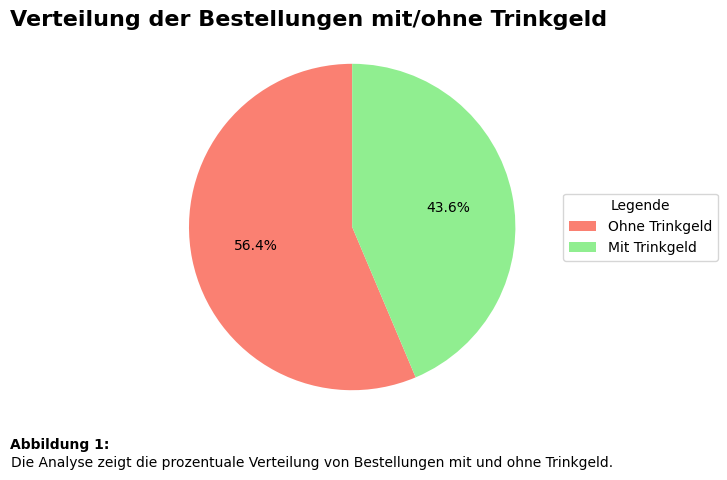

|    | tips   |   count |   percentage |
|---:|:-------|--------:|-------------:|
|  0 | False  |  942908 |      56.3596 |
|  1 | True   |  730113 |      43.6404 |

In [320]:
tip_counts = (
    session.query(
        Order.tips,               
        func.count(Order.order_id)  
    )
    .group_by(Order.tips)
    .all()
)

tip_counts_df = pd.DataFrame(tip_counts, columns=['tips', 'count'])
total_orders = tip_counts_df['count'].sum()
tip_counts_df['percentage'] = (tip_counts_df['count'] / total_orders) * 100
table_markdown = tabulate(tip_counts_df, headers='keys', tablefmt='pipe')

plt.figure(figsize=(6, 6))

labels = ['Ohne Trinkgeld', 'Mit Trinkgeld']
colors = ['salmon', 'lightgreen']
patches, texts, autotexts = plt.pie(tip_counts_df['count'],
                                   autopct='%1.1f%%',
                                   colors=colors,
                                   startangle=90)

plt.legend(patches, labels, title="Legende", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))


fig = plt.gcf()  
fig.text(0.415, 0.875, 'Verteilung der Bestellungen mit/ohne Trinkgeld', 
         fontweight='bold', fontsize=16, ha='center')
description = 'Die Analyse zeigt die prozentuale Verteilung von Bestellungen mit und ohne Trinkgeld.'
fig.text(0, 0.17, f'Abbildung 1:', fontweight='bold', ha='center')
fig.text(0.42, 0.14, description, ha='center')

plt.subplots_adjust(bottom=0.2, right=0.85)  

plt.show()
display(Markdown(f"{table_markdown}"))

<div style="padding: 10px; border-radius: 5px; border-left: 5px solid #3498db;">
<b>📊 Interpretation:</b><br>
Es gibt im Allgemeinen etwas mehr Bestellungen ohne Trinkgeld als Bestellungen mit Trinkgeld.<br>
<br>
<b>📌 Nächster Schritt:</b><br>
Wir möchten nun herausfinden welche Ursachen es haben könnte, wieso es weniger Bestellungen ohne Trinkgeld gibt. Außerdem wollen wir herausfinden ob es möglicherweise Variablen gibt die im Zusammenhang mit der Trinkgeldvergabe stehen
</div>

## 📈 2. Produktspezifische Analyse

<div style="padding: 15px; border-radius: 5px; border-left: 5px solid #3498db; margin: 10px 0;">
    <strong>🎯 Zielsetzung:</strong>
    <p style="margin: 10px 0 0 0;">
        Analyse des Trinkgeldverhaltens in Bezug auf spezifische Produktkategorien und deren Einfluss auf das Kundenverhalten.
    </p>
</div>

In [321]:
# Query: Anzahl der Bestellungen mit und ohne Trinkgeld pro Abteilung
orders_by_department_with_tips = session.query(
    Department.department_name,
    func.sum(case((Order.tips == True, 1), else_=0)).label('orders_with_tips'),
    func.sum(case((Order.tips == False, 1), else_=0)).label('orders_without_tips')
).join(Product, Product.department_id == Department.department_id)\
 .join(Einkaufskorb, Einkaufskorb.product_id == Product.product_id)\
 .join(Order, Einkaufskorb.order_id == Order.order_id)\
 .group_by(Department.department_name).all()

departments = [department for department, _, _ in orders_by_department_with_tips]
orders_with_tips = [orders_with_tips for _, orders_with_tips, _ in orders_by_department_with_tips]
orders_without_tips = [orders_without_tips for _, _, orders_without_tips in orders_by_department_with_tips]


### 📊 Analyse des Trinkgeldverhaltens nach Produktabteilungen
<div style="padding: 10px; border-radius: 5px; border-left: 5px solid #3498db;">
    <div padding: 20px; border-radius: 8px; border-left: 5px solid #28a745; margin: 10px 0;">
        <strong style="margin-top: 0;">📈 Visualisierung</strong>
        <p style="margin-bottom: 15px; line-height: 1.6;">
            Der folgende Graph zeigt die Verteilung von Bestellungen mit und ohne Trinkgeld für verschiedene Produktabteilungen. 
            Die Abteilungen sind nach dem Verhältnis von Trinkgeld-Bestellungen zu Gesamtbestellungen sortiert.
        </p>
        <p style="margin-bottom: 20px; line-height: 1.6;">
            <strong>Wichtig:</strong> Eine Bestellung wird einer Produktabteilung zugeordnet, wenn sie mindestens ein Produkt 
            dieser Abteilung enthält. Dabei kann eine Bestellung mehreren Produktabteilungen zugeteilt werden.
        </p>
        <strong style="margin-top: 0;">🔍 Lesehinweise</strong>
        <ul style="list-style-type: none; padding-left: 0;">
            <li style="margin-bottom: 5px;">📊 <strong>Balken:</strong> Zeigen absolute Anzahl der Bestellungen</li>
            <li style="margin-bottom: 5px;">🟢 <strong>Grün:</strong> Bestellungen mit Trinkgeld</li>
            <li style="margin-bottom: 5px;">🔴 <strong>Rot:</strong> Bestellungen ohne Trinkgeld</li>
            <li style="margin-bottom: 5px;">📝 <strong>Verhältnis:</strong> Zahlen rechts zeigen Quotient (Trinkgeld/Gesamt)</li>
        </ul>
    </div>
</div>


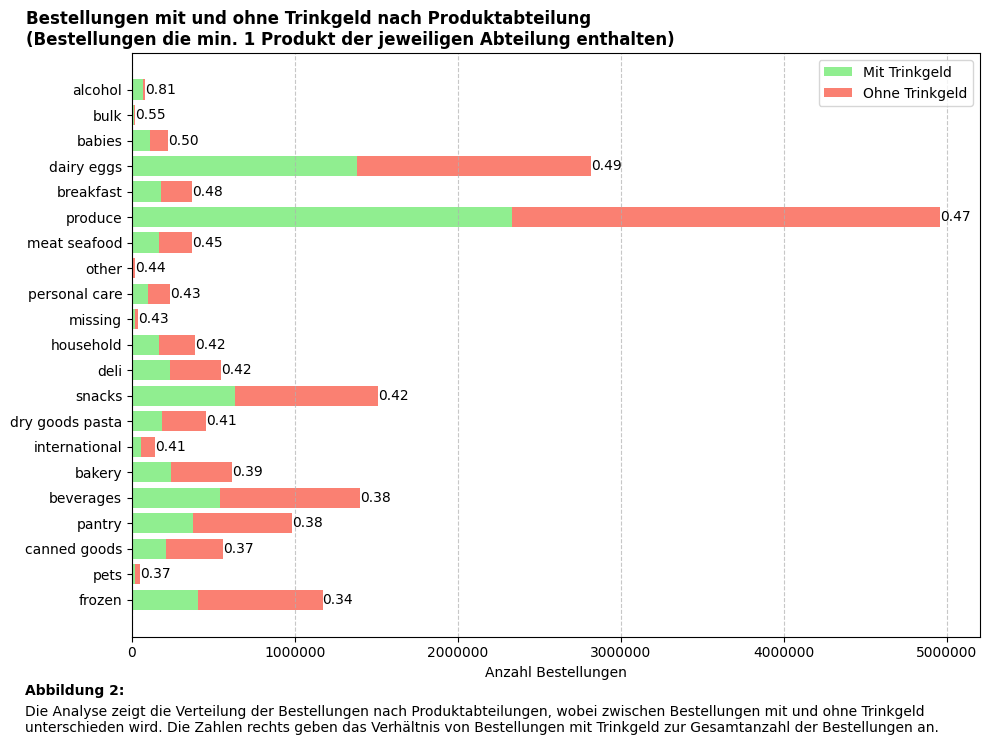

In [322]:
# plot code
# Positionen für die Balken (nun nach Quotienten sortiert)
ratios = [
    orders_with_tips[i] / (orders_with_tips[i] + orders_without_tips[i]) if (orders_with_tips[i] + orders_without_tips[i]) > 0 else 0
    for i in range(len(departments))
]

# Abteilungen nach dem Quotienten sortieren (Index des Quotienten als Sortierschlüssel)
sorted_indices = np.argsort(ratios)

# Abteilungen und Bestellungen nach der Sortierung anpassen
departments_sorted = [departments[i] for i in sorted_indices]
orders_with_tips_sorted = [orders_with_tips[i] for i in sorted_indices]
orders_without_tips_sorted = [orders_without_tips[i] for i in sorted_indices]
ratios_sorted = [ratios[i] for i in sorted_indices]

x = np.arange(len(departments_sorted))

fig, ax = plt.subplots(figsize=(10, 7))
plt.subplots_adjust(left=0.08)
bar_width = 0.5

ax.barh(x, orders_with_tips_sorted, color='lightgreen', label='Mit Trinkgeld')
ax.barh(x, orders_without_tips_sorted, left=orders_with_tips_sorted, color='salmon', label='Ohne Trinkgeld')

ax.set_xlabel('Anzahl Bestellungen')
ax.set_yticks(x)
ax.set_yticklabels(departments_sorted)
ax.set_title('Bestellungen mit und ohne Trinkgeld nach Produktabteilung\n(Bestellungen die min. 1 Produkt der jeweiligen Abteilung enthalten)', 
             loc='left', 
             weight='bold', 
             x=-0.125
             )

# Quotienten (Bestellungen mit Trinkgeld / Gesamtbestellungen) berechnen und anzeigen
for i, department in enumerate(departments_sorted):
    total_orders = orders_with_tips_sorted[i] + orders_without_tips_sorted[i]
    ratio = ratios_sorted[i]
    
    ax.text(
        orders_with_tips_sorted[i] + orders_without_tips_sorted[i] + 100,
        i,
        f'{ratio:.2f}',
        va='center',
        ha='left',
        fontsize=10,
        color='black'
    )

ax.legend(loc='upper right')
ax.ticklabel_format(style='plain', axis='x')
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

title = 'Abbildung 2:'
description = 'Die Analyse zeigt die Verteilung der Bestellungen nach Produktabteilungen, wobei zwischen Bestellungen mit und ohne Trinkgeld unterschieden wird. Die Zahlen rechts geben das Verhältnis von Bestellungen mit Trinkgeld zur Gesamtanzahl der Bestellungen an.'

fig.text(0.03, 0, title, fontweight='bold')
fig.text(0.03, -0.05, description, wrap=True)

plt.tight_layout()
plt.show()

### 📊 Chi-Quadrat-Test: Analyse der Verteilungsunterschiede

<div style="padding: 15px; border-radius: 5px; border-left: 5px solid #3498db; margin: 10px 0;">
    <strong>🎯 Zielsetzung:</strong>
    <p style="margin: 10px 0;">
        Statistische Überprüfung, ob die beobachteten Unterschiede in der Verteilung von Bestellungen mit und ohne Trinkgeld 
        signifikant sind.
    </p>
    <strong>📌 Hypothesen:</strong>
    <ul>
        <li>H₀: Keine Abhängigkeit zwischen Produktabteilung und Trinkgeldverhalten</li>
        <li>H₁: Signifikanter Zusammenhang zwischen Produktabteilung und Trinkgeldverhalten</li>
    </ul>
    <strong>⚙️ Testparameter:</strong>
    <ul>
        <li>Signifikanzniveau: α = 0.05</li>
        <li>Statistische Methode: Chi-Quadrat-Unabhängigkeitstest</li>
    </ul>
</div>

In [240]:
# chi² code
contingency_table = pd.DataFrame({
    'Mit_Trinkgeld': orders_with_tips,
    'Ohne_Trinkgeld': orders_without_tips
}, index=departments)

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Testergebnisse in Tabelle formatieren
test_results = [
    ["Chi-Quadrat Statistik", f"{chi2}"],
    ["p-Wert", f"{p_value}"],
    ["Freiheitsgrade", dof]
]

print("\nChi-Quadrat Testergebnisse:")
print(tabulate(test_results, headers=["Metrik", "Wert"], 
              tablefmt="fancy_grid", numalign="right"))

alpha = 0.05
print("\nInterpretation:")
if p_value < alpha:
    interpretation = [
        ["Ergebnis", "Statistisch signifikanter Zusammenhang"],
        ["Begründung", f"p-Wert ({p_value}) < Signifikanzniveau ({alpha})"],
        ["Schlussfolgerung", "Department und Trinkgeldvergabe sind abhängig"]
    ]
else:
    interpretation = [
        ["Ergebnis", "Kein statistisch signifikanter Zusammenhang"],
        ["Begründung", f"p-Wert ({p_value}) > Signifikanzniveau ({alpha})"],
        ["Schlussfolgerung", "Department und Trinkgeldvergabe sind unabhängig"]
    ]

print(tabulate(interpretation, headers=["", ""], 
              tablefmt="fancy_grid"))

contingency_table['Gesamt'] = contingency_table['Mit_Trinkgeld'] + contingency_table['Ohne_Trinkgeld']
contingency_table['Anteil_mit_Trinkgeld'] = (contingency_table['Mit_Trinkgeld'] / contingency_table['Gesamt']).round(3)

print("\nKontingenztabelle:")
print(tabulate(contingency_table, headers='keys', tablefmt="fancy_grid", 
              numalign="right", floatfmt=".3f"))


Chi-Quadrat Testergebnisse:
╒═══════════════════════╤═════════╕
│ Metrik                │    Wert │
╞═══════════════════════╪═════════╡
│ Chi-Quadrat Statistik │ 30670.2 │
├───────────────────────┼─────────┤
│ p-Wert                │       0 │
├───────────────────────┼─────────┤
│ Freiheitsgrade        │      20 │
╘═══════════════════════╧═════════╛

Interpretation:
╒══════════════════╤═══════════════════════════════════════════════╕
│                  │                                               │
╞══════════════════╪═══════════════════════════════════════════════╡
│ Ergebnis         │ Statistisch signifikanter Zusammenhang        │
├──────────────────┼───────────────────────────────────────────────┤
│ Begründung       │ p-Wert (0.0) < Signifikanzniveau (0.05)       │
├──────────────────┼───────────────────────────────────────────────┤
│ Schlussfolgerung │ Department und Trinkgeldvergabe sind abhängig │
╘══════════════════╧═══════════════════════════════════════════════╛

Kontinge

### 🔥 Visualisierung der Chi-Quadrat-Residuen

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">📊 Analyse der standardisierten Residuen</h4>
    <p style="margin-bottom: 15px; line-height: 1.6;">
        Um die Ergebnisse des Chi-Quadrat-Tests detaillierter zu untersuchen, visualisieren wir die standardisierten 
        Residuen in Form einer Heatmap. Diese zeigt die Abweichungen zwischen beobachteten und erwarteten Häufigkeiten.
    </p>
    <div style="padding: 15px;">
        <strong>📐 Berechnung der standardisierten Residuen:</strong>
        <p style="margin: 10px 0; font-family: 'Courier New', monospace;">
            Residuum = (O - E) / √[E * (1 - Rᵢ/N) * (1 - Cⱼ/N)]
        </p>
        <p style="margin: 5px 0; font-size: 0.9em;">
            wobei:<br>
            O = beobachtete Häufigkeit<br>
            E = erwartete Häufigkeit<br>
            Rᵢ = Zeilensumme<br>
            Cⱼ = Spaltensumme<br>
            N = Gesamtsumme
        </p>
    </div>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>🎯 Interpretation der Farben:</strong>
        <ul style="margin: 10px 0;">
            <li><strong style="color: #ef476f;">Rot (negative Werte):</strong> Weniger Fälle als statistisch erwartet</li>
            <li><strong style="color: #fff;">Weiß (nahe 0):</strong> Etwa so viele Fälle wie erwartet</li>
            <li><strong style="color: #0077b6;">Blau (positive Werte):</strong> Mehr Fälle als statistisch erwartet</li>
        </ul>
    </div>
    <div style="margin-top: 15px;">
        <strong>📝 Signifikanzgrenzen:</strong>
        <ul style="margin: 10px 0 0 0;">
            <li>Werte < -2 oder > 2: statistisch signifikante Abweichung (p < 0.05)</li>
            <li>Werte < -2.58 oder > 2.58: hochsignifikante Abweichung (p < 0.01)</li>
        </ul>
    </div>
</div>

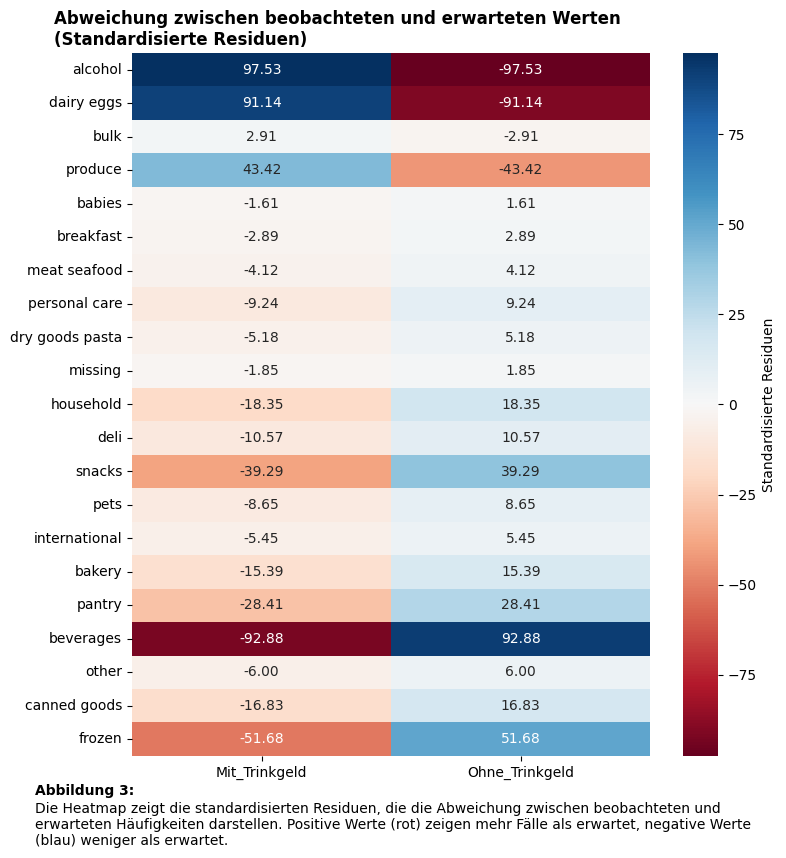


Interpretation der standardisierten Residuen:
╒═════════════════════════════╤═════════════════════════════════════╕
│ Werte                       │ Bedeutung                           │
╞═════════════════════════════╪═════════════════════════════════════╡
│ Stark negative Werte (< -2) │ Deutlich weniger Fälle als erwartet │
├─────────────────────────────┼─────────────────────────────────────┤
│ Werte nahe 0 (-2 bis 2)     │ Etwa so viele Fälle wie erwartet    │
├─────────────────────────────┼─────────────────────────────────────┤
│ Stark positive Werte (> 2)  │ Deutlich mehr Fälle als erwartet    │
╘═════════════════════════════╧═════════════════════════════════════╛


In [ ]:
# plot code

observed = contingency_table[['Mit_Trinkgeld', 'Ohne_Trinkgeld']].values

_, _, _, expected = chi2_contingency(observed)

# Korrigierte standardisierte Residuen berechnen
# Formel: (O - E) / sqrt(E * (1 - row_total/grand_total) * (1 - col_total/grand_total))
row_totals = observed.sum(axis=1)
col_totals = observed.sum(axis=0)
grand_total = observed.sum()

corrected_residuals = np.zeros_like(observed, dtype=float)
for i in range(observed.shape[0]):
    for j in range(observed.shape[1]):
        E = expected[i, j]
        O = observed[i, j]
        correction = np.sqrt((1 - row_totals[i]/grand_total) * 
                           (1 - col_totals[j]/grand_total))
        corrected_residuals[i, j] = (O - E) / (np.sqrt(E) * correction)

residuals_df = pd.DataFrame(
    corrected_residuals,
    index=departments,
    columns=['Mit_Trinkgeld', 'Ohne_Trinkgeld']
)

residuals_df = residuals_df.reindex(departments_sorted[::-1])

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(residuals_df, 
            annot=True,
            cmap='RdBu',
            center=0,
            fmt='.2f',
            cbar_kws={'label': 'Standardisierte Residuen'},
            ax=ax)

ax.set_title('Abweichung zwischen beobachteten und erwarteten Werten\n(Standardisierte Residuen)', 
             loc='left',
             weight='bold',
             x=-0.15)

description = 'Die Heatmap zeigt die standardisierten Residuen, die die Abweichung zwischen beobachteten und erwarteten Häufigkeiten darstellen. Positive Werte (rot) zeigen mehr Fälle als erwartet, negative Werte (blau) weniger als erwartet.'
fig.text(0.05, 0, 'Abbildung 3:', weight='bold', ha='left')
fig.text(0.05, -0.06, description, wrap=True)

plt.tight_layout()
plt.show()

print("\nInterpretation der standardisierten Residuen:")
interpretation_table = [
    ["Stark negative Werte (< -2)", "Deutlich weniger Fälle als erwartet"],
    ["Werte nahe 0 (-2 bis 2)", "Etwa so viele Fälle wie erwartet"],
    ["Stark positive Werte (> 2)", "Deutlich mehr Fälle als erwartet"]
]
print(tabulate(interpretation_table, headers=["Werte", "Bedeutung"], 
              tablefmt="fancy_grid"))

In [323]:
# Query: Bestellungen mit und ohne Trinkgeld pro Abteilung, aber nur für Bestellungen die Produkte aus genau einer Abteilung enthalten
orders_with_single_department = session.query(
    Order.order_id,
    func.count(distinct(Product.department_id)).label('dept_count')
).join(Einkaufskorb, Einkaufskorb.order_id == Order.order_id)\
 .join(Product, Product.product_id == Einkaufskorb.product_id)\
 .group_by(Order.order_id)\
 .having(func.count(distinct(Product.department_id)) == 1)\
 .subquery()

orders_by_department_with_tips = session.query(
    Department.department_name,
    func.sum(case((Order.tips == True, 1), else_=0)).label('orders_with_tips'),
    func.sum(case((Order.tips == False, 1), else_=0)).label('orders_without_tips')
).join(Product, Product.department_id == Department.department_id)\
 .join(Einkaufskorb, Einkaufskorb.product_id == Product.product_id)\
 .join(Order, Einkaufskorb.order_id == Order.order_id)\
 .join(orders_with_single_department, orders_with_single_department.c.order_id == Order.order_id)\
 .group_by(Department.department_name).all()

departments = [department for department, _, _ in orders_by_department_with_tips]
orders_with_tips = [orders_with_tips for _, orders_with_tips, _ in orders_by_department_with_tips]
orders_without_tips = [orders_without_tips for _, _, orders_without_tips in orders_by_department_with_tips]

### 📊 Analyse von Single-Department-Bestellungen

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Fokussierte Departmentanalyse</h4>
    <p style="margin-bottom: 15px; line-height: 1.6;">
        Nach der Analyse aller Bestellungen betrachten wir nun spezifisch die Bestellungen, die ausschließlich Produkte 
        aus einer einzelnen Produktabteilung enthalten. Dies ermöglicht eine präzisere Untersuchung des 
        Trinkgeldverhaltens ohne Überschneidungseffekte.
    </p>
    <div style="margin-top: 15px;">
        <strong>📌 Besonderheiten der Analyse:</strong>
        <ul>
            <li>Nur Bestellungen mit Produkten aus genau einer Abteilung</li>
            <li>Keine Überschneidungen zwischen Abteilungen</li>
            <li>Reinere Darstellung des abteilungsspezifischen Trinkgeldverhaltens</li>
        </ul>
    </div>
    <div style="margin-top: 15px;">
        <strong>📊 Darstellung:</strong>
        <ul style="">
            <li>Horizontale Balken zeigen absolute Anzahl der Bestellungen</li>
            <li>Grün: Bestellungen mit Trinkgeld</li>
            <li>Rot: Bestellungen ohne Trinkgeld</li>
            <li>Zahlen rechts: Verhältnis (Trinkgeld/Gesamt)</li>
        </ul>
    </div>
</div>

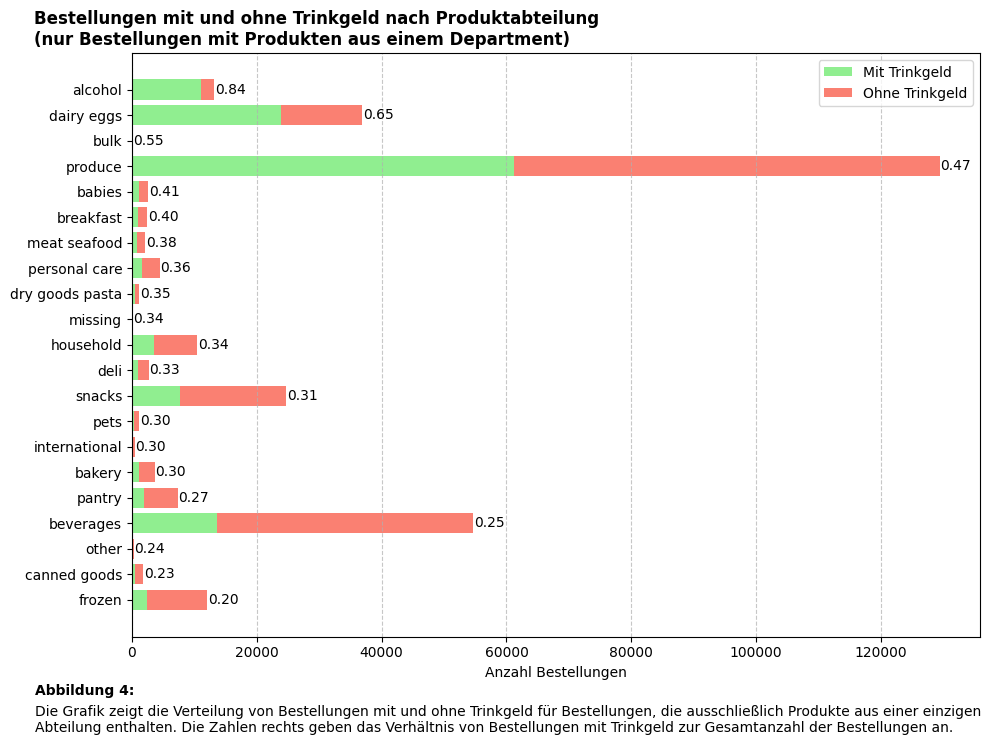

In [324]:
# plot code
# Quotient berechnen
ratios = [
    orders_with_tips[i] / (orders_with_tips[i] + orders_without_tips[i]) if (orders_with_tips[i] + orders_without_tips[i]) > 0 else 0
    for i in range(len(departments))
]

sorted_indices = np.argsort(ratios)

departments_sorted = [departments[i] for i in sorted_indices]
orders_with_tips_sorted = [orders_with_tips[i] for i in sorted_indices]
orders_without_tips_sorted = [orders_without_tips[i] for i in sorted_indices]
ratios_sorted = [ratios[i] for i in sorted_indices]

x = np.arange(len(departments_sorted))
fig, ax = plt.subplots(figsize=(10, 7))
plt.subplots_adjust(left=0.08)  # Anpassung für einheitliche Einrückung
bar_width = 0.5

ax.barh(x, orders_with_tips_sorted, color='lightgreen', label='Mit Trinkgeld')
ax.barh(x, orders_without_tips_sorted, left=orders_with_tips_sorted, color='salmon', label='Ohne Trinkgeld')

ax.set_xlabel('Anzahl Bestellungen')
ax.set_yticks(x)
ax.set_yticklabels(departments_sorted)
ax.set_title('Bestellungen mit und ohne Trinkgeld nach Produktabteilung\n(nur Bestellungen mit Produkten aus einem Department)', 
             loc='left', 
             weight='bold',
             x=-0.115)

for i, department in enumerate(departments_sorted):
    total_orders = orders_with_tips_sorted[i] + orders_without_tips_sorted[i]
    ratio = ratios_sorted[i]
    
    ax.text(
        orders_with_tips_sorted[i] + orders_without_tips_sorted[i] + 100,
        i,
        f'{ratio:.2f}',
        va='center',
        ha='left',
        fontsize=10,
        color='black'
    )

ax.legend(loc='upper right')
ax.ticklabel_format(style='plain', axis='x')
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

description = 'Die Grafik zeigt die Verteilung von Bestellungen mit und ohne Trinkgeld für Bestellungen, die ausschließlich Produkte aus einer einzigen Abteilung enthalten. Die Zahlen rechts geben das Verhältnis von Bestellungen mit Trinkgeld zur Gesamtanzahl der Bestellungen an.'
fig.text(0.04, 0, 'Abbildung 4:', weight='bold', ha='left')
fig.text(0.04, -0.05, description, wrap=True)

plt.tight_layout()
plt.show()

### 🔍 Zentrale Erkenntnisse der Single-Department-Analyse

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">⚡ Überraschungen</h4>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0">
        <strong>📈 Auffälliger Zuwachs</strong>
        <ul style="margin: 5px 0;">
            <li>Dairy Eggs</li>
        </ul>
    </div>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0">
        <strong>📉 Auffälliger Rückgang</strong>
        <ul style="margin: 5px 0;">
            <li>Frozen</li>
            <li>Beverages</li>
        </ul>
    </div>
</div>


In [11]:
# chi² code
contingency_table = pd.DataFrame({
    'Mit_Trinkgeld': orders_with_tips,
    'Ohne_Trinkgeld': orders_without_tips
}, index=departments)

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

test_results = [
    ["Chi-Quadrat Statistik", f"{chi2}"],
    ["p-Wert", f"{p_value}"],
    ["Freiheitsgrade", dof]
]

print("\nChi-Quadrat Testergebnisse:")
print(tabulate(test_results, headers=["Metrik", "Wert"], 
              tablefmt="fancy_grid", numalign="right"))

alpha = 0.05
print("\nInterpretation:")
if p_value < alpha:
    interpretation = [
        ["Ergebnis", "Statistisch signifikanter Zusammenhang"],
        ["Begründung", f"p-Wert ({p_value}) < Signifikanzniveau ({alpha})"],
        ["Schlussfolgerung", "Department und Trinkgeldvergabe sind abhängig"]
    ]
else:
    interpretation = [
        ["Ergebnis", "Kein statistisch signifikanter Zusammenhang"],
        ["Begründung", f"p-Wert ({p_value}) > Signifikanzniveau ({alpha})"],
        ["Schlussfolgerung", "Department und Trinkgeldvergabe sind unabhängig"]
    ]

print(tabulate(interpretation, headers=["", ""], 
              tablefmt="fancy_grid"))

contingency_table['Gesamt'] = contingency_table['Mit_Trinkgeld'] + contingency_table['Ohne_Trinkgeld']
contingency_table['Anteil_mit_Trinkgeld'] = (contingency_table['Mit_Trinkgeld'] / contingency_table['Gesamt']).round(3)

print("\nKontingenztabelle:")
print(tabulate(contingency_table, headers='keys', tablefmt="fancy_grid", 
              numalign="right", floatfmt=".3f"))


Chi-Quadrat Testergebnisse:
╒═══════════════════════╤═════════╕
│ Metrik                │    Wert │
╞═══════════════════════╪═════════╡
│ Chi-Quadrat Statistik │ 30670.2 │
├───────────────────────┼─────────┤
│ p-Wert                │       0 │
├───────────────────────┼─────────┤
│ Freiheitsgrade        │      20 │
╘═══════════════════════╧═════════╛

Interpretation:
╒══════════════════╤═══════════════════════════════════════════════╕
│                  │                                               │
╞══════════════════╪═══════════════════════════════════════════════╡
│ Ergebnis         │ Statistisch signifikanter Zusammenhang        │
├──────────────────┼───────────────────────────────────────────────┤
│ Begründung       │ p-Wert (0.0) < Signifikanzniveau (0.05)       │
├──────────────────┼───────────────────────────────────────────────┤
│ Schlussfolgerung │ Department und Trinkgeldvergabe sind abhängig │
╘══════════════════╧═══════════════════════════════════════════════╛

Kontinge

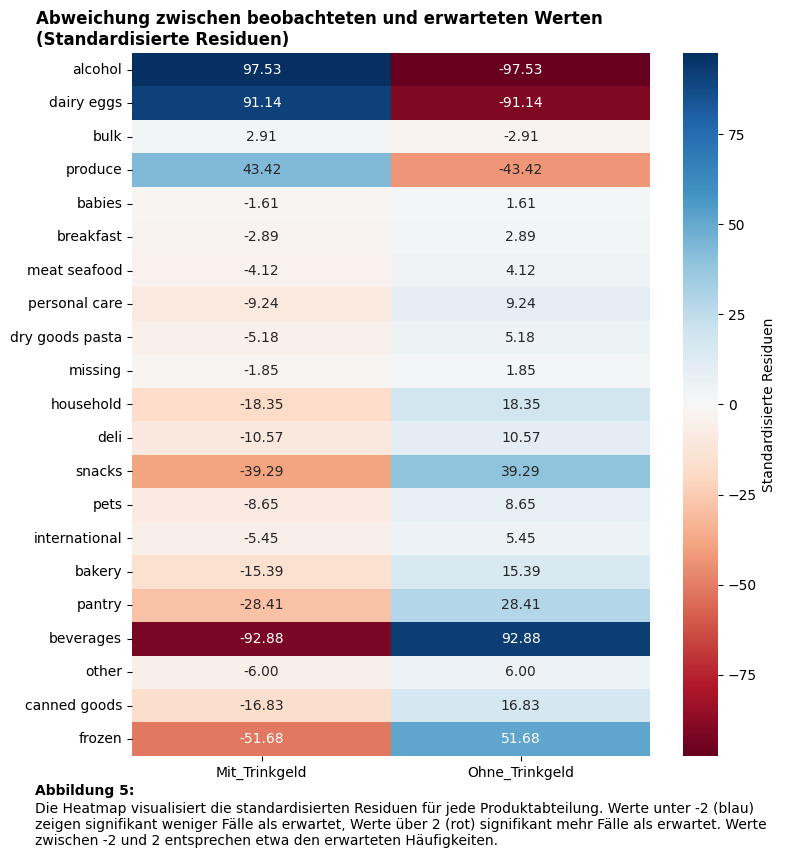


Interpretation der standardisierten Residuen:
╒═════════════════════════════╤═════════════════════════════════════╕
│ Werte                       │ Bedeutung                           │
╞═════════════════════════════╪═════════════════════════════════════╡
│ Stark negative Werte (< -2) │ Deutlich weniger Fälle als erwartet │
├─────────────────────────────┼─────────────────────────────────────┤
│ Werte nahe 0 (-2 bis 2)     │ Etwa so viele Fälle wie erwartet    │
├─────────────────────────────┼─────────────────────────────────────┤
│ Stark positive Werte (> 2)  │ Deutlich mehr Fälle als erwartet    │
╘═════════════════════════════╧═════════════════════════════════════╛


In [26]:
# code plot
observed = contingency_table[['Mit_Trinkgeld', 'Ohne_Trinkgeld']].values

_, _, _, expected = chi2_contingency(observed)

# Korrigierte standardisierte Residuen berechnen
# Formel: (O - E) / sqrt(E * (1 - row_total/grand_total) * (1 - col_total/grand_total))
row_totals = observed.sum(axis=1)
col_totals = observed.sum(axis=0)
grand_total = observed.sum()

corrected_residuals = np.zeros_like(observed, dtype=float)
for i in range(observed.shape[0]):
    for j in range(observed.shape[1]):
        E = expected[i, j]
        O = observed[i, j]
        correction = np.sqrt((1 - row_totals[i]/grand_total) * 
                           (1 - col_totals[j]/grand_total))
        corrected_residuals[i, j] = (O - E) / (np.sqrt(E) * correction)

residuals_df = pd.DataFrame(
    corrected_residuals,
    index=departments,
    columns=['Mit_Trinkgeld', 'Ohne_Trinkgeld']
)

residuals_df = residuals_df.reindex(departments_sorted[::-1])

fig, ax = plt.subplots(figsize=(8, 8))
plt.subplots_adjust(left=0.08)

sns.heatmap(residuals_df, 
            annot=True,
            cmap='RdBu',
            center=0,
            fmt='.2f',
            cbar_kws={'label': 'Standardisierte Residuen'},
            ax=ax)

ax.set_title('Abweichung zwischen beobachteten und erwarteten Werten\n(Standardisierte Residuen)', 
             loc='left',
             weight='bold',
             x=-0.185)

description = 'Die Heatmap visualisiert die standardisierten Residuen für jede Produktabteilung. Werte unter -2 (blau) zeigen signifikant weniger Fälle als erwartet, Werte über 2 (rot) signifikant mehr Fälle als erwartet. Werte zwischen -2 und 2 entsprechen etwa den erwarteten Häufigkeiten.'
fig.text(0.05, 0, 'Abbildung 5:', weight='bold', ha='left')
fig.text(0.05, -0.06, description, wrap=True)

plt.tight_layout()
plt.show()

print("\nInterpretation der standardisierten Residuen:")
interpretation_table = [
    ["Stark negative Werte (< -2)", "Deutlich weniger Fälle als erwartet"],
    ["Werte nahe 0 (-2 bis 2)", "Etwa so viele Fälle wie erwartet"],
    ["Stark positive Werte (> 2)", "Deutlich mehr Fälle als erwartet"]
]
print(tabulate(interpretation_table, headers=["Werte", "Bedeutung"], 
              tablefmt="fancy_grid"))

In [328]:
# Anzahl der Gesamtbestellungen und Bestellungen mit Trinkgeld pro Gang (Aisle)
aisles_stats = session.query(
    Aisle.aisle_name,
    func.count(Order.order_id).label('total_orders'),
    func.sum(case((Order.tips == True, 1), else_=0)).label('orders_with_tips')
).join(Product, Product.aisle_id == Aisle.aisle_id) \
 .join(Einkaufskorb, Einkaufskorb.product_id == Product.product_id) \
 .join(Order, Einkaufskorb.order_id == Order.order_id) \
 .group_by(Aisle.aisle_name) \
 .all()


In [329]:
# utils code
aisles_df = pd.DataFrame(aisles_stats, columns=['aisle_name', 'total_orders', 'orders_with_tips'])
aisles_df['orders_without_tips'] = aisles_df['total_orders'] - aisles_df['orders_with_tips']
aisles_df['tip_ratio'] = aisles_df['orders_with_tips'] / aisles_df['total_orders']

aisles_top_10 = aisles_df.nlargest(10, 'tip_ratio').iloc[::-1]  # Top 10 nach Quote, Reihenfolge umkehren
aisles_flop_10 = aisles_df.nsmallest(10, 'tip_ratio')

def plot_aisles(aisles_data, title, ax):
    x = np.arange(len(aisles_data))

    ax.barh(x, aisles_data['orders_with_tips'], color='lightgreen', label='Mit Trinkgeld')
    ax.barh(x, aisles_data['orders_without_tips'], left=aisles_data['orders_with_tips'], color='salmon', label='Ohne Trinkgeld')

    ax.set_xlabel('Anzahl Bestellungen')
    ax.set_yticks(x)
    ax.set_yticklabels(aisles_data['aisle_name'])
    ax.set_title(title, loc='left', weight='bold')

    for tick in ax.get_xticks():
        ax.axvline(x=tick, color='grey', linestyle='--', linewidth=0.5)

    for i, aisle in enumerate(aisles_data['aisle_name']):
        ratio = aisles_data['tip_ratio'].iloc[i]
        total_orders = aisles_data['total_orders'].iloc[i]
        ax.text(
            aisles_data['orders_with_tips'].iloc[i] + aisles_data['orders_without_tips'].iloc[i] + 130,  
            i,  
            f'{ratio:.2f}',  
            va='center',  
            ha='left',  
            fontsize=10,
            color='black'
        )

    ax.legend(loc='upper right')


### 📊 Detailanalyse der Produktkategorien (Aisles)

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Top & Flop Analyse</h4>
    <p style="margin-bottom: 15px; line-height: 1.6;">
        Nach der Untersuchung der übergeordneten Departments zoomen wir nun tiefer in die einzelnen Produktkategorien 
        (Aisles) hinein. Diese detailliertere Betrachtung ermöglicht es uns, spezifischere Muster im Trinkgeldverhalten 
        zu identifizieren.
    </p>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📈 Visualisierungsdetails:</strong>
        <ul style="margin: 10px 0;">
            <li><strong>Linker Plot:</strong> Top 10 Aisles mit höchstem Trinkgeld-Verhältnis</li>
            <li><strong>Rechter Plot:</strong> Flop 10 Aisles mit niedrigstem Trinkgeld-Verhältnis</li>
            <li>Grüne Balken: Bestellungen mit Trinkgeld</li>
            <li>Rote Balken: Bestellungen ohne Trinkgeld</li>
            <li>Zahlen rechts: Verhältnis (Trinkgeld/Gesamt)</li>
        </ul>
    </div>
    <div style="margin-top: 15px;">
        <strong>🎯 Analyseziel:</strong>
        <p style="margin: 10px 0;">
            Identifikation von spezifischen Produktkategorien, die besonders stark mit dem Trinkgeldverhalten 
            korrelieren, um gezieltere Erkenntnisse für Marketing- und Service-Strategien zu gewinnen.
        </p>
    </div>
</div>

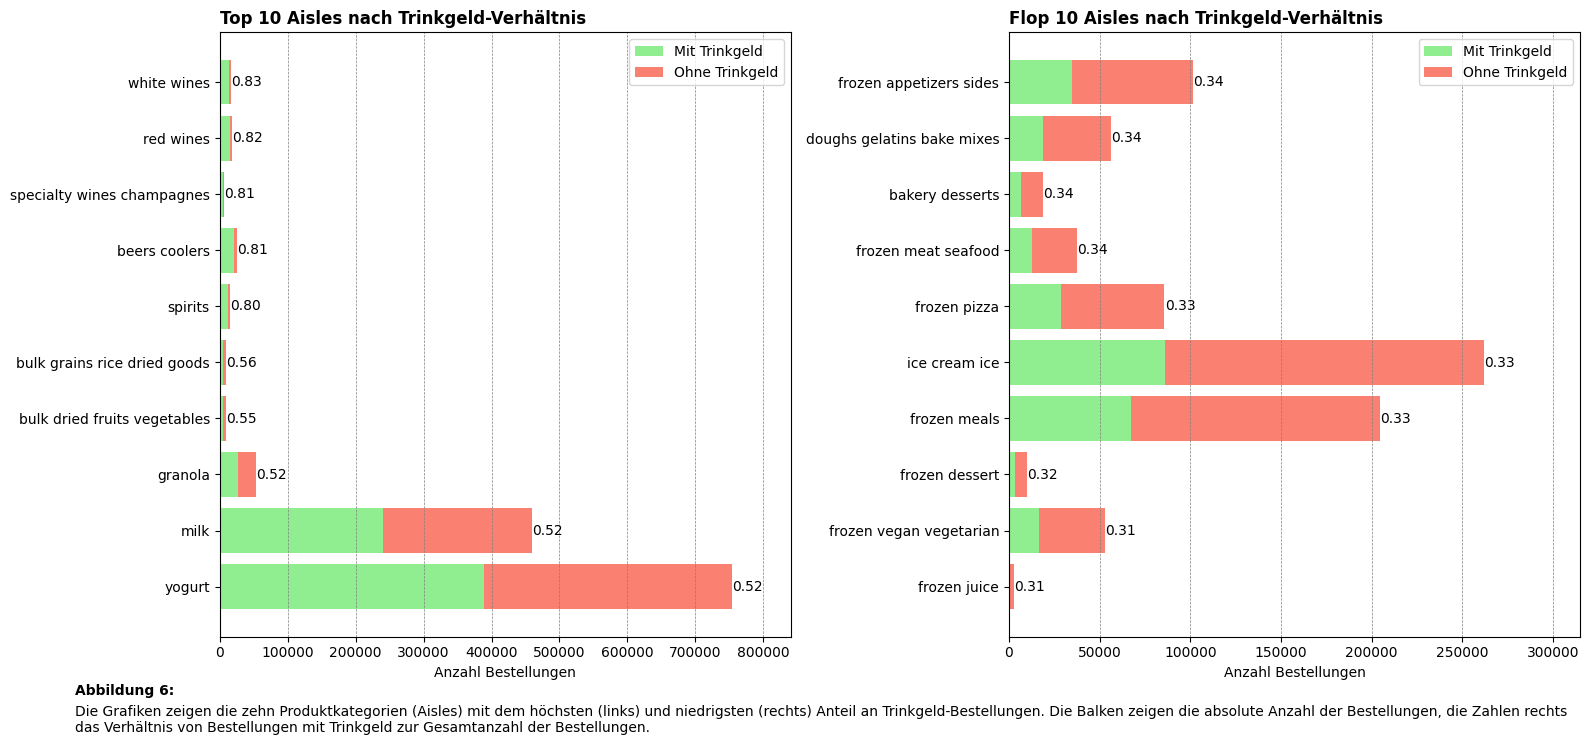

In [330]:
# plot code
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
plt.subplots_adjust(left=0.08)

plot_aisles(aisles_top_10, 'Top 10 Aisles nach Trinkgeld-Verhältnis', ax1)

plot_aisles(aisles_flop_10, 'Flop 10 Aisles nach Trinkgeld-Verhältnis', ax2)

description = 'Die Grafiken zeigen die zehn Produktkategorien (Aisles) mit dem höchsten (links) und niedrigsten (rechts) Anteil an Trinkgeld-Bestellungen. Die Balken zeigen die absolute Anzahl der Bestellungen, die Zahlen rechts das Verhältnis von Bestellungen mit Trinkgeld zur Gesamtanzahl der Bestellungen.'
fig.text(0.05, 0, 'Abbildung 6:', weight='bold', ha='left')
fig.text(0.05, -0.05, description, wrap=True)

plt.tight_layout()
plt.show()


<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Bestätigung übergeordneter Muster</h4>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>🍷 Alkoholische Produkte in den Top 10</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Die detaillierte Analyse der Aisles bestätigt den bereits auf Department-Ebene beobachteten Trend: 
            Alkoholische Produkte sind überproportional häufig in Bestellungen mit Trinkgeld vertreten. Dies zeigt sich durch:
        </p>
        <ul style="margin: 5px 0;">
            <li>Mehrere alkoholbezogene Kategorien in den Top 10</li>
            <li>Konsistenz mit der hohen Trinkgeldquote des Alcohol-Departments</li>
            <li>Möglicherweise höhere Serviceerwartung bei diesen Produkten</li>
        </ul>
    </div>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>❄️ Tiefkühlprodukte in den Flop 10</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Auch am unteren Ende der Skala bestätigen sich die Department-Level-Erkenntnisse:
            Tiefkühlprodukte weisen durchgängig niedrigere Trinkgeldquoten auf. Dies spiegelt sich wider in:
        </p>
        <ul style="margin: 5px 0;">
            <li>Mehreren Tiefkühl-Kategorien unter den Flop 10</li>
            <li>Übereinstimmung mit der niedrigen Quote des Frozen-Departments</li>
            <li>Konsistentes Muster über verschiedene Tiefkühl-Produktkategorien hinweg</li>
        </ul>
    </div>
    <div style="margin-top: 15px; padding: 15px; border-radius: 5px;">
        <strong>📊 Fazit:</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Die Aisle-Level-Analyse bestätigt und verfeinert die Erkenntnisse der Department-Analyse. 
            Dies unterstreicht die Robustheit der beobachteten Muster im Trinkgeldverhalten und 
            ermöglicht eine noch gezieltere Ansprache verschiedener Produktsegmente.
        </p>
    </div>
</div>

In [326]:
# Statistik über Produkte die mindestens 500 mal bestellt wurden: Gesamtbestellungen und Bestellungen mit Trinkgeld
products_stats = session.query(
    Product.product_name,
    func.count(Order.order_id).label('total_orders'),
    func.sum(case((Order.tips == True, 1), else_=0)).label('orders_with_tips')
).join(Einkaufskorb, Einkaufskorb.product_id == Product.product_id) \
 .join(Order, Einkaufskorb.order_id == Order.order_id) \
 .group_by(Product.product_name) \
 .having(func.count(Order.order_id) >= 500).all()

products_df = pd.DataFrame(products_stats, columns=['product_name', 'total_orders', 'orders_with_tips'])
products_df['orders_without_tips'] = products_df['total_orders'] - products_df['orders_with_tips']
products_df['tip_ratio'] = products_df['orders_with_tips'] / products_df['total_orders']

products_top_10 = products_df.nlargest(10, 'tip_ratio').iloc[::-1]  # Top 10 nach Quote, Reihenfolge umkehren
products_flop_10 = products_df.nsmallest(10, 'tip_ratio')

def plot_products(products_data, title, ax):
    x = np.arange(len(products_data))

    ax.barh(x, products_data['orders_with_tips'], color='lightgreen', label='Mit Trinkgeld')
    ax.barh(x, products_data['orders_without_tips'], left=products_data['orders_with_tips'], color='salmon', label='Ohne Trinkgeld')

    ax.set_xlabel('Anzahl Bestellungen')
    ax.set_yticks(x)
    ax.set_yticklabels(products_data['product_name'])
    ax.set_title(title, loc='left', weight='bold')

    for tick in ax.get_xticks():
        ax.axvline(x=tick, color='grey', linestyle='--', linewidth=0.5)

    for i, product in enumerate(products_data['product_name']):
        ratio = products_data['tip_ratio'].iloc[i]
        total_orders = products_data['total_orders'].iloc[i]
        ax.text(
            products_data['orders_with_tips'].iloc[i] + products_data['orders_without_tips'].iloc[i] + 10, 
            i,  
            f'{ratio:.2f}',  
            va='center',  
            ha='left',  
            fontsize=10,
            color='black'
        )

    ax.legend(loc='upper right')


### 📊 Analyse auf Produktebene

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Detailanalyse einzelner Produkte</h4>
    <p style="margin-bottom: 15px; line-height: 1.6;">
        Nach der Analyse der Departments und Aisles gehen wir nun auf die granularste Ebene: 
        die einzelnen Produkte. Diese Mikroanalyse ermöglicht es uns, sehr spezifische Muster 
        im Trinkgeldverhalten zu identifizieren.
    </p>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📈 Visualisierungsaufbau:</strong>
        <ul style="margin: 10px 0;">
            <li><strong>Linker Plot:</strong> Die 10 Produkte mit der höchsten Trinkgeldquote</li>
            <li><strong>Rechter Plot:</strong> Die 10 Produkte mit der niedrigsten Trinkgeldquote</li>
            <li>Absolute Anzahl der Bestellungen (Balkenlänge)</li>
            <li>Verhältnis Trinkgeld/Gesamt (Zahlen rechts)</li>
        </ul>
    </div>
    <div style="margin-top: 15px;">
        <strong>🎯 Analyseziele:</strong>
        <ul style="margin: 10px 0;">
            <li>Identifikation von Produkten mit außergewöhnlichem Trinkgeldverhalten</li>
            <li>Verständnis produktspezifischer Kundenentscheidungen</li>
            <li>Ableitung von Handlungsempfehlungen auf Produktebene</li>
        </ul>
    </div>
    <div style="margin-top: 15px; padding: 15px; border-radius: 5px;">
        <strong>💡 Besonderheit:</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Diese Analyse auf Produktebene ermöglicht die präziseste Sicht auf das Trinkgeldverhalten 
            und kann wichtige Einblicke für Produktplatzierung, Marketing und Serviceoptimierung liefern.
        </p>
    </div>
</div>

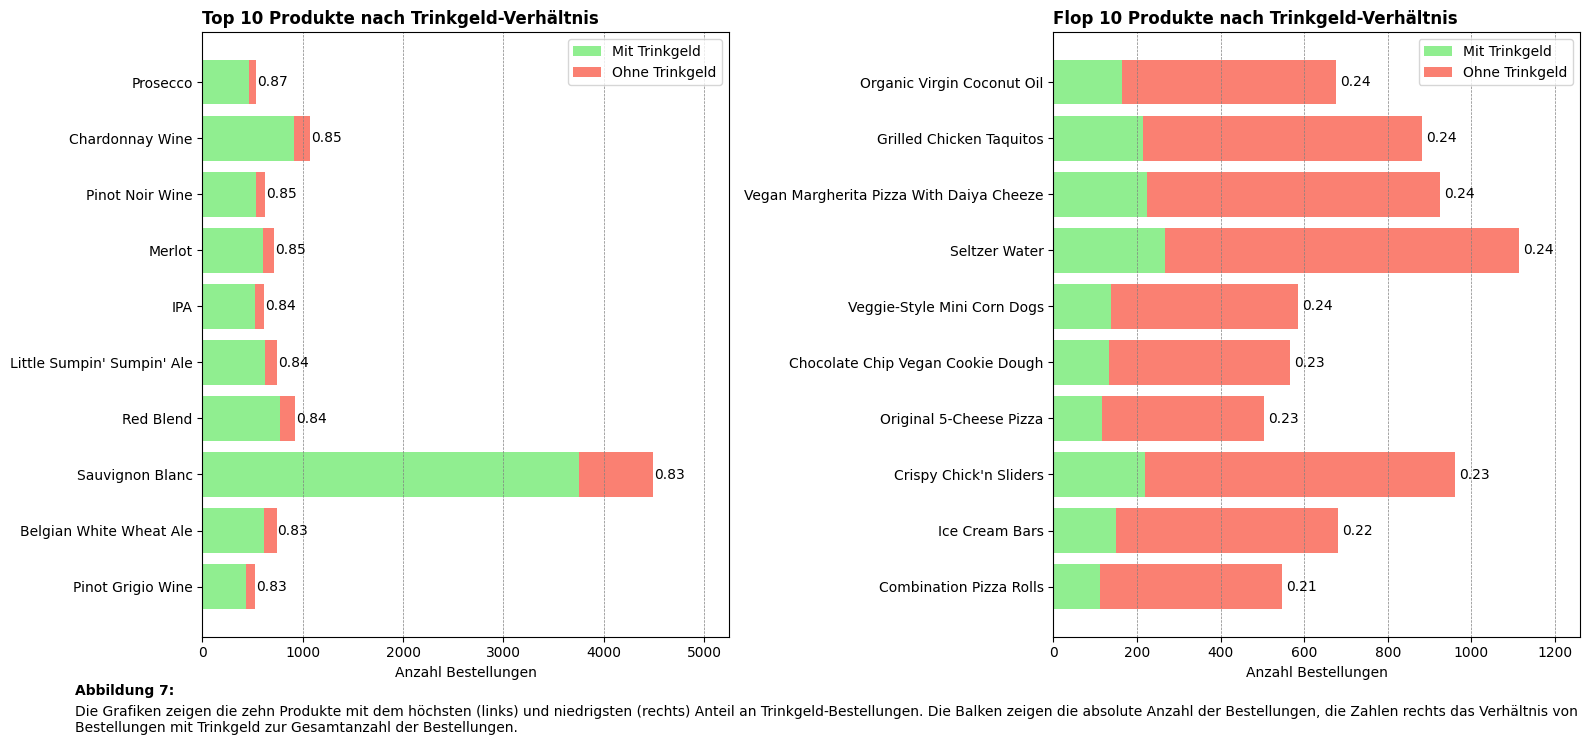

In [332]:
# plot code
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
plt.subplots_adjust(left=0.08)

plot_products(products_top_10, 'Top 10 Produkte nach Trinkgeld-Verhältnis', ax1)

plot_products(products_flop_10, 'Flop 10 Produkte nach Trinkgeld-Verhältnis', ax2)

description = 'Die Grafiken zeigen die zehn Produkte mit dem höchsten (links) und niedrigsten (rechts) Anteil an Trinkgeld-Bestellungen. Die Balken zeigen die absolute Anzahl der Bestellungen, die Zahlen rechts das Verhältnis von Bestellungen mit Trinkgeld zur Gesamtanzahl der Bestellungen.'
fig.text(0.05, 0, 'Abbildung 7:', weight='bold', ha='left')
fig.text(0.05, -0.05, description, wrap=True)

plt.tight_layout()
plt.show()


### 💡 Erkenntnisse der Produktanalyse

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Konsistente Muster über alle Analyseebenen</h4> 
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>🍷 Top 10 Produkte: Dominanz alkoholischer Getränke</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Die Analyse auf Produktebene bestätigt eindrucksvoll die bereits beobachteten Trends:
        </p>
        <ul style="margin: 5px 0;">
            <li>Starke Präsenz alkoholischer Getränke in den Top 10</li>
            <li>Konsistenz mit den Ergebnissen der Aisle-Analyse</li>
            <li>Bestätigung des Department-Level-Trends für alkoholische Produkte</li>
        </ul>
    </div>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>❄️ Flop 10 Produkte: Tiefkühlprodukte dominieren</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Auch am unteren Ende der Skala setzen sich die bereits erkannten Muster fort:
        </p>
        <ul style="margin: 5px 0;">
            <li>Häufiges Auftreten von Tiefkühlprodukten unter den Flop 10</li>
            <li>Spiegelung der Erkenntnisse aus der Aisle-Analyse</li>
            <li>Weitere Bestätigung der niedrigen Trinkgeldquote im Frozen-Department</li>
        </ul>
    </div>
    <div style="margin-top: 15px; padding: 15px; border-radius: 5px;">
        <strong>🎯 Fazit:</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Die Analyse auf Produktebene verstärkt die Erkenntnisse der vorherigen Untersuchungen und zeigt 
            eine bemerkenswerte Konsistenz über alle Analyseebenen hinweg - von Department über Aisles bis hin 
            zu einzelnen Produkten. Diese durchgängigen Muster unterstreichen die Robustheit unserer Erkenntnisse 
            zum Trinkgeldverhalten.
        </p>
    </div>
</div>

### 🕒 Temporale Analyse des Trinkgeldverhaltens nach Produktkategorien Alkohol und Frozen

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Zeitliche Muster auf Stunden- und Tagesebene</h4>
    <p style="margin-bottom: 15px; line-height: 1.6;">
        Nach der Identifikation der Produktkategorien mit besonders hohen (Alcohol) und niedrigen (Frozen) 
        Trinkgeldquoten, untersuchen wir nun deren zeitliche Dimension. Diese mehrstufige temporale Analyse 
        betrachtet sowohl Tages- als auch Stundenverläufe, um ein umfassendes Bild der zeitlichen Dynamik 
        zu erhalten.
    </p>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>⏰ Zeitliche Dimensionen:</strong>
        <ul style="margin: 10px 0;">
            <li><strong>Stundenanalyse:</strong> Verlauf über 24 Stunden (0-23 Uhr)</li>
            <li><strong>Tagesanalyse:</strong> Verteilung über die Wochentage</li>
        </ul>
    </div>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📊 Analysefokus:</strong>
        <ul style="margin: 10px 0;">
            <li>Vergleich von absoluten Bestellzahlen und Trinkgeldquoten</li>
            <li>Separate Betrachtung der Extremkategorien:
                <ul>
                    <li>🍷 Alcohol (höchste Trinkgeldquote)</li>
                    <li>❄️ Frozen (niedrigste Trinkgeldquote)</li>
                </ul>
            </li>
        </ul>
    </div>
    <div style="margin-top: 15px;">
        <strong>🎯 Erkenntnisziele:</strong>
        <ul style="margin: 10px 0;">
            <li>Identifikation von Tageszeit- und Wochentagsmustern</li>
            <li>Verständnis kategorienspezifischer Unterschiede im Zeitverlauf</li>
            <li>Erkennung von Stoßzeiten und ruhigen Perioden</li>
            <li>Ableitung von zeit- und kategorieabhängigen Handlungsempfehlungen</li>
        </ul>
    </div>
</div>


<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Alkoholbestellungen im Tagesverlauf</h4>
    <p style="margin-bottom: 15px; line-height: 1.6;">
        Nach der Identifikation von Alkoholprodukten als Kategorie mit der höchsten Trinkgeldquote 
        untersuchen wir nun das zeitliche Muster dieser Bestellungen. Diese Analyse soll Aufschluss 
        darüber geben, ob und wie sich das Trinkgeldverhalten bei Alkoholbestellungen im Tagesverlauf verändert.
    </p>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📊 Visualisierungsdetails:</strong>
        <ul style="margin: 10px 0;">
            <li><strong>Linker Plot:</strong> Absolute Zahlen der Bestellungen nach Stunden</li>
            <li><strong>Rechter Plot:</strong> Verlauf der Trinkgeldquote über den Tag</li>
            <li>24-Stunden-Analyse (0-23 Uhr)</li>
            <li>Berücksichtigung aller Bestellungen mit alkoholischen Produkten</li>
        </ul>
    </div>
    <div style="margin-top: 15px;">
        <strong>🎯 Analyseziele:</strong>
        <ul style="margin: 10px 0;">
            <li>Identifikation von Stoßzeiten für Alkoholbestellungen</li>
            <li>Erkennung von Mustern im Trinkgeldverhalten</li>
            <li>Verständnis des zeitlichen Einflusses auf das Kundenverhalten</li>
            <li>Ableitung möglicher operativer Empfehlungen</li>
        </ul>
    </div>
</div>

In [44]:
# Bestellungen von alkoholischen Produkten nach Tageszeit: Gesamtbestellungen und Bestellungen mit Trinkgeld pro Stunde
alcohol_orders_stats = session.query(
    Order.hour_of_day,
    func.count(Order.order_id).label('total_orders'),
    func.sum(case((Order.tips == True, 1), else_=0)).label('orders_with_tips')
).join(Einkaufskorb, Einkaufskorb.order_id == Order.order_id) \
 .join(Product, Product.product_id == Einkaufskorb.product_id) \
 .join(Department, Department.department_id == Product.department_id) \
 .filter(Department.department_name.ilike('%alcohol%')) \
 .group_by(Order.hour_of_day) \
 .all()


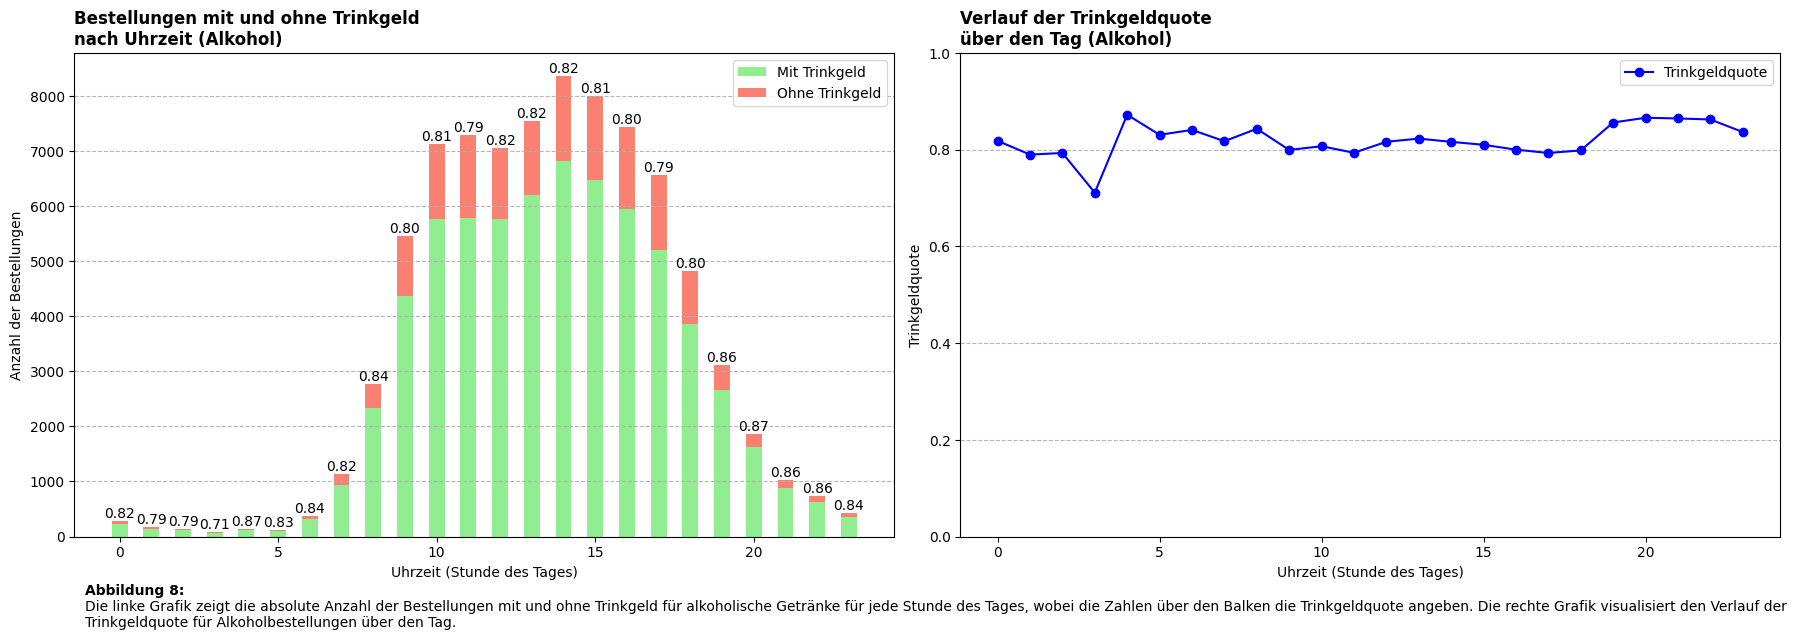

In [248]:
# plot code
alcohol_orders_df = pd.DataFrame(alcohol_orders_stats, columns=['hour_of_day', 'total_orders', 'orders_with_tips'])
alcohol_orders_df['orders_without_tips'] = alcohol_orders_df['total_orders'] - alcohol_orders_df['orders_with_tips']
alcohol_orders_df['tip_ratio'] = alcohol_orders_df['orders_with_tips'] / alcohol_orders_df['total_orders']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
plt.subplots_adjust(left=0.08)

bar_with_tips = ax1.bar(alcohol_orders_df['hour_of_day'], alcohol_orders_df['orders_with_tips'], 
                        bar_width, label='Mit Trinkgeld', color='lightgreen')
bar_without_tips = ax1.bar(alcohol_orders_df['hour_of_day'], alcohol_orders_df['orders_without_tips'], 
                          bar_width, bottom=alcohol_orders_df['orders_with_tips'], 
                          label='Ohne Trinkgeld', color='salmon')

for i, rect in enumerate(bar_with_tips):
    height = rect.get_height() + bar_without_tips[i].get_height()
    ratio = alcohol_orders_df['tip_ratio'].iloc[i]
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 2, 
             f'{ratio:.2f}', ha='center', va='bottom')

ax1.set_title('Bestellungen mit und ohne Trinkgeld\nnach Uhrzeit (Alkohol)', 
              loc='left', weight='bold')
ax1.set_xlabel('Uhrzeit (Stunde des Tages)')
ax1.set_ylabel('Anzahl der Bestellungen')
ax1.legend()
ax1.grid(True, axis='y', linestyle='--', alpha=0.9)

ax2.plot(alcohol_orders_df['hour_of_day'], alcohol_orders_df['tip_ratio'], 
         marker='o', color='blue', label='Trinkgeldquote')
ax2.set_title('Verlauf der Trinkgeldquote\nüber den Tag (Alkohol)', 
              loc='left', weight='bold')
ax2.set_xlabel('Uhrzeit (Stunde des Tages)')
ax2.set_ylabel('Trinkgeldquote')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(True, axis='y', linestyle='--', alpha=0.9)

description = 'Die linke Grafik zeigt die absolute Anzahl der Bestellungen mit und ohne Trinkgeld für alkoholische Getränke für jede Stunde des Tages, wobei die Zahlen über den Balken die Trinkgeldquote angeben. Die rechte Grafik visualisiert den Verlauf der Trinkgeldquote für Alkoholbestellungen über den Tag.'
fig.text(0.05, 0, 'Abbildung 8:', weight='bold', ha='left')
fig.text(0.05, -0.05, description, wrap=True)

plt.tight_layout()
plt.show()

### 💡 Erkenntnisse der Stundenanalyse: Alkoholbestellungen

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Zeitliche Muster bei Alkoholbestellungen</h4>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📊 Bestellvolumen im Tagesverlauf</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Die Analyse zeigt einen deutlichen Tagesrhythmus bei Alkoholbestellungen:
        </p>
        <ul style="margin: 5px 0;">
            <li>Deutlich höheres Bestellaufkommen während der Tagesstunden</li>
            <li>Signifikanter Rückgang der Bestellungen in den Nachtstunden</li>
            <li>Erkennbares Muster typischen Konsumverhaltens</li>
        </ul>
    </div>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📈 Stabilität der Trinkgeldquote</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Bemerkenswerterweise zeigt die Trinkgeldquote eine hohe Konstanz:
        </p>
        <ul style="margin: 5px 0;">
            <li>Kaum Schwankungen im Tagesverlauf</li>
            <li>Stabile Trinkgeldbereitschaft unabhängig von der Tageszeit</li>
            <li>Keine erkennbare Korrelation zwischen Bestellvolumen und Trinkgeldquote</li>
        </ul>
    </div>
    <div style="margin-top: 15px; padding: 15px; border-radius: 5px;">
        <strong>🎯 Fazit:</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Während das Bestellvolumen deutlichen tageszeitlichen Schwankungen unterliegt, 
            bleibt die Bereitschaft Trinkgeld zu geben bei Alkoholbestellungen konstant hoch. 
            Dies deutet darauf hin, dass die Trinkgeldvergabe bei Alkoholbestellungen weniger von 
            der Tageszeit als vielmehr von der Produktkategorie selbst beeinflusst wird.
        </p>
    </div>
</div>


In [ ]:
# Vergleich von Gesamtbestellungen und Alkoholbestellungen pro Stunde des Tages
total_orders = session.query(
    Order.hour_of_day,
    func.count(distinct(Order.order_id)).label('total_orders')
).group_by(Order.hour_of_day).subquery()

alcohol_orders = session.query(
    Order.hour_of_day,
    func.count(distinct(Order.order_id)).label('alcohol_orders')
).join(Einkaufskorb, Einkaufskorb.order_id == Order.order_id) \
 .join(Product, Product.product_id == Einkaufskorb.product_id) \
 .join(Department, Department.department_id == Product.department_id) \
 .filter(Department.department_name.ilike('%alcohol%')) \
 .group_by(Order.hour_of_day).subquery()

combined_stats = session.query(
    total_orders.c.hour_of_day,
    total_orders.c.total_orders,
    func.coalesce(alcohol_orders.c.alcohol_orders, 0).label('alcohol_orders')
).outerjoin(
    alcohol_orders,
    total_orders.c.hour_of_day == alcohol_orders.c.hour_of_day
).order_by(total_orders.c.hour_of_day).all()

combined_df = pd.DataFrame(combined_stats, columns=['hour_of_day', 'total_orders', 'alcohol_orders'])
combined_df['alcohol_ratio'] = combined_df['alcohol_orders'] / combined_df['total_orders']


### 📊 Einschub: Alkoholanteil im Bestellungsmix

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Relativer Anteil von Alkoholbestellungen</h4>
    <p style="margin-bottom: 15px; line-height: 1.6;">
        Um ein vollständigeres Bild der Alkoholbestellungen zu erhalten, betrachten wir ergänzend den relativen 
        Anteil alkoholhaltiger Bestellungen am gesamten Bestellvolumen im Tagesverlauf. Diese Analyse hilft uns 
        zu verstehen, ob Alkoholbestellungen zu bestimmten Tageszeiten überproportional vertreten sind.
    </p>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📈 Analysefokus:</strong>
        <ul style="margin: 10px 0;">
            <li>Verhältnis: Bestellungen mit Alkohol / Gesamtbestellungen</li>
            <li>Stundenweise Betrachtung über 24 Stunden</li>
            <li>Prozentuale Darstellung der Anteile</li>
        </ul>
    </div>
</div>

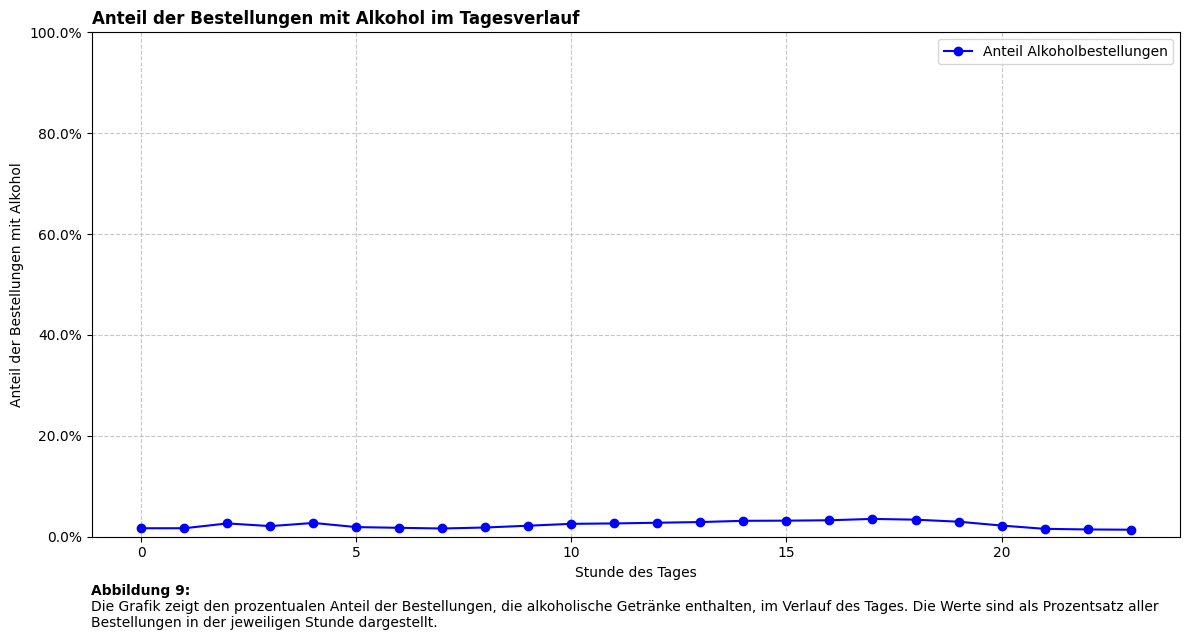

In [ ]:
# plot code
fig, ax = plt.subplots(figsize=(12, 6))
plt.subplots_adjust(left=0.08)

ax.plot(combined_df['hour_of_day'], combined_df['alcohol_ratio'], 
        marker='o', color='blue', label='Anteil Alkoholbestellungen')

ax.set_title('Anteil der Bestellungen mit Alkohol im Tagesverlauf', 
             loc='left', weight='bold')
ax.set_xlabel('Stunde des Tages')
ax.set_ylabel('Anteil der Bestellungen mit Alkohol')
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
ax.set_ylim(0, 1)

description = 'Die Grafik zeigt den prozentualen Anteil der Bestellungen, die alkoholische Getränke enthalten, im Verlauf des Tages. Die Werte sind als Prozentsatz aller Bestellungen in der jeweiligen Stunde dargestellt.'
fig.text(0.08, 0, 'Abbildung 9:', weight='bold', ha='left')
fig.text(0.08, -0.05, description, wrap=True)

plt.tight_layout()
plt.show()

### 💡 Erkenntnisse zum Bestellmix

<div style="padding: 20px; border-radius: 8px; border-left: 5px solid #3498db; margin: 10px 0;">
    <h4 style="color: #3498db; margin-top: 0;">🔍 Konstanz im Bestellverhalten</h4>
    <div style="padding: 15px; border-radius: 5px; margin: 10px 0;">
        <strong>📊 Analyse des relativen Anteils</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Die Untersuchung des relativen Anteils von Alkoholbestellungen zeigt ein bemerkenswertes Muster:
        </p>
        <ul style="margin: 5px 0;">
            <li>Weitgehend konstanter Anteil über den gesamten Tagesverlauf</li>
            <li>Nur minimale Schwankungen ohne erkennbare zeitliche Systematik</li>
            <li>Keine signifikanten Ausreißer zu bestimmten Tageszeiten</li>
        </ul>
    </div>
    <div style="margin-top: 15px; padding: 15px; border-radius: 5px;">
        <strong>🎯 Fazit:</strong>
        <p style="margin: 10px 0; line-height: 1.6;">
            Die Stabilität des relativen Anteils deutet darauf hin, dass Alkoholbestellungen ein konstanter 
            Bestandteil des Bestellmix sind. Während die absolute Anzahl der Bestellungen im Tagesverlauf 
            variiert, bleibt der proportionale Anteil von Alkoholbestellungen bemerkenswert stabil.
        </p>
    </div>
</div>

In [50]:
# Bestellungen von alkoholischen Produkten nach Wochentag: Gesamtbestellungen und Bestellungen mit Trinkgeld

alcohol_orders_weekday_stats = session.query(
    Order.day_of_the_week,
    func.count(Order.order_id).label('total_orders'),
    func.sum(case((Order.tips == True, 1), else_=0)).label('orders_with_tips')
).join(Einkaufskorb, Einkaufskorb.order_id == Order.order_id) \
 .join(Product, Product.product_id == Einkaufskorb.product_id) \
 .join(Department, Department.department_id == Product.department_id) \
 .filter(Department.department_name.ilike('%alcohol%')) \
 .group_by(Order.day_of_the_week) \
 .all()

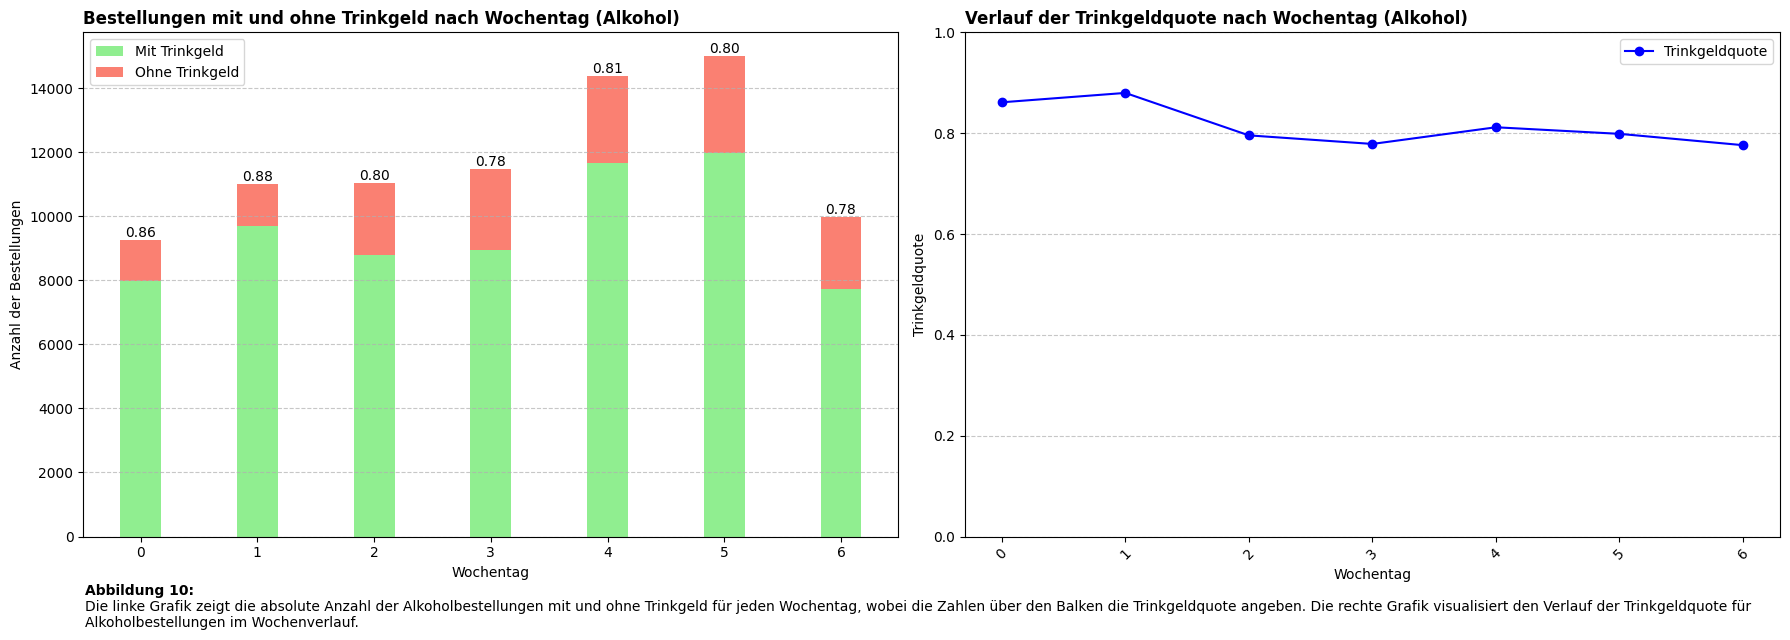

In [250]:
# plot code
alcohol_orders_weekday_df = pd.DataFrame(alcohol_orders_weekday_stats, columns=['day_of_the_week', 'total_orders', 'orders_with_tips'])

alcohol_orders_weekday_df['orders_without_tips'] = alcohol_orders_weekday_df['total_orders'] - alcohol_orders_weekday_df['orders_with_tips']
alcohol_orders_weekday_df['tip_ratio'] = alcohol_orders_weekday_df['orders_with_tips'] / alcohol_orders_weekday_df['total_orders']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
plt.subplots_adjust(left=0.08)

bar_width = 0.35

bar_with_tips = ax1.bar(alcohol_orders_weekday_df['day_of_the_week'], 
                        alcohol_orders_weekday_df['orders_with_tips'], 
                        bar_width, label='Mit Trinkgeld', color='lightgreen')
bar_without_tips = ax1.bar(alcohol_orders_weekday_df['day_of_the_week'], 
                          alcohol_orders_weekday_df['orders_without_tips'], 
                          bar_width, bottom=alcohol_orders_weekday_df['orders_with_tips'], 
                          label='Ohne Trinkgeld', color='salmon')

for i, rect in enumerate(bar_with_tips):
    height = rect.get_height() + bar_without_tips[i].get_height()
    ratio = alcohol_orders_weekday_df['tip_ratio'].iloc[i]
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 2, 
             f'{ratio:.2f}', ha='center', va='bottom')

ax1.set_title('Bestellungen mit und ohne Trinkgeld nach Wochentag (Alkohol)', 
              loc='left', weight='bold')
ax1.set_xlabel('Wochentag')
ax1.set_ylabel('Anzahl der Bestellungen')
ax1.legend()
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

ax2.plot(alcohol_orders_weekday_df['day_of_the_week'], 
         alcohol_orders_weekday_df['tip_ratio'], 
         marker='o', color='blue', label='Trinkgeldquote')
ax2.set_title('Verlauf der Trinkgeldquote nach Wochentag (Alkohol)', 
              loc='left', weight='bold')
ax2.set_xlabel('Wochentag')
ax2.set_ylabel('Trinkgeldquote')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)

description = 'Die linke Grafik zeigt die absolute Anzahl der Alkoholbestellungen mit und ohne Trinkgeld für jeden Wochentag, wobei die Zahlen über den Balken die Trinkgeldquote angeben. Die rechte Grafik visualisiert den Verlauf der Trinkgeldquote für Alkoholbestellungen im Wochenverlauf.'
fig.text(0.05, 0, 'Abbildung 10:', weight='bold', ha='left')
fig.text(0.05, -0.05, description, wrap=True)

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Detaillierte Trinkgeld-Analyse für Alkoholbestellungen: Anzahl und Verhältnis von Bestellungen mit Trinkgeld pro Wochentag und Stunde
results = (
    session.query(
        Order.day_of_the_week,
        Order.hour_of_day,
        func.sum(case((Order.tips == True, 1), else_=0)).label('orders_with_tips'),
        func.count(Order.order_id).label('total_orders'),
        (func.sum(case((Order.tips == True, 1), else_=0)) / func.count(Order.order_id)).label('tip_ratio')
    )
    .join(Einkaufskorb, Order.order_id == Einkaufskorb.order_id)  # Verknüpfung mit Einkaufskorb
    .join(Product, Einkaufskorb.product_id == Product.product_id)  # Verknüpfung mit Product
    .join(Department, Product.department_id == Department.department_id)  # Verknüpfung mit Department
    .filter(Department.department_name == 'alcohol')  # Filter auf Alkohol-Abteilung
    .group_by(Order.day_of_the_week, Order.hour_of_day)
    .order_by(Order.day_of_the_week, Order.hour_of_day)
    .all()
)

df = pd.DataFrame(results, columns=['day_of_the_week', 'hour_of_day', 'orders_with_tips', 'total_orders', 'tip_ratio'])
df['tip_ratio'] = pd.to_numeric(df['tip_ratio'], errors='coerce')

all_days = range(7)  # 0–6 
all_hours = range(24)  # 0–23 
full_index = pd.DataFrame(itertools.product(all_days, all_hours), columns=['day_of_the_week', 'hour_of_day'])

df = full_index.merge(df, on=['day_of_the_week', 'hour_of_day'], how='left')
df['tip_ratio'] = df['tip_ratio'].fillna(0)

heatmap_data = df.pivot_table(
    index='day_of_the_week',
    columns='hour_of_day',
    values='tip_ratio'
)

total_orders_heatmap = df.pivot_table(
    index='day_of_the_week',
    columns='hour_of_day',
    values='total_orders'
)

orders_with_tips_heatmap = df.pivot_table(
    index='day_of_the_week',
    columns='hour_of_day',
    values='orders_with_tips'
)


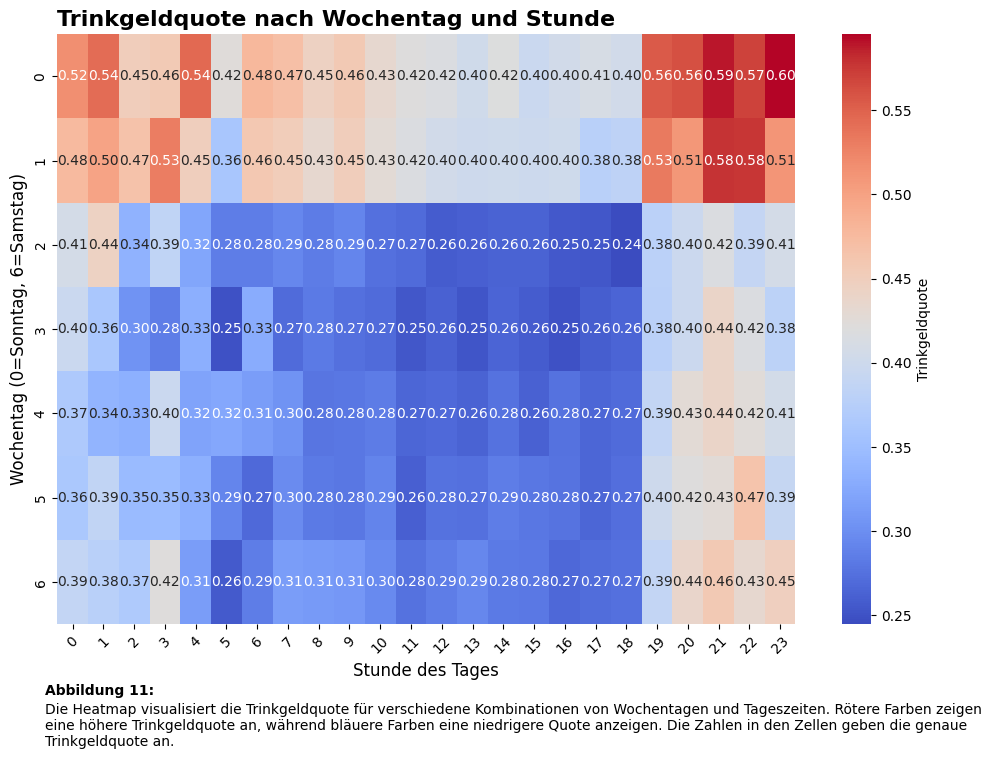

hour_of_day          0      1      2      3      4      5       6       7   \
day_of_the_week                                                              
0                1454.0  915.0  550.0  406.0  301.0  454.0  1380.0  4633.0   
1                1294.0  735.0  402.0  292.0  278.0  480.0  1560.0  4855.0   
2                1096.0  621.0  333.0  283.0  313.0  478.0  1328.0  3928.0   
3                1040.0  658.0  408.0  232.0  299.0  456.0  1420.0  3832.0   
4                 995.0  520.0  318.0  273.0  241.0  461.0  1360.0  3982.0   
5                1089.0  637.0  480.0  409.0  411.0  622.0  1645.0  4373.0   
6                1322.0  856.0  450.0  377.0  331.0  504.0  1311.0  4093.0   

hour_of_day           8        9   ...       14       15       16       17  \
day_of_the_week                    ...                                       
0                10573.0  15247.0  ...  21459.0  21618.0  19536.0  15894.0   
1                 9083.0  13342.0  ...  15199.0  15480.0  14989.0  12897.0   
2                 6817.0   9195.0  ...  11855.0  11742.0  12076.0  11079.0   
3                 6507.0   8495.0  ...  10837.0  11272.0  11866.0  10765.0   
4                 6219.0   8177.0  ...  10668.0  10998.0  11213.0  10033.0   
5                 7194.0   9925.0  ...  12449.0  12228.0  12420.0  11009.0   
6                 8677.0  11552.0  ...  15811.0  15236.0  15060.0  12329.0   

hour_of_day           18      19      20      21      22      23  
day_of_the_week                                                   
0                11441.0  8534.0  6855.0  5283.0  4203.0  2347.0  
1                10475.0  8119.0  6056.0  4273.0  3217.0  2005.0  
2                 9435.0  7279.0  5483.0  3746.0  2850.0  2015.0  
3                 9139.0  7095.0  4887.0  3721.0  2950.0  1770.0  
4                 8876.0  7181.0  5189.0  3989.0  3101.0  1999.0  
5                 9166.0  7251.0  5022.0  3753.0  3004.0  2105.0  
6                 9932.0  7195.0  5473.0  4135.0  3301.0  2290.0  

[7 rows x 24 columns]

In [ ]:
# plot code

fig, ax = plt.subplots(figsize=(10, 7))
plt.subplots_adjust(left=0.08)

sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={'label': 'Trinkgeldquote'},
    ax=ax
)

ax.set_title('Trinkgeldquote nach Wochentag und Stunde', 
             loc='left', 
             weight='bold',
             fontsize=16)
ax.set_xlabel('Stunde des Tages', fontsize=12)
ax.set_ylabel('Wochentag (0=Sonntag, 6=Samstag)', fontsize=12)

description = 'Die Heatmap visualisiert die Trinkgeldquote für verschiedene Kombinationen von Wochentagen und Tageszeiten. Rötere Farben zeigen eine höhere Trinkgeldquote an, während bläuere Farben eine niedrigere Quote anzeigen. Die Zahlen in den Zellen geben die genaue Trinkgeldquote an.'
fig.text(0.05, -0, 'Abbildung 11:', weight='bold', ha='left')
fig.text(0.05, -0.07, description, wrap=True)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

total_orders_heatmap

In [318]:
# Bestellungen von Tiefkühlprodukten nach Tageszeit: Gesamtbestellungen und Bestellungen mit Trinkgeld pro Stunde
frozen_orders_stats = session.query(
    Order.hour_of_day,
    func.count(Order.order_id).label('total_orders'),
    func.sum(case((Order.tips == True, 1), else_=0)).label('orders_with_tips')
).join(Einkaufskorb, Einkaufskorb.order_id == Order.order_id) \
 .join(Product, Product.product_id == Einkaufskorb.product_id) \
 .join(Department, Department.department_id == Product.department_id) \
 .filter(Department.department_name.ilike('%frozen%')) \
 .group_by(Order.hour_of_day) \
 .all()

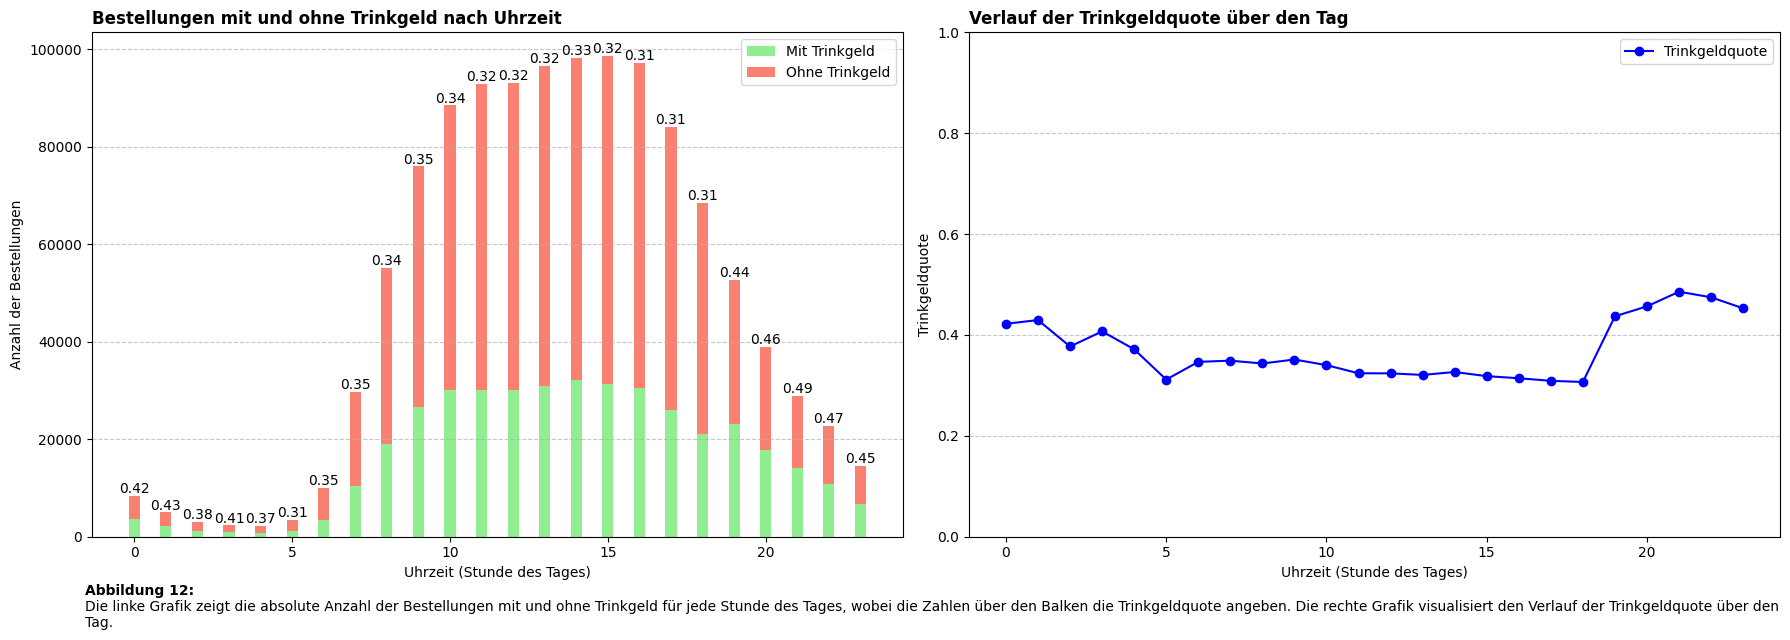

In [251]:
# plot code
frozen_orders_df = pd.DataFrame(frozen_orders_stats, columns=['hour_of_day', 'total_orders', 'orders_with_tips'])
frozen_orders_df['orders_without_tips'] = frozen_orders_df['total_orders'] - frozen_orders_df['orders_with_tips']
frozen_orders_df['tip_ratio'] = frozen_orders_df['orders_with_tips'] / frozen_orders_df['total_orders']

# Subplots erstellen
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
plt.subplots_adjust(left=0.08)

# Linker Plot: Gestapeltes Balkendiagramm
bar_with_tips = ax1.bar(frozen_orders_df['hour_of_day'], frozen_orders_df['orders_with_tips'], 
                        bar_width, label='Mit Trinkgeld', color='lightgreen')
bar_without_tips = ax1.bar(frozen_orders_df['hour_of_day'], frozen_orders_df['orders_without_tips'], 
                          bar_width, bottom=frozen_orders_df['orders_with_tips'], 
                          label='Ohne Trinkgeld', color='salmon')

# Quotienten oben auf den Balken im linken Plot anzeigen
for i, rect in enumerate(bar_with_tips):
    height = rect.get_height() + bar_without_tips[i].get_height()
    ratio = frozen_orders_df['tip_ratio'].iloc[i]
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 2, 
             f'{ratio:.2f}', ha='center', va='bottom')

# Titel und Achsenbeschriftungen für linken Plot
ax1.set_title('Bestellungen mit und ohne Trinkgeld nach Uhrzeit', 
              loc='left', weight='bold')
ax1.set_xlabel('Uhrzeit (Stunde des Tages)')
ax1.set_ylabel('Anzahl der Bestellungen')
ax1.legend()
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

# Rechter Plot: Liniendiagramm der Trinkgeldquote
ax2.plot(frozen_orders_df['hour_of_day'], frozen_orders_df['tip_ratio'], 
         marker='o', color='blue', label='Trinkgeldquote')
ax2.set_title('Verlauf der Trinkgeldquote über den Tag', 
              loc='left', weight='bold')
ax2.set_xlabel('Uhrzeit (Stunde des Tages)')
ax2.set_ylabel('Trinkgeldquote')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)

# Bildunterschrift
description = 'Die linke Grafik zeigt die absolute Anzahl der Bestellungen mit und ohne Trinkgeld für jede Stunde des Tages, wobei die Zahlen über den Balken die Trinkgeldquote angeben. Die rechte Grafik visualisiert den Verlauf der Trinkgeldquote über den Tag.'
fig.text(0.05, 0, 'Abbildung 12:', weight='bold', ha='left')
fig.text(0.05, -0.05, description, wrap=True)

plt.tight_layout()
plt.show()

In [73]:
# Vergleich von Gesamtbestellungen und Tiefkühlprodukt-Bestellungen pro Stunde des Tages

total_orders = session.query(
    Order.hour_of_day,
    func.count(distinct(Order.order_id)).label('total_orders')
).group_by(Order.hour_of_day).subquery()

frozen_orders = session.query(
    Order.hour_of_day,
    func.count(distinct(Order.order_id)).label('frozen_orders')
).join(Einkaufskorb, Einkaufskorb.order_id == Order.order_id) \
 .join(Product, Product.product_id == Einkaufskorb.product_id) \
 .join(Department, Department.department_id == Product.department_id) \
 .filter(Department.department_name.ilike('%frozen%')) \
 .group_by(Order.hour_of_day).subquery()

combined_stats = session.query(
    total_orders.c.hour_of_day,
    total_orders.c.total_orders,
    func.coalesce(frozen_orders.c.frozen_orders, 0).label('frozen_orders')
).outerjoin(
    frozen_orders,
    total_orders.c.hour_of_day == frozen_orders.c.hour_of_day
).order_by(total_orders.c.hour_of_day).all()


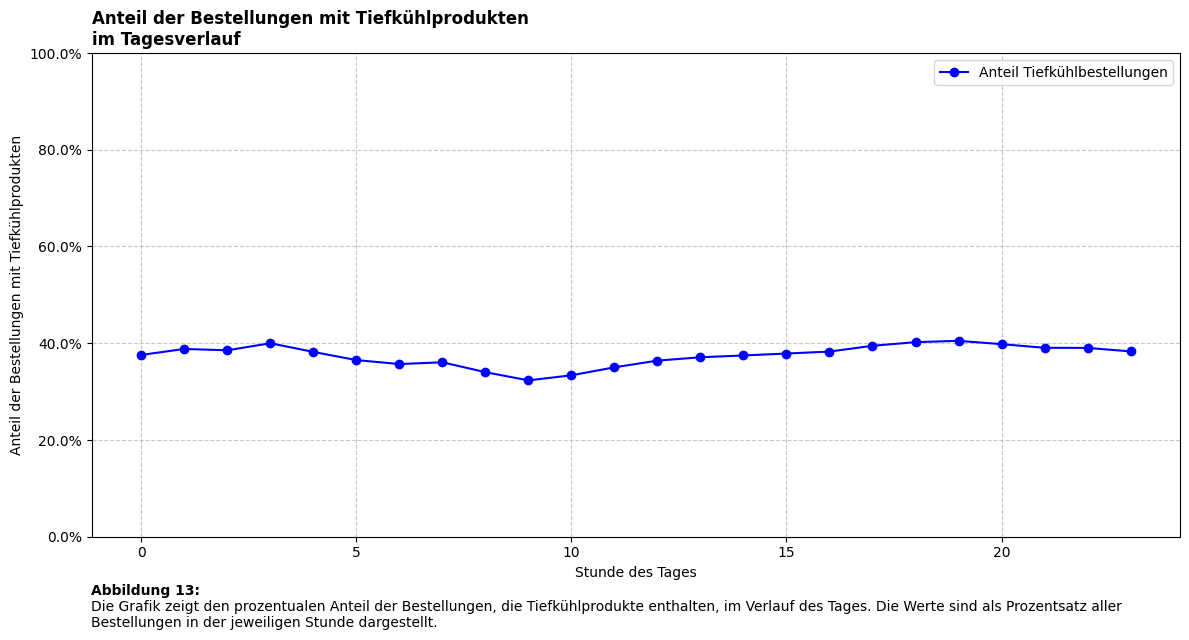

In [80]:
# plot code
combined_df = pd.DataFrame(combined_stats, columns=['hour_of_day', 'total_orders', 'frozen_orders'])
combined_df['frozen_ratio'] = combined_df['frozen_orders'] / combined_df['total_orders']

fig, ax = plt.subplots(figsize=(12, 6))
plt.subplots_adjust(left=0.08)

ax.plot(combined_df['hour_of_day'], combined_df['frozen_ratio'], 
        marker='o', color='blue', label='Anteil Tiefkühlbestellungen')

ax.set_title('Anteil der Bestellungen mit Tiefkühlprodukten\nim Tagesverlauf', 
             loc='left', weight='bold')
ax.set_xlabel('Stunde des Tages')
ax.set_ylabel('Anteil der Bestellungen mit Tiefkühlprodukten')
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
ax.set_ylim(0, 1)

description = 'Die Grafik zeigt den prozentualen Anteil der Bestellungen, die Tiefkühlprodukte enthalten, im Verlauf des Tages. Die Werte sind als Prozentsatz aller Bestellungen in der jeweiligen Stunde dargestellt.'
fig.text(0.08, 0, 'Abbildung 13:', weight='bold', ha='left')
fig.text(0.08, -0.05, description, wrap=True)

plt.tight_layout()
plt.show()

In [81]:
# Bestellungen von Tiefkühlprodukten nach Wochentag: Gesamtbestellungen und Bestellungen mit Trinkgeld
frozen_orders_weekday_stats = session.query(
    Order.day_of_the_week,
    func.count(Order.order_id).label('total_orders'),
    func.sum(case((Order.tips == True, 1), else_=0)).label('orders_with_tips')
).join(Einkaufskorb, Einkaufskorb.order_id == Order.order_id) \
 .join(Product, Product.product_id == Einkaufskorb.product_id) \
 .join(Department, Department.department_id == Product.department_id) \
 .filter(Department.department_name.ilike('%frozen%')) \
 .group_by(Order.day_of_the_week) \
 .all()

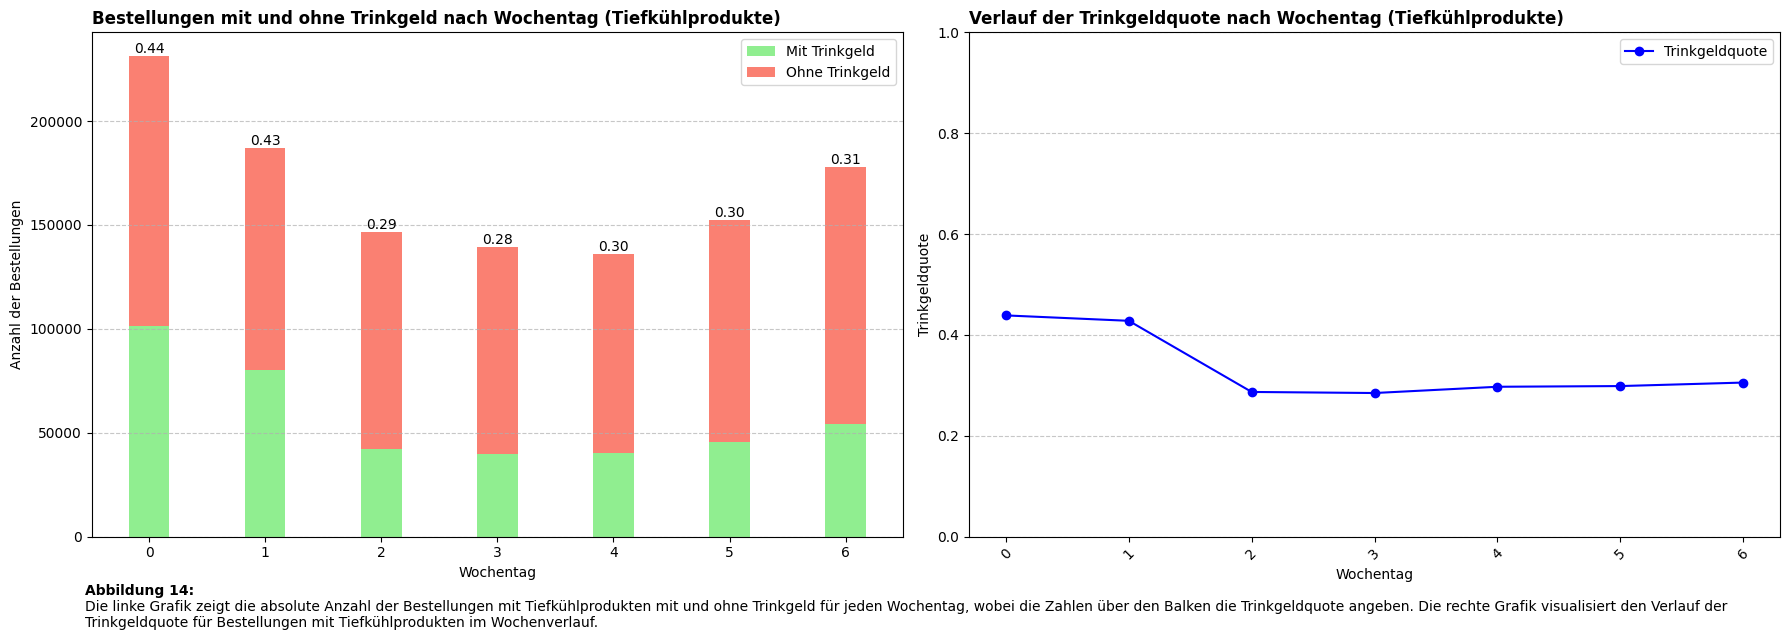

In [252]:
# plot code
frozen_orders_weekday_df = pd.DataFrame(frozen_orders_weekday_stats, columns=['day_of_the_week', 'total_orders', 'orders_with_tips'])

frozen_orders_weekday_df['orders_without_tips'] = frozen_orders_weekday_df['total_orders'] - frozen_orders_weekday_df['orders_with_tips']
frozen_orders_weekday_df['tip_ratio'] = frozen_orders_weekday_df['orders_with_tips'] / frozen_orders_weekday_df['total_orders']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
plt.subplots_adjust(left=0.08)

bar_width = 0.35

bar_with_tips = ax1.bar(frozen_orders_weekday_df['day_of_the_week'], 
                        frozen_orders_weekday_df['orders_with_tips'], 
                        bar_width, label='Mit Trinkgeld', color='lightgreen')
bar_without_tips = ax1.bar(frozen_orders_weekday_df['day_of_the_week'], 
                          frozen_orders_weekday_df['orders_without_tips'], 
                          bar_width, bottom=frozen_orders_weekday_df['orders_with_tips'], 
                          label='Ohne Trinkgeld', color='salmon')

for i, rect in enumerate(bar_with_tips):
    height = rect.get_height() + bar_without_tips[i].get_height()
    ratio = frozen_orders_weekday_df['tip_ratio'].iloc[i]
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 2, 
             f'{ratio:.2f}', ha='center', va='bottom')

ax1.set_title('Bestellungen mit und ohne Trinkgeld nach Wochentag (Tiefkühlprodukte)', 
              loc='left', weight='bold')
ax1.set_xlabel('Wochentag')
ax1.set_ylabel('Anzahl der Bestellungen')
ax1.legend()
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)


ax2.plot(frozen_orders_weekday_df['day_of_the_week'], 
         frozen_orders_weekday_df['tip_ratio'], 
         marker='o', color='blue', label='Trinkgeldquote')
ax2.set_title('Verlauf der Trinkgeldquote nach Wochentag (Tiefkühlprodukte)', 
              loc='left', weight='bold')
ax2.set_xlabel('Wochentag')
ax2.set_ylabel('Trinkgeldquote')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)


description = 'Die linke Grafik zeigt die absolute Anzahl der Bestellungen mit Tiefkühlprodukten mit und ohne Trinkgeld für jeden Wochentag, wobei die Zahlen über den Balken die Trinkgeldquote angeben. Die rechte Grafik visualisiert den Verlauf der Trinkgeldquote für Bestellungen mit Tiefkühlprodukten im Wochenverlauf.'
fig.text(0.05, 0, 'Abbildung 14:', weight='bold', ha='left')
fig.text(0.05, -0.05, description, wrap=True)

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Vergleich von Gesamtbestellungen und Tiefkühlprodukt-Bestellungen pro Wochentag
total_orders = session.query(
    Order.day_of_the_week,
    func.count(distinct(Order.order_id)).label('total_orders')
).group_by(Order.day_of_the_week).subquery()

frozen_orders = session.query(
    Order.day_of_the_week,
    func.count(distinct(Order.order_id)).label('frozen_orders')
).join(Einkaufskorb, Einkaufskorb.order_id == Order.order_id) \
 .join(Product, Product.product_id == Einkaufskorb.product_id) \
 .join(Department, Department.department_id == Product.department_id) \
 .filter(Department.department_name.ilike('%frozen%')) \
 .group_by(Order.day_of_the_week).subquery()

combined_stats = session.query(
    total_orders.c.day_of_the_week,
    total_orders.c.total_orders,
    func.coalesce(frozen_orders.c.frozen_orders, 0).label('frozen_orders')
).outerjoin(
    frozen_orders,
    total_orders.c.day_of_the_week == frozen_orders.c.day_of_the_week
).order_by(total_orders.c.day_of_the_week).all()

combined_df = pd.DataFrame(combined_stats, columns=['day_of_week', 'total_orders', 'frozen_orders'])
combined_df['frozen_ratio'] = combined_df['frozen_orders'] / combined_df['total_orders']


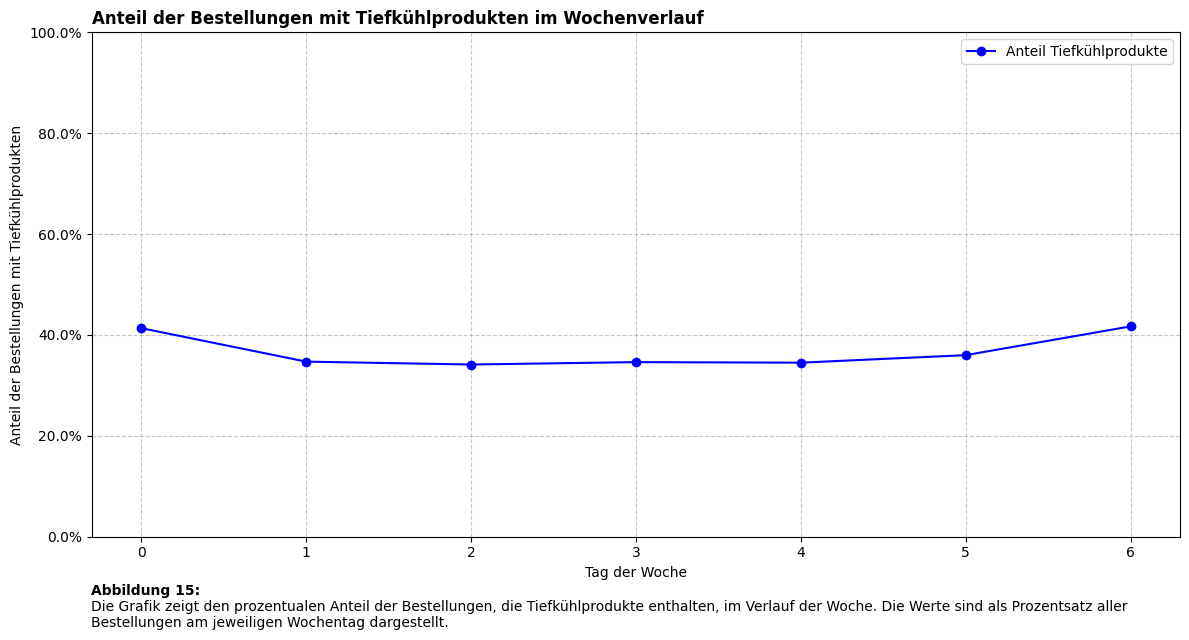

In [ ]:
# plot code
fig, ax = plt.subplots(figsize=(12, 6))
plt.subplots_adjust(left=0.08)

ax.plot(combined_df['day_of_week'], combined_df['frozen_ratio'], 
        marker='o', color='blue', label='Anteil Tiefkühlprodukte')

ax.set_title('Anteil der Bestellungen mit Tiefkühlprodukten im Wochenverlauf', 
             loc='left', weight='bold')
ax.set_xlabel('Tag der Woche')
ax.set_ylabel('Anteil der Bestellungen mit Tiefkühlprodukten')
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

ax.set_ylim(0, 1)

ax.set_xticks(range(7))

description = 'Die Grafik zeigt den prozentualen Anteil der Bestellungen, die Tiefkühlprodukte enthalten, im Verlauf der Woche. Die Werte sind als Prozentsatz aller Bestellungen am jeweiligen Wochentag dargestellt.'
fig.text(0.08, 0, 'Abbildung 15:', weight='bold', ha='left')
fig.text(0.08, -0.05, description, wrap=True)

plt.tight_layout()
plt.show()

In [92]:
# Detaillierte Trinkgeld-Analyse für Tiefkühlprodukte: Anzahl und Verhältnis von Bestellungen mit Trinkgeld pro Wochentag und Stunde
results = (
    session.query(
        Order.day_of_the_week,
        Order.hour_of_day,
        func.sum(case((Order.tips == True, 1), else_=0)).label('orders_with_tips'),
        func.count(Order.order_id).label('total_orders'),
        (func.sum(case((Order.tips == True, 1), else_=0)) / func.count(Order.order_id)).label('tip_ratio')
    )
    .join(Einkaufskorb, Order.order_id == Einkaufskorb.order_id)  # Verknüpfung mit Einkaufskorb
    .join(Product, Einkaufskorb.product_id == Product.product_id)  # Verknüpfung mit Product
    .join(Department, Product.department_id == Department.department_id)  # Verknüpfung mit Department
    .filter(Department.department_name == 'frozen')  # Filter auf Alkohol-Abteilung
    .group_by(Order.day_of_the_week, Order.hour_of_day)
    .order_by(Order.day_of_the_week, Order.hour_of_day)
    .all()
)


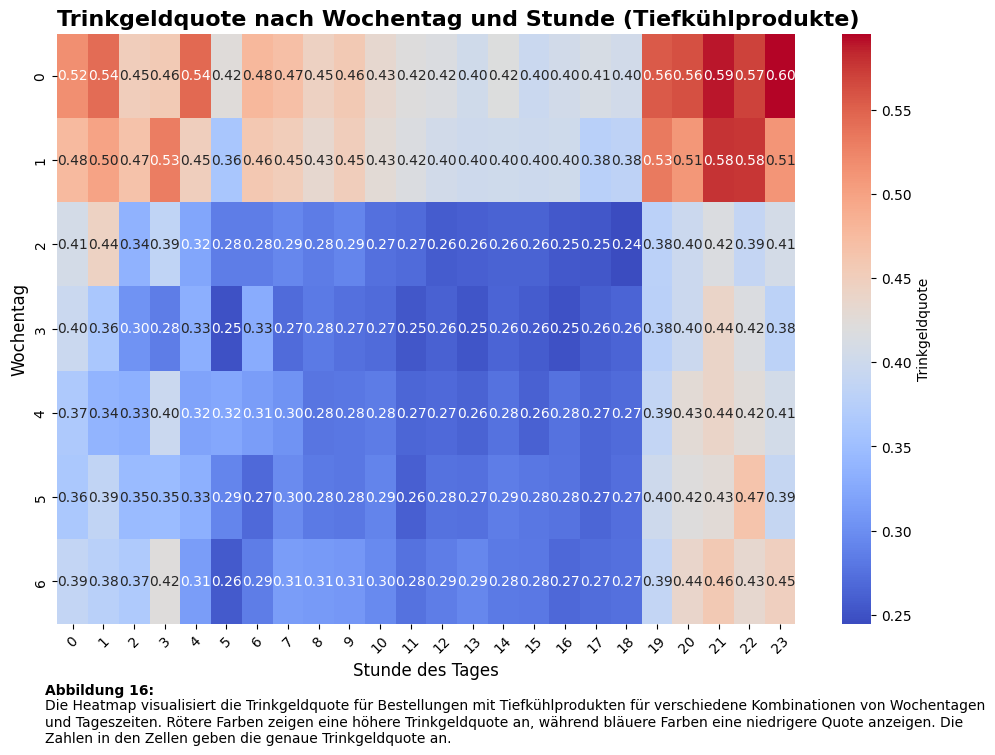

hour_of_day          0      1      2      3      4      5       6       7   \
day_of_the_week                                                              
0                1454.0  915.0  550.0  406.0  301.0  454.0  1380.0  4633.0   
1                1294.0  735.0  402.0  292.0  278.0  480.0  1560.0  4855.0   
2                1096.0  621.0  333.0  283.0  313.0  478.0  1328.0  3928.0   
3                1040.0  658.0  408.0  232.0  299.0  456.0  1420.0  3832.0   
4                 995.0  520.0  318.0  273.0  241.0  461.0  1360.0  3982.0   
5                1089.0  637.0  480.0  409.0  411.0  622.0  1645.0  4373.0   
6                1322.0  856.0  450.0  377.0  331.0  504.0  1311.0  4093.0   

hour_of_day           8        9   ...       14       15       16       17  \
day_of_the_week                    ...                                       
0                10573.0  15247.0  ...  21459.0  21618.0  19536.0  15894.0   
1                 9083.0  13342.0  ...  15199.0  15480.0  14989.0  12897.0   
2                 6817.0   9195.0  ...  11855.0  11742.0  12076.0  11079.0   
3                 6507.0   8495.0  ...  10837.0  11272.0  11866.0  10765.0   
4                 6219.0   8177.0  ...  10668.0  10998.0  11213.0  10033.0   
5                 7194.0   9925.0  ...  12449.0  12228.0  12420.0  11009.0   
6                 8677.0  11552.0  ...  15811.0  15236.0  15060.0  12329.0   

hour_of_day           18      19      20      21      22      23  
day_of_the_week                                                   
0                11441.0  8534.0  6855.0  5283.0  4203.0  2347.0  
1                10475.0  8119.0  6056.0  4273.0  3217.0  2005.0  
2                 9435.0  7279.0  5483.0  3746.0  2850.0  2015.0  
3                 9139.0  7095.0  4887.0  3721.0  2950.0  1770.0  
4                 8876.0  7181.0  5189.0  3989.0  3101.0  1999.0  
5                 9166.0  7251.0  5022.0  3753.0  3004.0  2105.0  
6                 9932.0  7195.0  5473.0  4135.0  3301.0  2290.0  

[7 rows x 24 columns]

In [ ]:
# plot code
df = pd.DataFrame(results, columns=['day_of_the_week', 'hour_of_day', 'orders_with_tips', 'total_orders', 'tip_ratio'])
df['tip_ratio'] = pd.to_numeric(df['tip_ratio'], errors='coerce')

all_days = range(7)  # 0–6
all_hours = range(24)  # 0–23 
full_index = pd.DataFrame(itertools.product(all_days, all_hours), columns=['day_of_the_week', 'hour_of_day'])

df = full_index.merge(df, on=['day_of_the_week', 'hour_of_day'], how='left')
df['tip_ratio'] = df['tip_ratio'].fillna(0)

heatmap_data = df.pivot_table(
    index='day_of_the_week',
    columns='hour_of_day',
    values='tip_ratio'
)

total_orders_heatmap = df.pivot_table(
    index='day_of_the_week',
    columns='hour_of_day',
    values='total_orders'
)

orders_with_tips_heatmap = df.pivot_table(
    index='day_of_the_week',
    columns='hour_of_day',
    values='orders_with_tips'
)


fig, ax = plt.subplots(figsize=(10, 7))
plt.subplots_adjust(left=0.08)

sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={'label': 'Trinkgeldquote'},
    ax=ax
)

ax.set_title('Trinkgeldquote nach Wochentag und Stunde (Tiefkühlprodukte)', 
             loc='left', 
             weight='bold',
             fontsize=16)
ax.set_xlabel('Stunde des Tages', fontsize=12)
ax.set_ylabel('Wochentag', fontsize=12)

description = 'Die Heatmap visualisiert die Trinkgeldquote für Bestellungen mit Tiefkühlprodukten für verschiedene Kombinationen von Wochentagen und Tageszeiten. Rötere Farben zeigen eine höhere Trinkgeldquote an, während bläuere Farben eine niedrigere Quote anzeigen. Die Zahlen in den Zellen geben die genaue Trinkgeldquote an.'
fig.text(0.05, 0, 'Abbildung 16:', weight='bold', ha='left')
fig.text(0.05, -0.065, description, wrap=True)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

total_orders_heatmap

In [98]:
# Anzahl der Produkte pro Bestellung und ob Trinkgeld gegeben wurde
all_orders_item_count_with_tips = session.query(
    Order.order_id,
    func.count(Einkaufskorb.product_id).label('item_count'),
    Order.tips,
    func.count(Order.order_id).label('total_orders')
).join(Einkaufskorb, Einkaufskorb.order_id == Order.order_id) \
 .join(Product, Product.product_id == Einkaufskorb.product_id) \
 .group_by(Order.order_id) \
 .all()

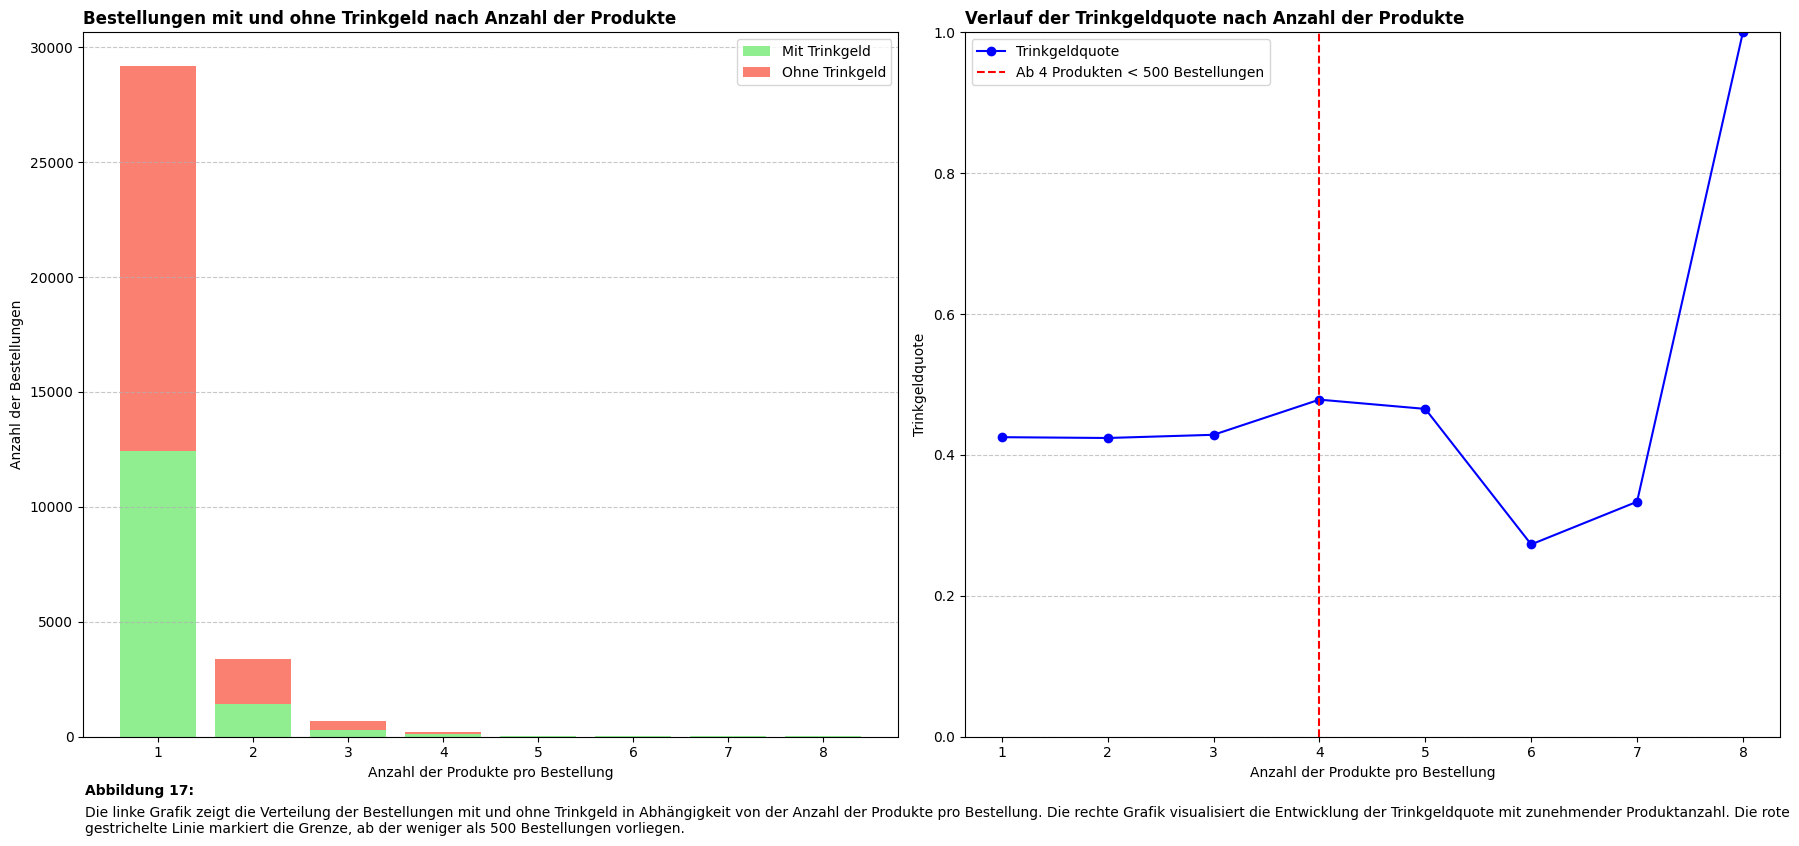

In [253]:
# plot code
results = all_orders_item_count_with_tips

df = pd.DataFrame(results, columns=['order_id', 'item_count', 'tips', 'total_orders'])

df['with_tips'] = df['tips'].apply(lambda x: 1 if x else 0)
df['without_tips'] = df['tips'].apply(lambda x: 0 if x else 1)

df = df[df['item_count'] <= 50]

agg_df = df.groupby('item_count').agg(
    orders_with_tips=('with_tips', 'sum'),
    orders_without_tips=('without_tips', 'sum'),
    total_orders=('order_id', 'count')
).reset_index()

agg_df['tips_ratio'] = agg_df['orders_with_tips'] / agg_df['total_orders']

threshold_item_count = agg_df[agg_df['total_orders'] < 500]['item_count'].min()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
plt.subplots_adjust(left=0.08)

bar_width = 0.8

bar_with_tips = ax1.bar(agg_df['item_count'], agg_df['orders_with_tips'], 
                        bar_width, label='Mit Trinkgeld', color='lightgreen')
bar_without_tips = ax1.bar(agg_df['item_count'], agg_df['orders_without_tips'], 
                          bar_width, bottom=agg_df['orders_with_tips'], 
                          label='Ohne Trinkgeld', color='salmon')

ax1.set_xlabel('Anzahl der Produkte pro Bestellung')
ax1.set_ylabel('Anzahl der Bestellungen')
ax1.set_title('Bestellungen mit und ohne Trinkgeld nach Anzahl der Produkte', 
              loc='left', weight='bold')
ax1.legend()
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)


ax2.plot(agg_df['item_count'], agg_df['tips_ratio'], 
         marker='o', color='b', label='Trinkgeldquote')
ax2.set_xlabel('Anzahl der Produkte pro Bestellung')
ax2.set_ylabel('Trinkgeldquote')
ax2.set_title('Verlauf der Trinkgeldquote nach Anzahl der Produkte', 
              loc='left', weight='bold')
ax2.legend()
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)


ax2.set_ylim(0, 1)

if not pd.isna(threshold_item_count):
    ax2.axvline(x=threshold_item_count, color='red', linestyle='--', 
                label=f'Ab {threshold_item_count} Produkten < 500 Bestellungen')
    ax2.legend()

description = 'Die linke Grafik zeigt die Verteilung der Bestellungen mit und ohne Trinkgeld in Abhängigkeit von der Anzahl der Produkte pro Bestellung. Die rechte Grafik visualisiert die Entwicklung der Trinkgeldquote mit zunehmender Produktanzahl. Die rote gestrichelte Linie markiert die Grenze, ab der weniger als 500 Bestellungen vorliegen.'
fig.text(0.05, 0, 'Abbildung 17:', weight='bold', ha='left')
fig.text(0.05, -0.045, description, wrap=True)

plt.tight_layout()
plt.show()




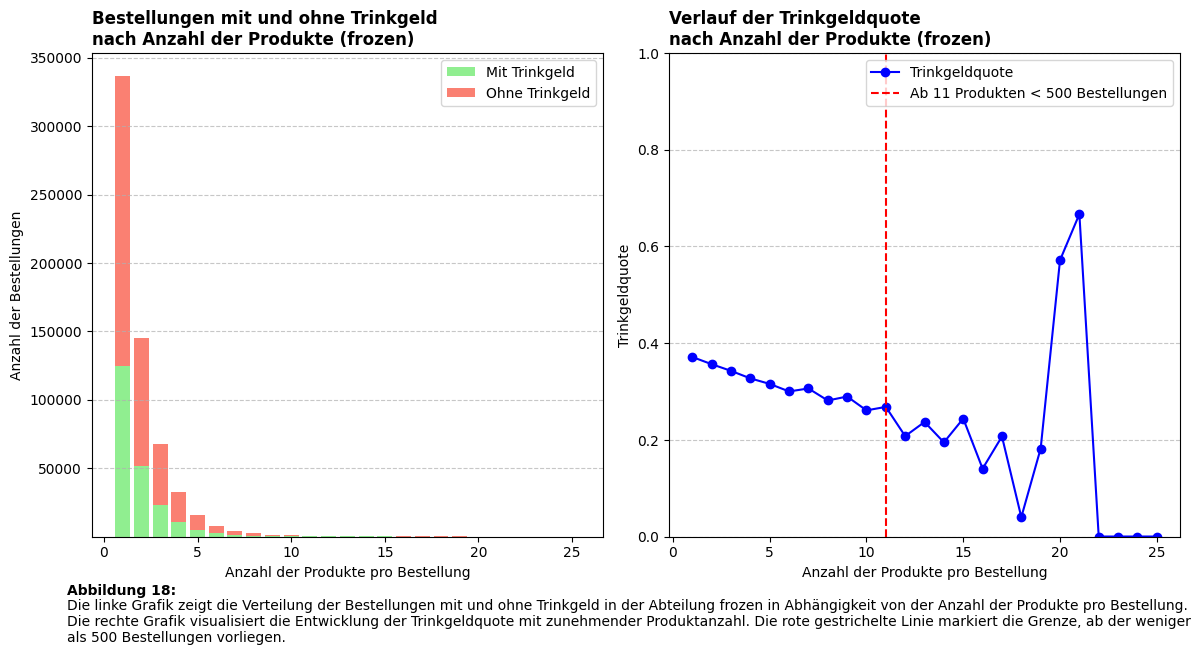

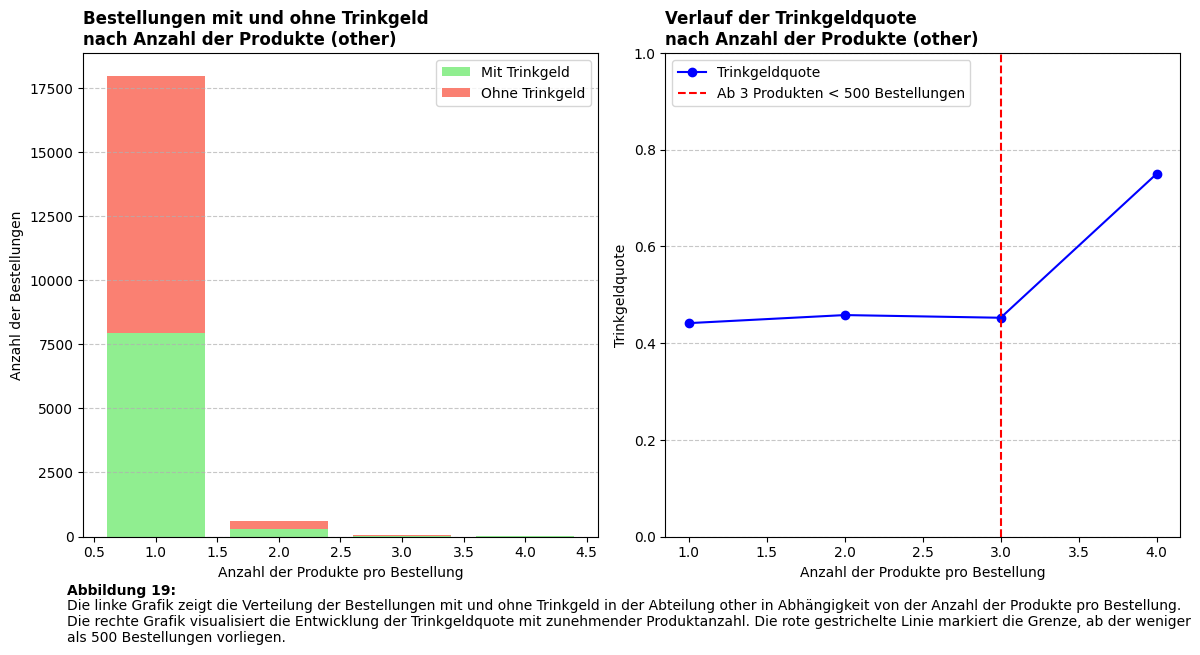

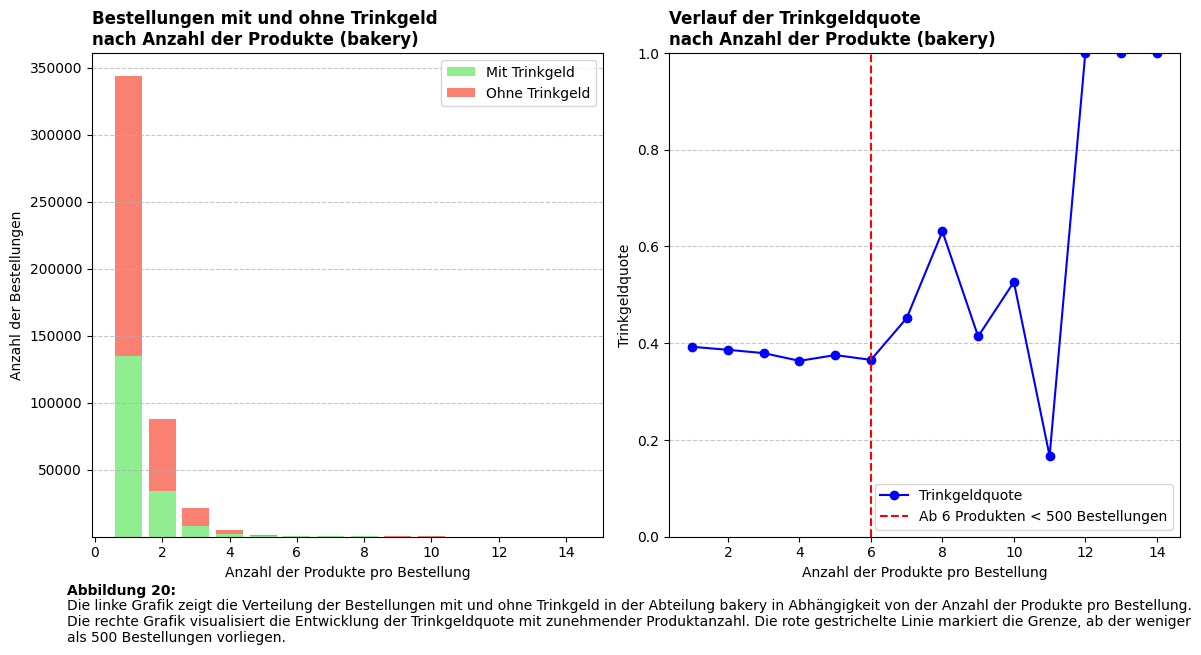

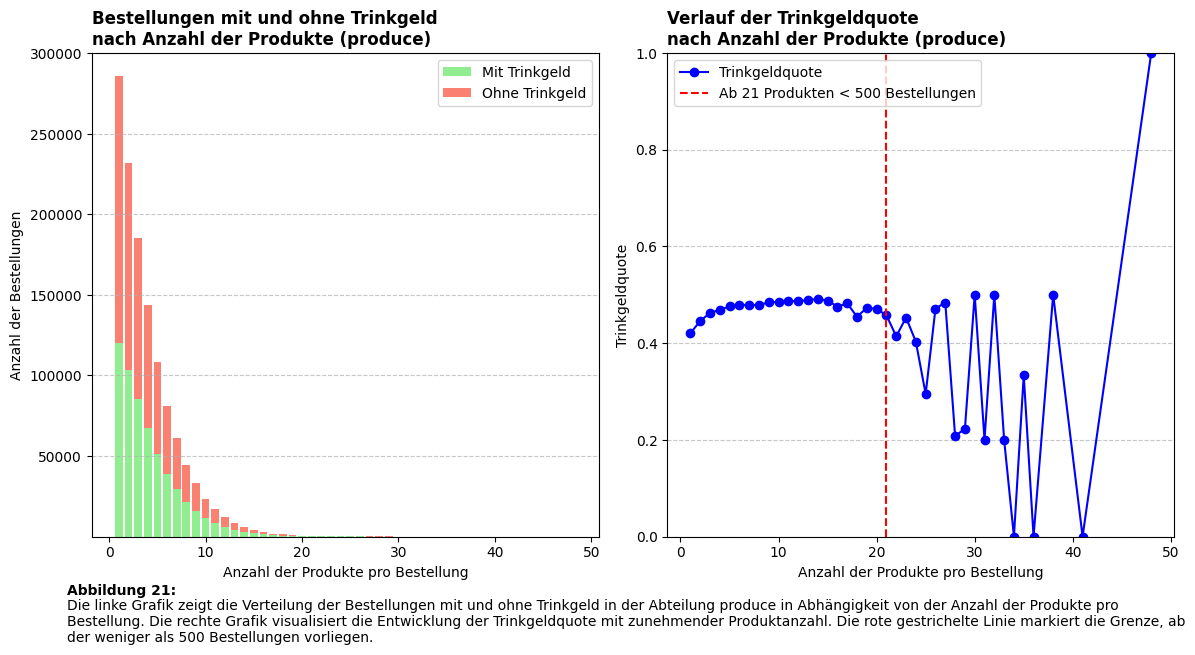

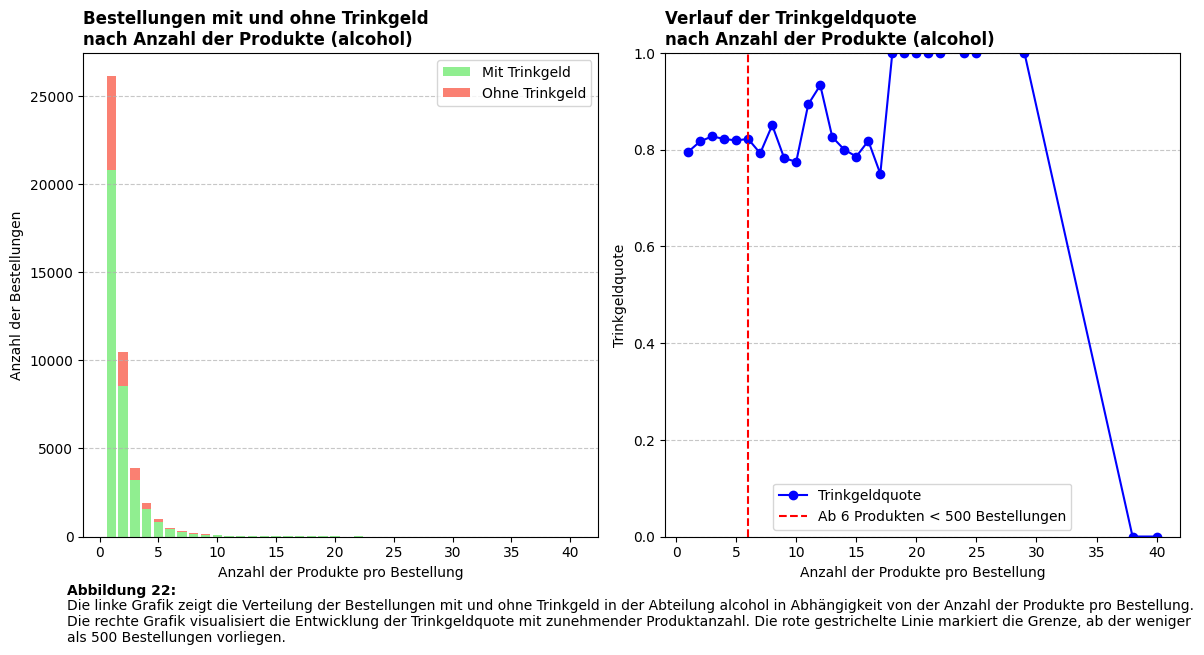

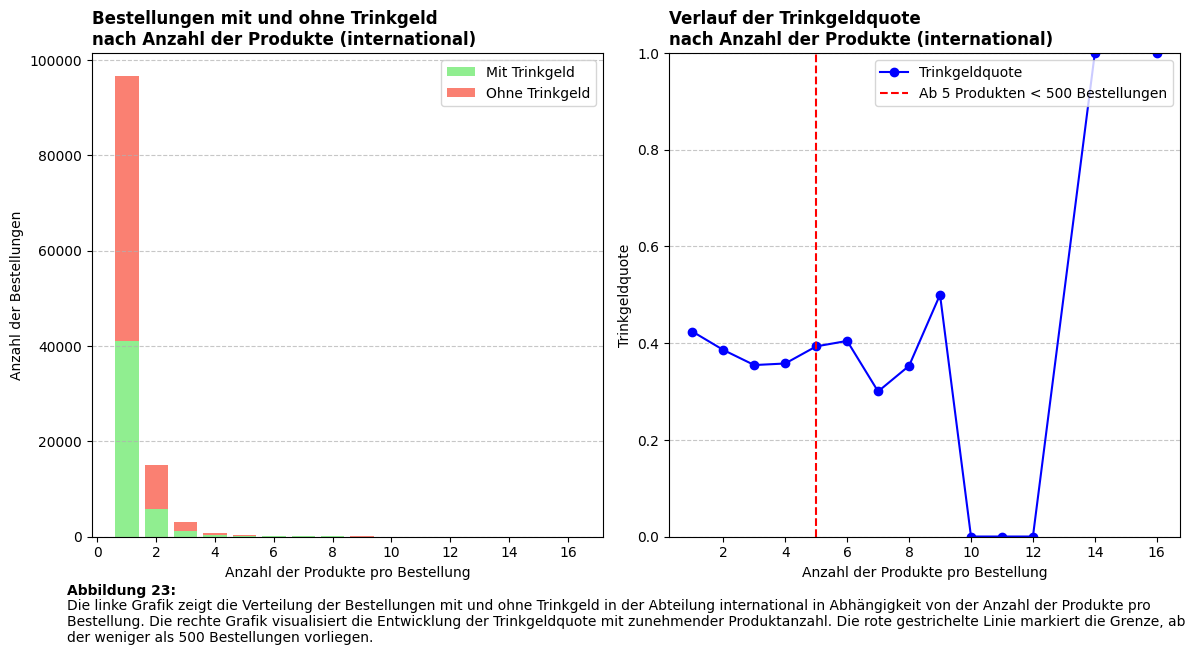

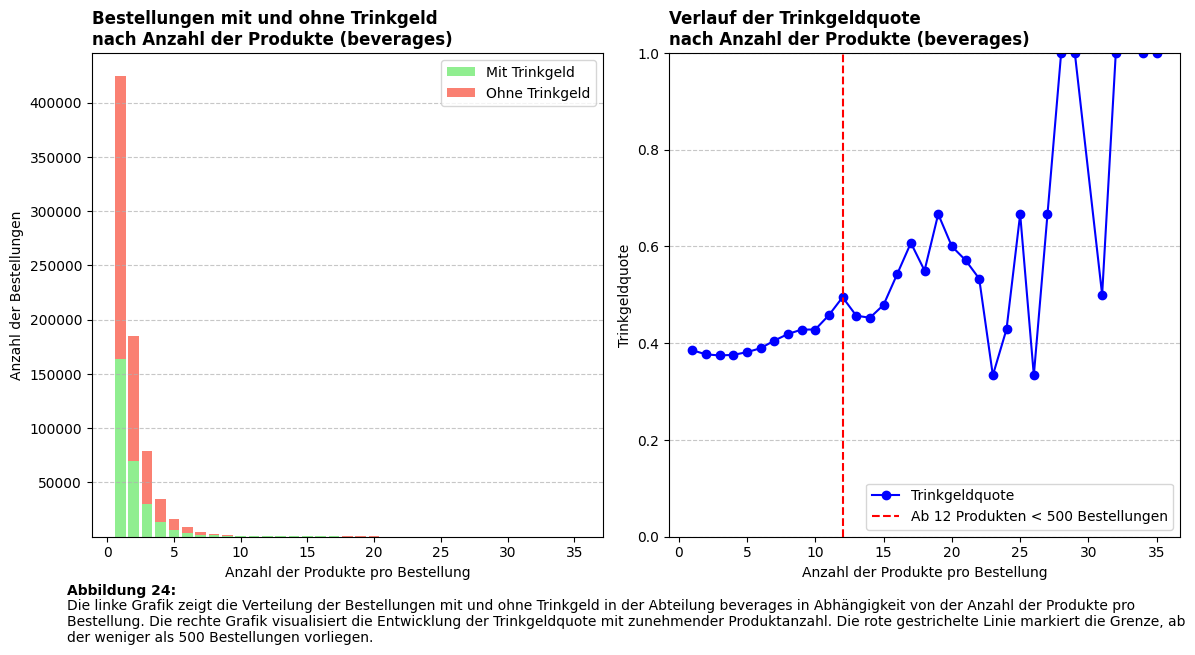

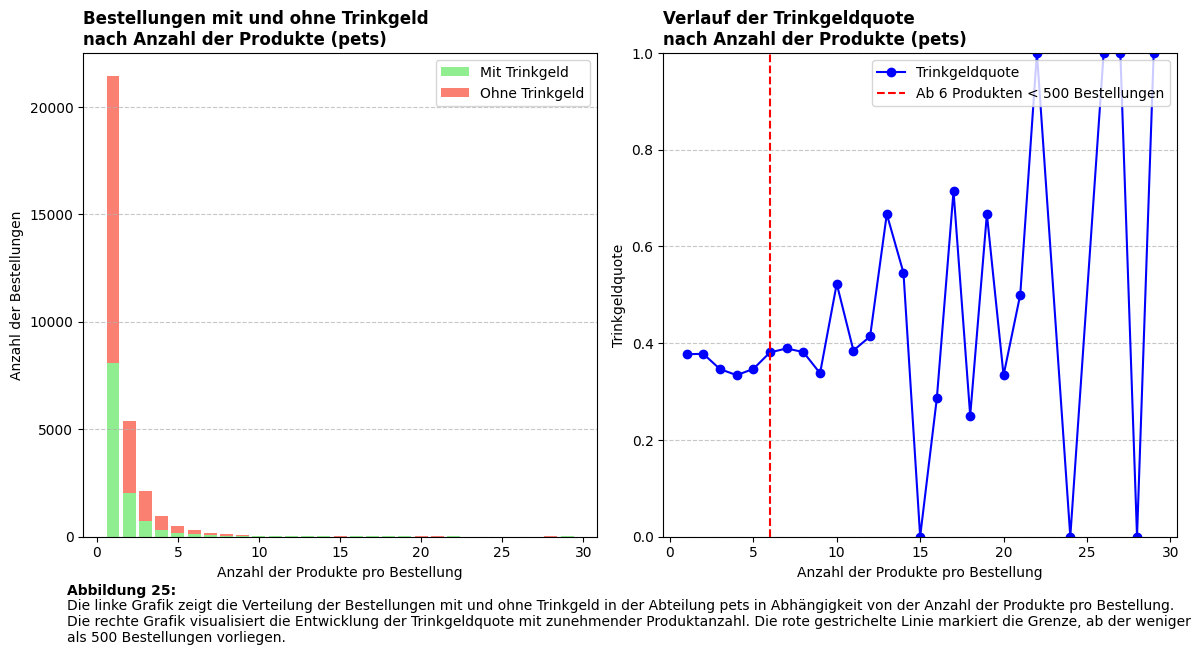

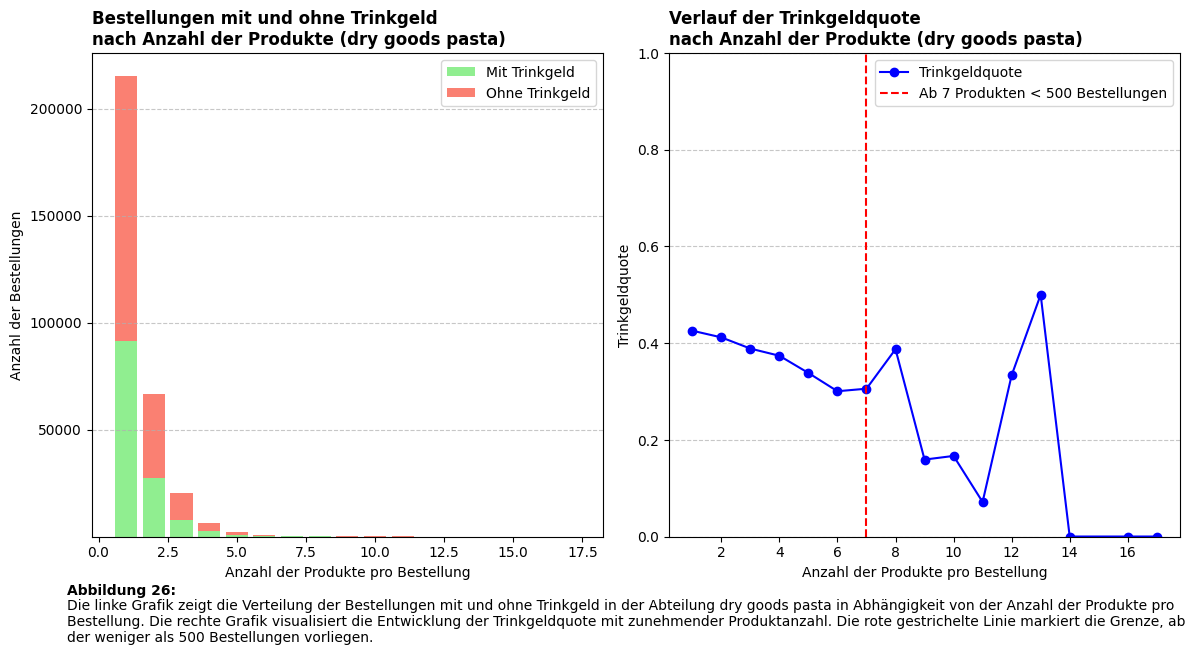

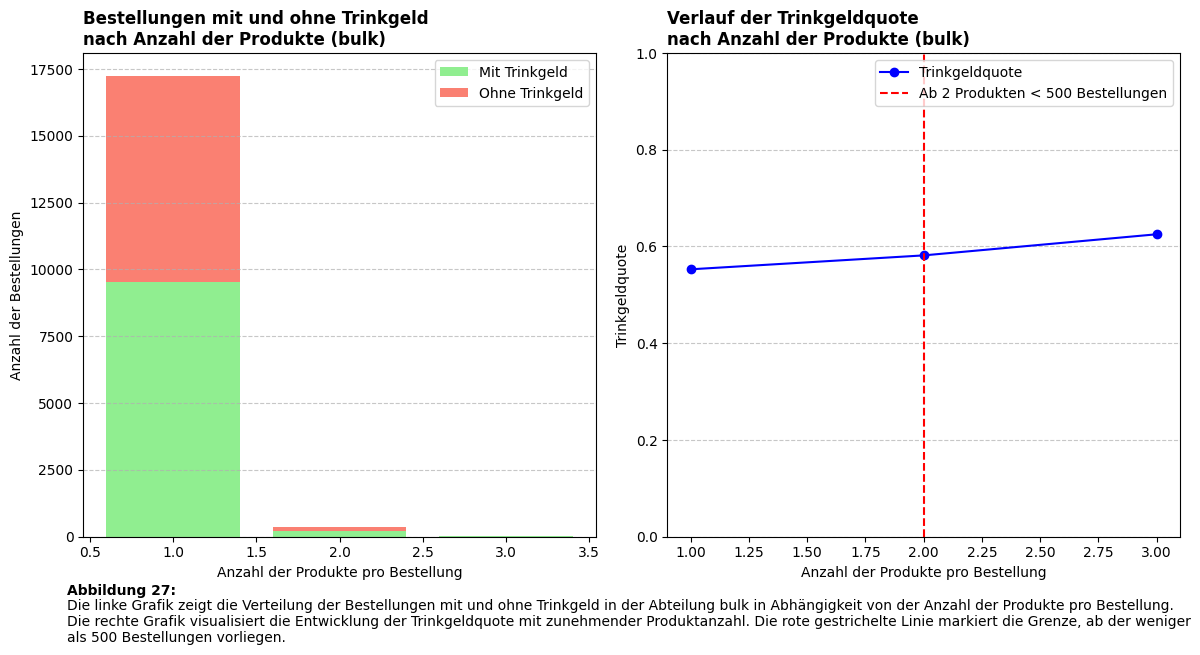

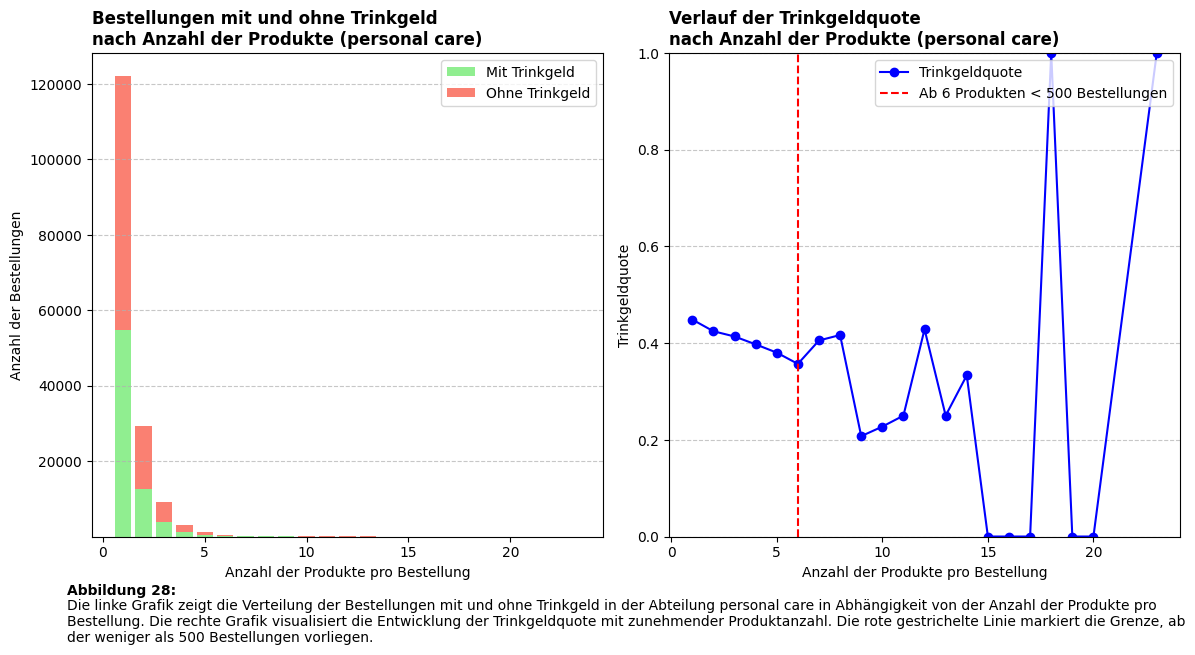

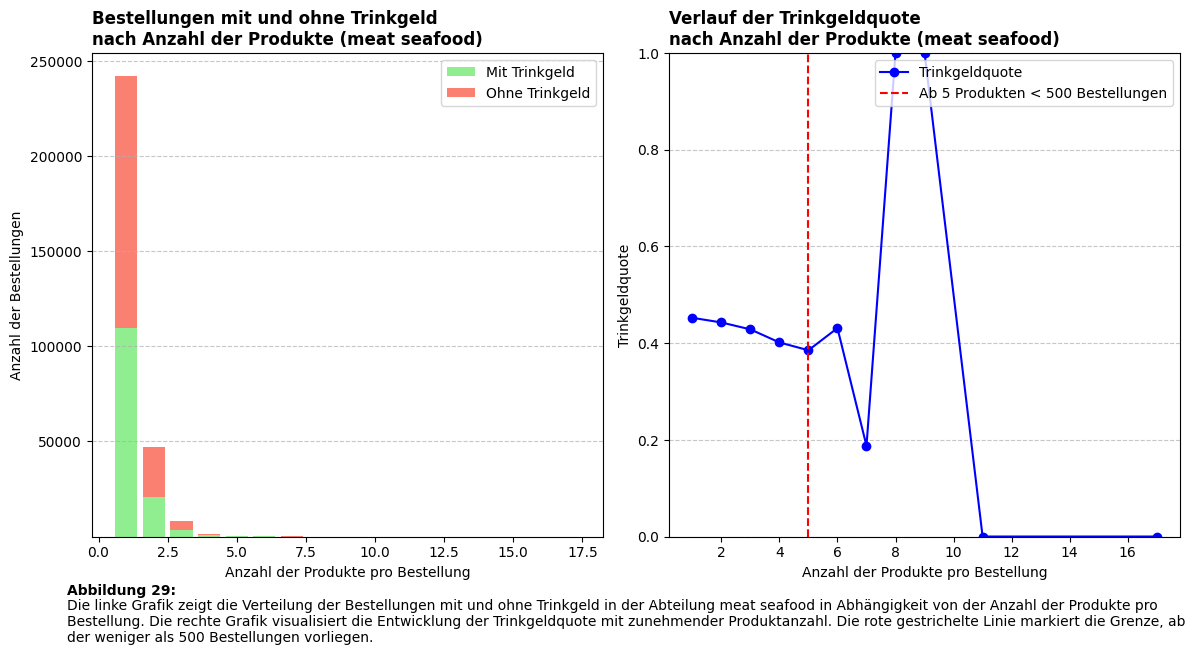

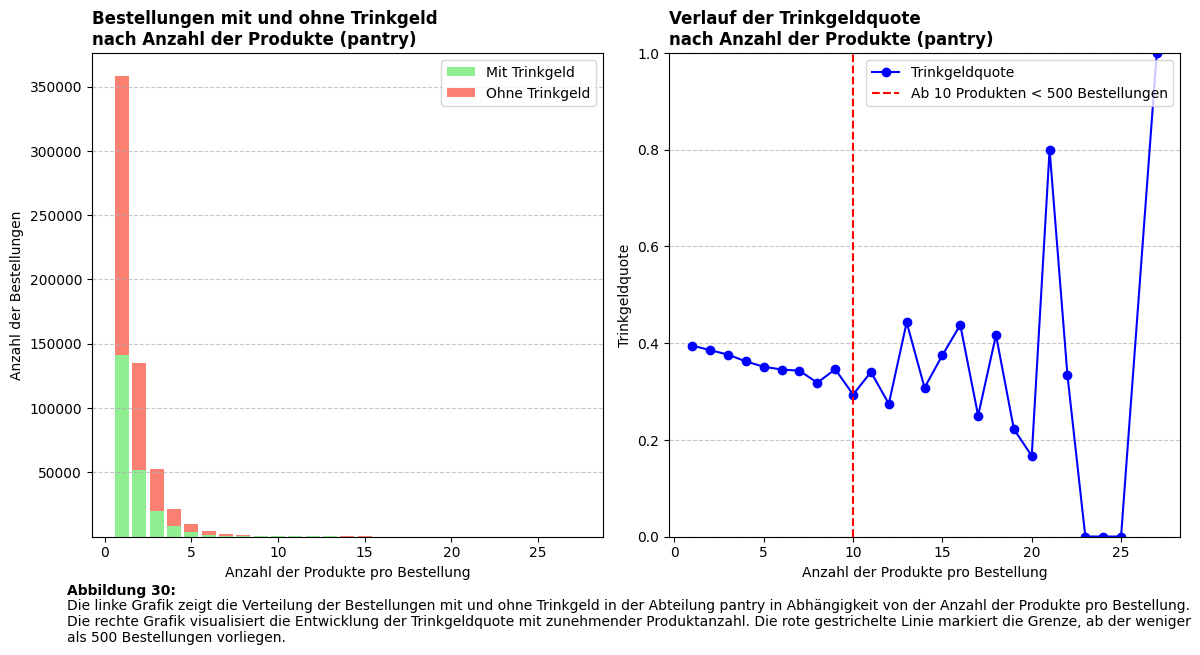

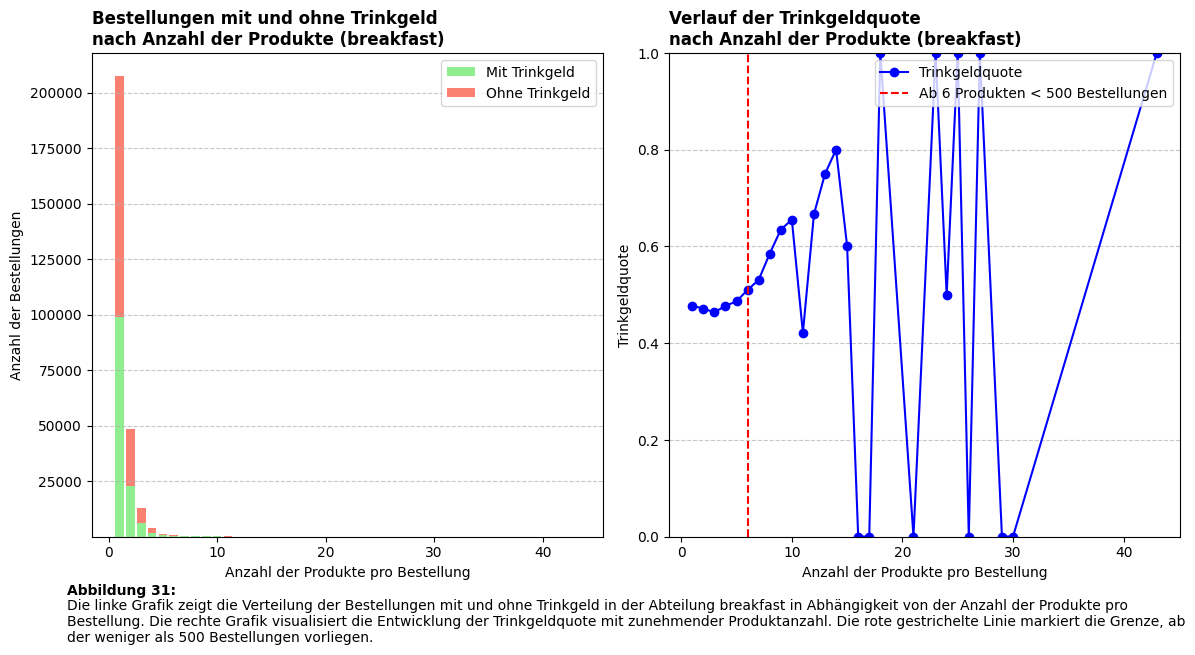

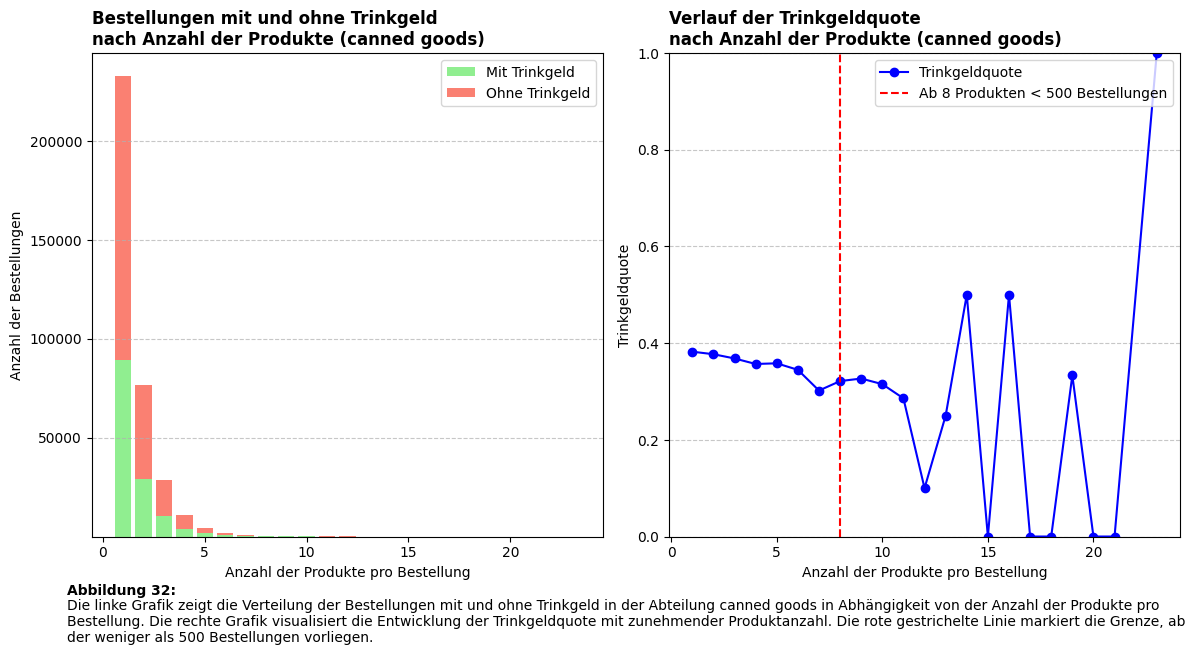

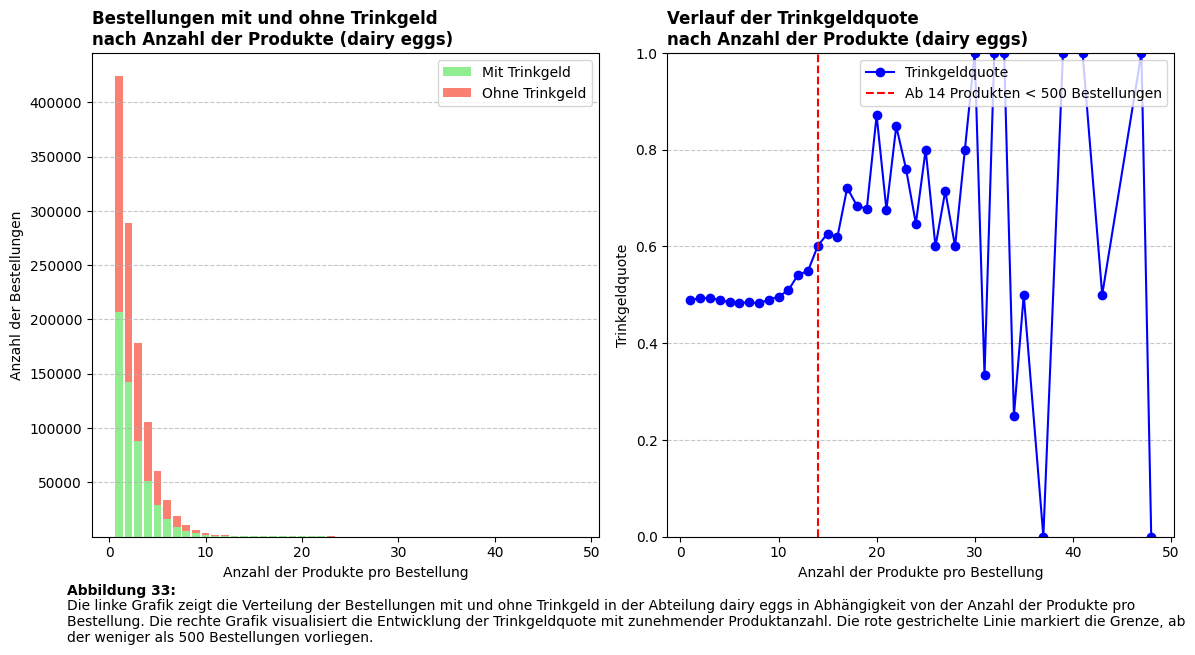

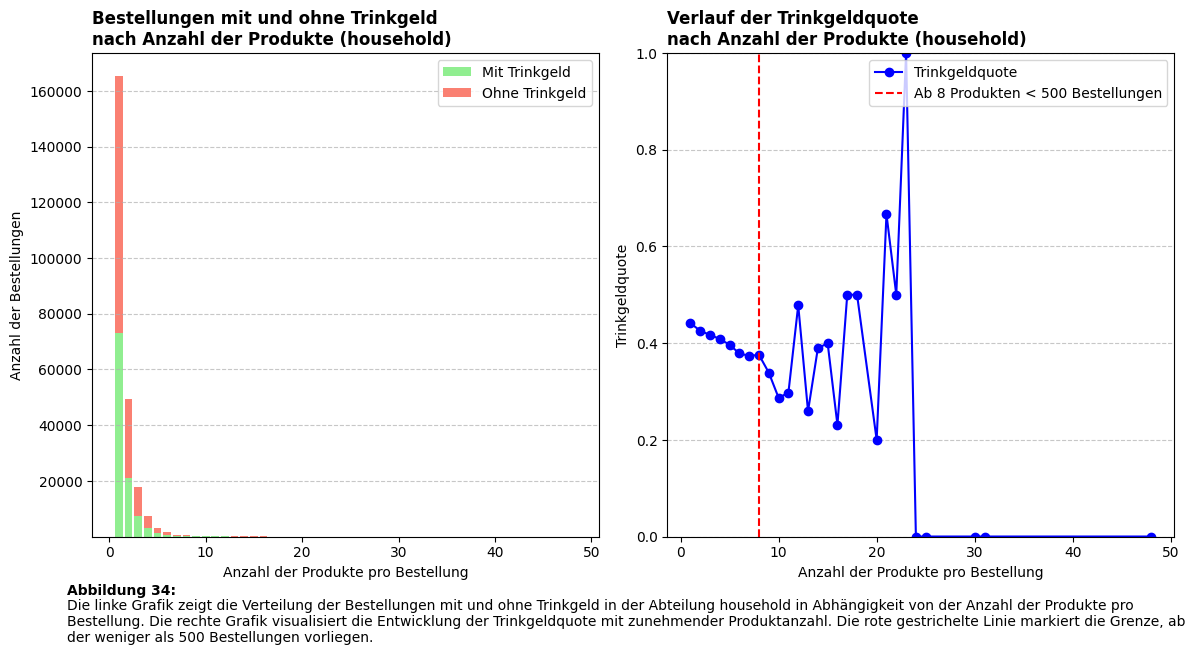

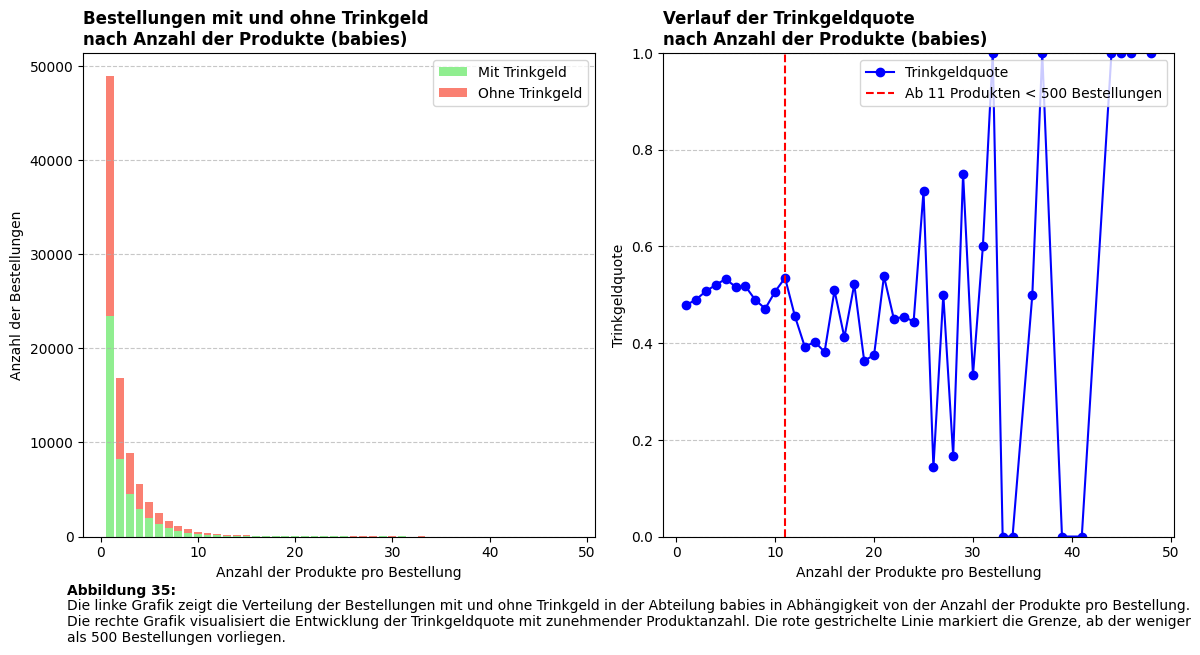

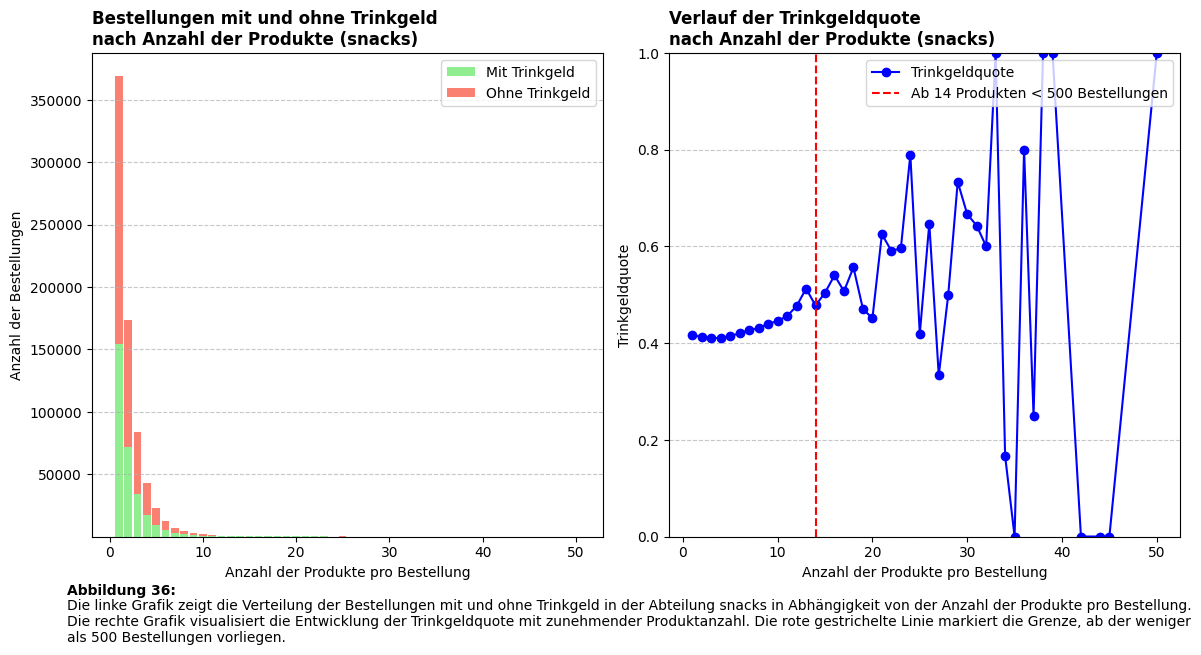

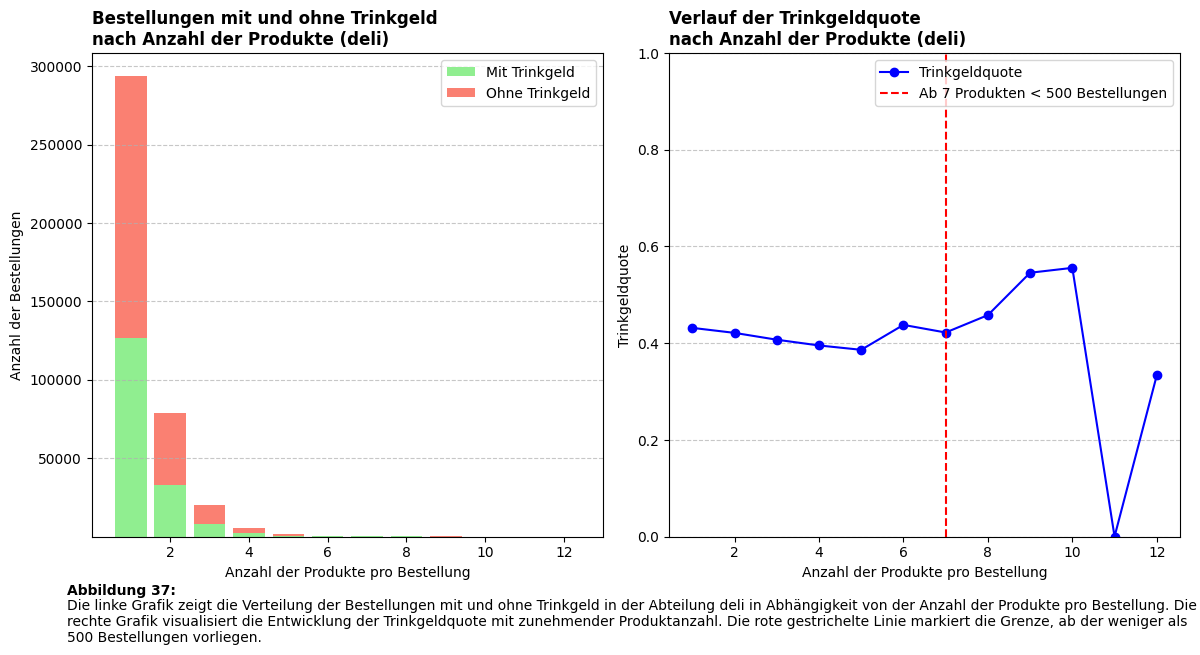

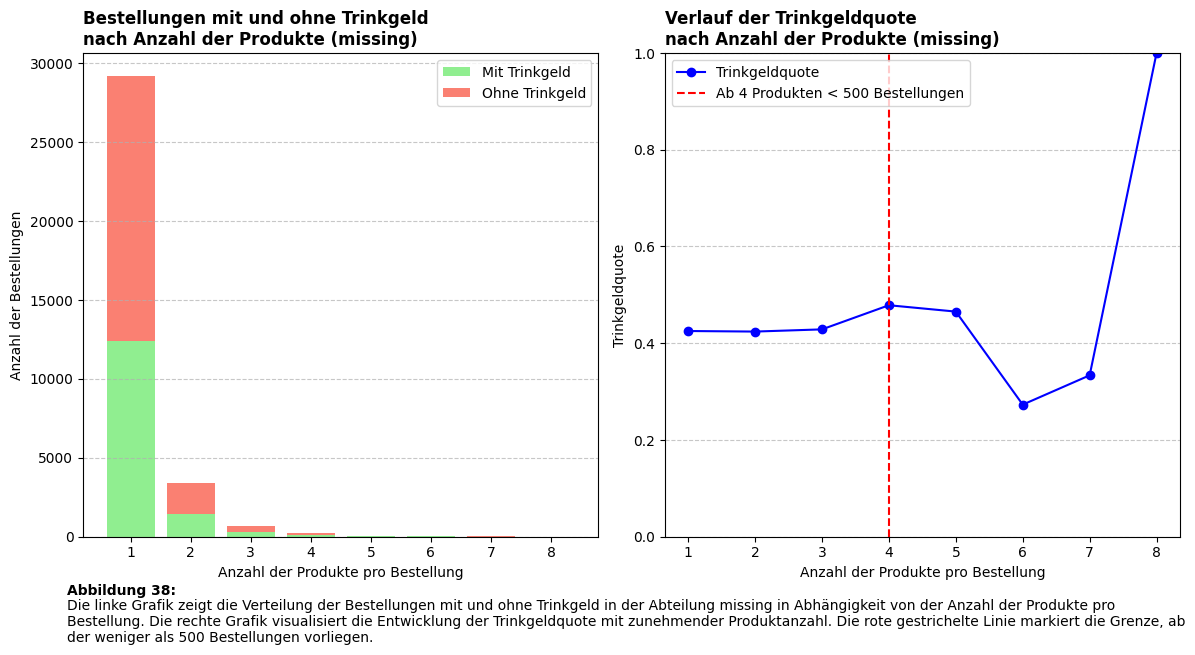

In [ ]:
# plot code
# Query: Alle Abteilungen
departments = session.query(Department.department_name).all()

for department in departments:
    department_name = department[0]  
    
    # Query: Anzahl der Produkte pro Bestellung und ob Trinkgeld gegeben wurde (für eine Abteilung)
    all_orders_item_count_with_tips = session.query(
        Order.order_id,
        func.count(Einkaufskorb.product_id).label('item_count'),
        Order.tips,
        func.count(Order.order_id).label('total_orders')
    ).join(Einkaufskorb, Einkaufskorb.order_id == Order.order_id) \
     .join(Product, Product.product_id == Einkaufskorb.product_id) \
     .join(Department, Department.department_id == Product.department_id) \
     .filter(Department.department_name == department_name) \
     .group_by(Order.order_id) \
     .all()

    results = all_orders_item_count_with_tips

    df = pd.DataFrame(results, columns=['order_id', 'item_count', 'tips', 'total_orders'])

    df['with_tips'] = df['tips'].apply(lambda x: 1 if x else 0)
    df['without_tips'] = df['tips'].apply(lambda x: 0 if x else 1)

    df = df[df['item_count'] <= 50]

    agg_df = df.groupby('item_count').agg(
        orders_with_tips=('with_tips', 'sum'),
        orders_without_tips=('without_tips', 'sum'),
        total_orders=('order_id', 'count')
    ).reset_index()

    agg_df['tips_ratio'] = agg_df['orders_with_tips'] / agg_df['total_orders']

    threshold_item_count = agg_df[agg_df['total_orders'] < 500]['item_count'].min()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    plt.subplots_adjust(left=0.08)

    bar_width = 0.8

    bar_with_tips = ax1.bar(agg_df['item_count'], agg_df['orders_with_tips'], 
                           bar_width, label='Mit Trinkgeld', color='lightgreen')
    bar_without_tips = ax1.bar(agg_df['item_count'], agg_df['orders_without_tips'], 
                              bar_width, bottom=agg_df['orders_with_tips'], 
                              label='Ohne Trinkgeld', color='salmon')

    ax1.set_xlabel('Anzahl der Produkte pro Bestellung')
    ax1.set_ylabel('Anzahl der Bestellungen')
    ax1.set_title(f'Bestellungen mit und ohne Trinkgeld\nnach Anzahl der Produkte ({department_name})', 
                  loc='left', weight='bold')
    ax1.legend()
    ax1.grid(True, axis='y', linestyle='--', alpha=0.7)


    ax2.plot(agg_df['item_count'], agg_df['tips_ratio'], 
             marker='o', color='b', label='Trinkgeldquote')
    
    if not pd.isna(threshold_item_count):
        ax2.axvline(x=threshold_item_count, color='red', linestyle='--', 
                    label=f'Ab {threshold_item_count} Produkten < 500 Bestellungen')

    ax2.set_xlabel('Anzahl der Produkte pro Bestellung')
    ax2.set_ylabel('Trinkgeldquote')
    ax2.set_title(f'Verlauf der Trinkgeldquote\nnach Anzahl der Produkte ({department_name})', 
                  loc='left', weight='bold')
    ax2.legend()
    ax2.set_ylim(0, 1)
    ax2.grid(True, axis='y', linestyle='--', alpha=0.7)


    # Bildunterschrift
    description = f'Die linke Grafik zeigt die Verteilung der Bestellungen mit und ohne Trinkgeld in der Abteilung {department_name} in Abhängigkeit von der Anzahl der Produkte pro Bestellung. Die rechte Grafik visualisiert die Entwicklung der Trinkgeldquote mit zunehmender Produktanzahl. Die rote gestrichelte Linie markiert die Grenze, ab der weniger als 500 Bestellungen vorliegen.'
    fig.text(0.06, 0, f'Abbildung {18+departments.index(department)}:', weight='bold', ha='left')
    fig.text(0.06, -0.075, description, wrap=True)

    plt.tight_layout()
    plt.show()



In [236]:
# Vergleich: Anzahl der Bestellungen mit Bio-Produkten vs. Gesamtanzahl der Bestellungen
orders_with_organic = (
    session.query(Order.order_id)
    .join(Einkaufskorb, Order.order_id == Einkaufskorb.order_id)  
    .join(Product, Einkaufskorb.product_id == Product.product_id) 
    .filter(Product.product_name.ilike('%organic%'))  
    .distinct()  
    .group_by(Order.order_id)  
    .count()  
)

total_orders = session.query(Order).count()


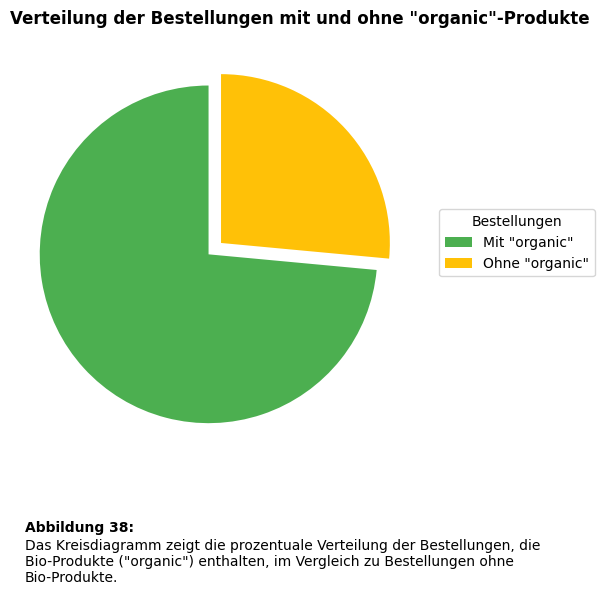

In [ ]:
# plot code
orders_without_organic = total_orders - orders_with_organic

labels = ['Mit "organic"', 'Ohne "organic"']
sizes = [orders_with_organic, orders_without_organic]
colors = ['#4CAF50', '#FFC107']  
explode = (0.1, 0)  

fig, ax = plt.subplots(figsize=(6, 6))
plt.subplots_adjust(left=0.08)

wedges, texts = ax.pie(sizes, labels=None, colors=colors, explode=explode, startangle=90)

ax.legend(wedges, labels,
         title="Bestellungen",
         loc="center left",
         bbox_to_anchor=(1, 0, 0.5, 1))

ax.set_title('Verteilung der Bestellungen mit und ohne "organic"-Produkte', 
             loc='left', weight='bold')

description = 'Das Kreisdiagramm zeigt die prozentuale Verteilung der Bestellungen, die Bio-Produkte ("organic") enthalten, im Vergleich zu Bestellungen ohne Bio-Produkte.'
fig.text(0.05, 0, 'Abbildung 38:', weight='bold', ha='left')
fig.text(0.05, -0.08, description, wrap=True)

plt.tight_layout()
plt.show()

In [ ]:
# Vergleichsanalyse: Trinkgeldverhalten bei Bestellungen mit und ohne Bio-Produkte
organic_with_tips = (
    session.query(Order)
    .join(Einkaufskorb, Order.order_id == Einkaufskorb.order_id)
    .join(Product, Einkaufskorb.product_id == Product.product_id)
    .filter(Product.product_name.ilike('%organic%'))
    .filter(Order.tips == True)
    .distinct()
    .count()
)

organic_without_tips = (
    session.query(Order)
    .join(Einkaufskorb, Order.order_id == Einkaufskorb.order_id)
    .join(Product, Einkaufskorb.product_id == Product.product_id)
    .filter(Product.product_name.ilike('%organic%'))
    .filter(Order.tips == False)
    .distinct()
    .count()
)

total_organic_orders = organic_with_tips + organic_without_tips

non_organic_with_tips = (
    session.query(Order)
    .outerjoin(Einkaufskorb, Order.order_id == Einkaufskorb.order_id)
    .outerjoin(Product, Einkaufskorb.product_id == Product.product_id)
    .filter(~Product.product_name.ilike('%organic%'))
    .filter(Order.tips == True)
    .distinct()
    .count()
)

non_organic_without_tips = (
    session.query(Order)
    .outerjoin(Einkaufskorb, Order.order_id == Einkaufskorb.order_id)
    .outerjoin(Product, Einkaufskorb.product_id == Product.product_id)
    .filter(~Product.product_name.ilike('%organic%'))
    .filter(Order.tips == False)
    .distinct()
    .count()
)

total_non_organic_orders = non_organic_with_tips + non_organic_without_tips

tip_probability_organic = organic_with_tips / total_organic_orders if total_organic_orders > 0 else 0
tip_probability_non_organic = non_organic_with_tips / total_non_organic_orders if total_non_organic_orders > 0 else 0


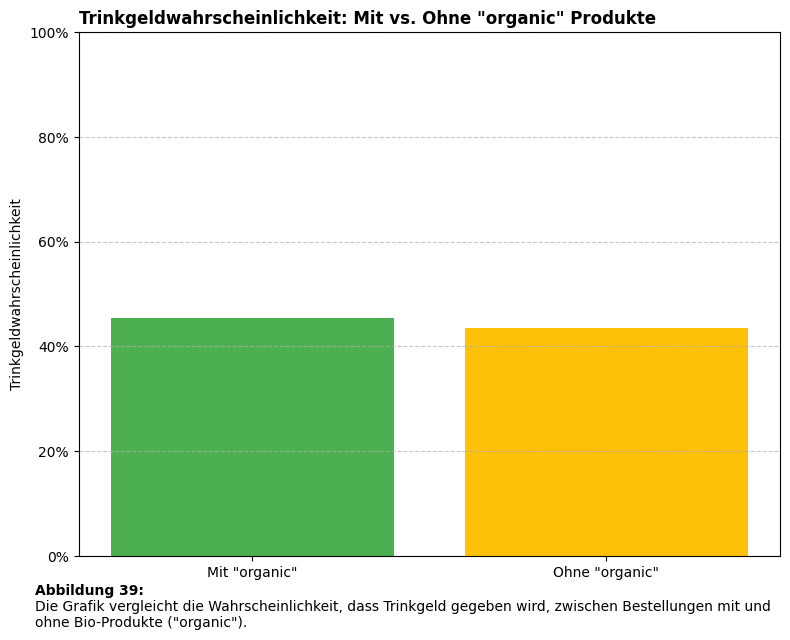

In [255]:
# plot code
labels = ['Mit "organic"', 'Ohne "organic"']
probabilities = [tip_probability_organic, tip_probability_non_organic]
colors = ['#4CAF50', '#FFC107']

fig, ax = plt.subplots(figsize=(8, 6))
plt.subplots_adjust(left=0.08)

ax.bar(labels, probabilities, color=colors)

ax.set_ylabel('Trinkgeldwahrscheinlichkeit')
ax.set_title('Trinkgeldwahrscheinlichkeit: Mit vs. Ohne "organic" Produkte', 
             loc='left', weight='bold')
ax.set_ylim(0, 1)  

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.grid(True, axis='y', linestyle='--', alpha=0.7)


description = 'Die Grafik vergleicht die Wahrscheinlichkeit, dass Trinkgeld gegeben wird, zwischen Bestellungen mit und ohne Bio-Produkte ("organic").'
fig.text(0.05, 0, 'Abbildung 39:', weight='bold', ha='left')
fig.text(0.05, -0.05, description, wrap=True)

plt.tight_layout()
plt.show()

In [ ]:
# füge in vergleich mehrere Abstufungen vo n anteil mder Bestellung hinzu

In [126]:
# Anzahl der Bestellungen, die nur "organic"-Produkte enthalten
only_organic_orders = (
    session.query(Order.order_id)
    .join(Einkaufskorb, Order.order_id == Einkaufskorb.order_id)
    .join(Product, Einkaufskorb.product_id == Product.product_id)
    .group_by(Order.order_id)  # Gruppiere nach Bestellungen
    .having(
        func.count(Product.product_id) == func.count(
            case((Product.product_name.ilike('%organic%'), 1))
        )
    )  # Prüfe, ob alle Produkte in der Bestellung "organic" im Namen haben
).count()

only_organic_tips_abs = (
    session.query(Order.order_id)
    .join(Einkaufskorb, Order.order_id == Einkaufskorb.order_id)
    .join(Product, Einkaufskorb.product_id == Product.product_id)
    .filter(Order.tips == True)  # Filtere Bestellungen mit Trinkgeld
    .group_by(Order.order_id)  # Gruppiere nach Bestellungen
    .having(
        func.count(Product.product_id) == func.count(
            case((Product.product_name.ilike('%organic%'), 1))
        )
    )  # Prüfe, ob alle Produkte in der Bestellung "organic" im Namen haben
).count()

## Bestellungen ohne ein einziges "organic"-Produkt
no_organic_orders = (
    session.query(Order.order_id)
    .join(Einkaufskorb, Order.order_id == Einkaufskorb.order_id)
    .join(Product, Einkaufskorb.product_id == Product.product_id)
    .group_by(Order.order_id)  # Gruppiere nach Bestellungen
    .having(
        func.count(case((Product.product_name.ilike('%organic%'), 1))) == 0
    )  # Prüfe, ob kein Produkt "organic" im Namen hat
).count()

no_organic_tips_abs = (
    session.query(Order.order_id)
    .join(Einkaufskorb, Order.order_id == Einkaufskorb.order_id)
    .join(Product, Einkaufskorb.product_id == Product.product_id)
    .filter(Order.tips == True)  # Filtere Bestellungen mit Trinkgeld
    .group_by(Order.order_id)  # Gruppiere nach Bestellungen
    .having(
        func.count(case((Product.product_name.ilike('%organic%'), 1))) == 0
    )  # Prüfe, ob kein Produkt "organic" im Namen hat
).count()

# Gesamtanzahl der Bestellungen
total_orders = session.query(Order).count()

# Prozentsätze berechnen
only_organic_percentage = only_organic_orders / total_orders if total_orders > 0 else 0
no_organic_percentage = no_organic_orders / total_orders if total_orders > 0 else 0

print(f"Anteil der Bestellungen, die nur 'organic'-Produkte enthalten: {only_organic_percentage:.2%}")
print(f"Bestellungen, die nur 'organic'-Produkte enthalten: {only_organic_orders}")

print(f"Anteil der Bestellungen, die keine 'organic'-Produkte enthalten: {no_organic_percentage:.2%}")
print(f"Bestellungen, die keine 'organic'-Produkte enthalten: {no_organic_orders}")

Anteil der Bestellungen, die nur 'organic'-Produkte enthalten: 2.43%
Bestellungen, die nur 'organic'-Produkte enthalten: 40579
Anteil der Bestellungen, die keine 'organic'-Produkte enthalten: 26.48%
Bestellungen, die keine 'organic'-Produkte enthalten: 442991


In [127]:
# Trinkgeldwahrscheinlichkeit für Bestellungen mit nur "organic"-Produkten
only_organic_tips = (
    session.query(
        func.avg(case((Order.tips == True, 1), else_=0))  # Durchschnitt der Trinkgelder
    )
    .filter(
        Order.order_id.in_(
            session.query(Order.order_id)
            .join(Einkaufskorb, Order.order_id == Einkaufskorb.order_id)
            .join(Product, Einkaufskorb.product_id == Product.product_id)
            .group_by(Order.order_id)
            .having(
                func.count(Product.product_id)
                == func.count(case((Product.product_name.ilike('%organic%'), 1)))
            )
        )
    )
).scalar()

# Trinkgeldwahrscheinlichkeit für Bestellungen ohne ein einziges "organic"-Produkt
no_organic_tips = (
    session.query(
        func.avg(case((Order.tips == True, 1), else_=0))  # Durchschnitt der Trinkgelder
    )
    .filter(
        Order.order_id.in_(
            session.query(Order.order_id)
            .join(Einkaufskorb, Order.order_id == Einkaufskorb.order_id)
            .join(Product, Einkaufskorb.product_id == Product.product_id)
            .group_by(Order.order_id)
            .having(
                func.count(case((Product.product_name.ilike('%organic%'), 1))) == 0
            )
        )
    )
).scalar()

print(f"Trinkgeldwahrscheinlichkeit (nur 'organic'): {only_organic_tips:.2%}")
print(f"Trinkgeldwahrscheinlichkeit (keine 'organic'): {no_organic_tips:.2%}")

Trinkgeldwahrscheinlichkeit (nur 'organic'): 45.03%
Trinkgeldwahrscheinlichkeit (keine 'organic'): 38.67%


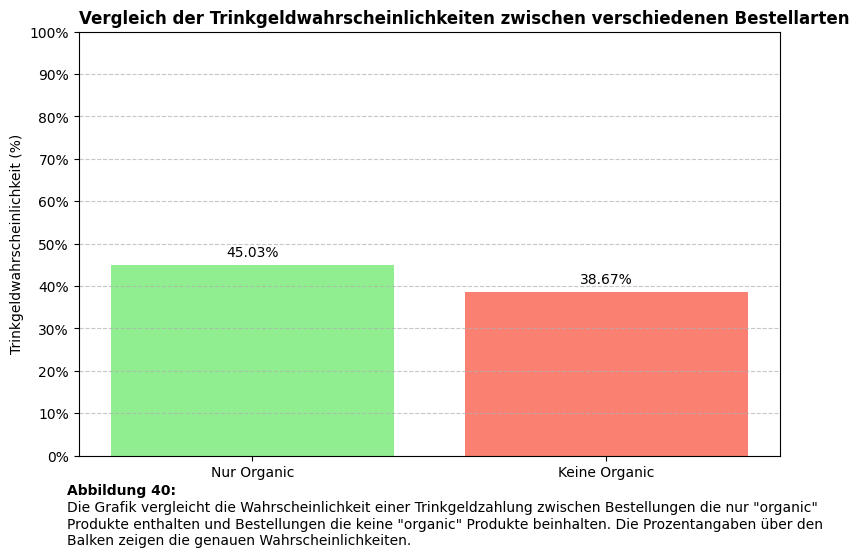

In [256]:
# plot code
categories = ['Nur Organic', 'Keine Organic']
values = [only_organic_tips, no_organic_tips]

# Plot erstellen
fig, ax = plt.subplots(figsize=(8, 5))
plt.subplots_adjust(left=0.08)

# Balkendiagramm erstellen
ax.bar(categories, values, color=['lightgreen', 'salmon'])

# Achsentitel und Formatierung
ax.set_ylabel('Trinkgeldwahrscheinlichkeit (%)')
ax.set_title('Vergleich der Trinkgeldwahrscheinlichkeiten zwischen verschiedenen Bestellarten', 
             loc='left', weight='bold')
ax.set_ylim(0, 1)
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories, rotation=0)
ax.set_yticks([i / 10 for i in range(0, 11)])
ax.set_yticklabels([f"{i * 10}%" for i in range(0, 11)])
ax.grid(True, axis='y', linestyle='--', alpha=0.7)


# Werte über den Balken anzeigen
for i, v in enumerate(values):
    ax.text(i, v + 0.02, f"{v:.2%}", ha='center', fontsize=10)

# Bildunterschrift
description = 'Die Grafik vergleicht die Wahrscheinlichkeit einer Trinkgeldzahlung zwischen Bestellungen die nur "organic" Produkte enthalten und Bestellungen die keine "organic" Produkte beinhalten. Die Prozentangaben über den Balken zeigen die genauen Wahrscheinlichkeiten.'
fig.text(0.09, 0, 'Abbildung 40:', weight='bold', ha='left')
fig.text(0.09, -0.095, description, wrap=True)

plt.tight_layout()
plt.show()

In [284]:
# chi² test code
only_organic_no_tips = only_organic_orders - only_organic_tips_abs
no_organic_no_tips = no_organic_orders - no_organic_tips_abs

observed = np.array([
    [only_organic_tips_abs, only_organic_no_tips],  
    [no_organic_tips_abs, no_organic_no_tips]       
])

row_labels = ['Bio-Produkte', 'Nicht-Bio-Produkte']
col_labels = ['Mit_Trinkgeld', 'Ohne_Trinkgeld']

# DataFrame erstellen
residuals_df = pd.DataFrame(
    observed,
    index=row_labels,
    columns=col_labels
)

In [285]:
# chi² code
chi2, p_value, dof, expected = chi2_contingency(observed)

# Testergebnisse in Tabelle formatieren
test_results = [
    ["Chi-Quadrat Statistik", f"{chi2}"],
    ["p-Wert", f"{p_value}"],
    ["Freiheitsgrade", dof]
]

print("\nChi-Quadrat Testergebnisse:")
print(tabulate(test_results, headers=["Metrik", "Wert"], 
              tablefmt="fancy_grid", numalign="right"))

alpha = 0.05
print("\nInterpretation:")
if p_value < alpha:
    interpretation = [
        ["Ergebnis", "Statistisch signifikanter Zusammenhang"],
        ["Begründung", f"p-Wert ({p_value}) < Signifikanzniveau ({alpha})"],
        ["Schlussfolgerung", "Department und Trinkgeldvergabe sind abhängig"]
    ]
else:
    interpretation = [
        ["Ergebnis", "Kein statistisch signifikanter Zusammenhang"],
        ["Begründung", f"p-Wert ({p_value}) > Signifikanzniveau ({alpha})"],
        ["Schlussfolgerung", "Department und Trinkgeldvergabe sind unabhängig"]
    ]

print(tabulate(interpretation, headers=["", ""], 
              tablefmt="fancy_grid"))



Chi-Quadrat Testergebnisse:
╒═══════════════════════╤══════════════╕
│ Metrik                │         Wert │
╞═══════════════════════╪══════════════╡
│ Chi-Quadrat Statistik │      630.013 │
├───────────────────────┼──────────────┤
│ p-Wert                │ 4.96485e-139 │
├───────────────────────┼──────────────┤
│ Freiheitsgrade        │            1 │
╘═══════════════════════╧══════════════╛

Interpretation:
╒══════════════════╤════════════════════════════════════════════════════════════╕
│                  │                                                            │
╞══════════════════╪════════════════════════════════════════════════════════════╡
│ Ergebnis         │ Statistisch signifikanter Zusammenhang                     │
├──────────────────┼────────────────────────────────────────────────────────────┤
│ Begründung       │ p-Wert (4.964845409064502e-139) < Signifikanzniveau (0.05) │
├──────────────────┼────────────────────────────────────────────────────────────┤
│ Schlussfo

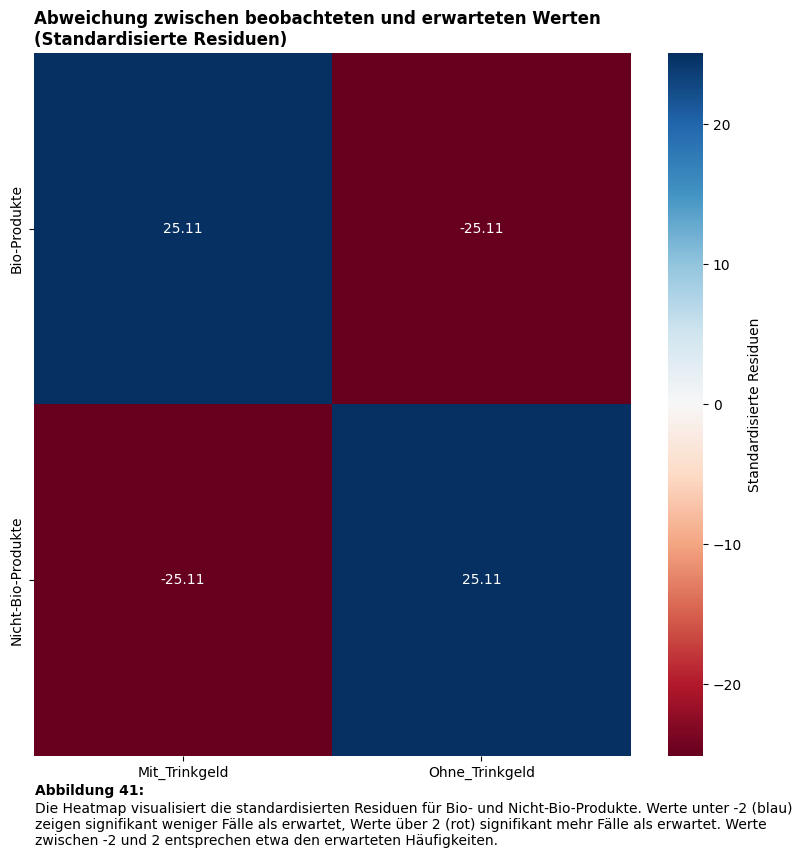

In [288]:
# plot code
chi2, p_value, dof, expected = chi2_contingency(observed)

# Korrigierte standardisierte Residuen berechnen
row_totals = observed.sum(axis=1)
col_totals = observed.sum(axis=0)
grand_total = observed.sum()

corrected_residuals = np.zeros_like(observed, dtype=float)
for i in range(observed.shape[0]):
    for j in range(observed.shape[1]):
        E = expected[i, j]
        O = observed[i, j]
        correction = np.sqrt((1 - row_totals[i]/grand_total) *
                           (1 - col_totals[j]/grand_total))
        corrected_residuals[i, j] = (O - E) / (np.sqrt(E) * correction)

# DataFrame für die Residuen erstellen
residuals_df = pd.DataFrame(
    corrected_residuals,
    index=row_labels,
    columns=col_labels
)

# Heatmap erstellen
fig, ax = plt.subplots(figsize=(8, 8))
plt.subplots_adjust(left=0.08)

sns.heatmap(residuals_df,
            annot=True,
            cmap='RdBu',
            center=0,
            fmt='.2f',
            cbar_kws={'label': 'Standardisierte Residuen'},
            ax=ax)

ax.set_title('Abweichung zwischen beobachteten und erwarteten Werten\n(Standardisierte Residuen)',
             loc='left',
             weight='bold')

description = 'Die Heatmap visualisiert die standardisierten Residuen für Bio- und Nicht-Bio-Produkte. Werte unter -2 (blau) zeigen signifikant weniger Fälle als erwartet, Werte über 2 (rot) signifikant mehr Fälle als erwartet. Werte zwischen -2 und 2 entsprechen etwa den erwarteten Häufigkeiten.'
fig.text(0.05, 0, 'Abbildung 41:', weight='bold', ha='left')
fig.text(0.05, -0.06, description, wrap=True)

plt.tight_layout()
plt.show()

### 2) Analyse des Trinkgeldverhaltens des Kunden

In [ ]:
# Benutzerstatistiken: Gesamtbestellungen, Bestellungen mit Trinkgeld und durchschnittliche Bestellgröße pro Benutzer
user_stats = (
    session.query(
        Order.user_id,
        func.count(Order.order_id).label('total_orders'), 
        func.sum(case((Order.tips == True, 1), else_=0)).label('orders_with_tips')  
    )
    .group_by(Order.user_id)
    .order_by(Order.user_id)
    .all()
)

avg_order_size_subquery = (
    session.query(
        Order.user_id,
        func.count(Einkaufskorb.product_id).label('order_size')
    )
    .join(Einkaufskorb, Order.order_id == Einkaufskorb.order_id)
    .group_by(Order.order_id)
).subquery()

avg_order_size = (
    session.query(
        avg_order_size_subquery.c.user_id,
        func.avg(avg_order_size_subquery.c.order_size).label('avg_order_size')
    )
    .group_by(avg_order_size_subquery.c.user_id)
    .order_by(avg_order_size_subquery.c.user_id)
    .all()
)

avg_order_size_df = pd.DataFrame(avg_order_size, columns=['user_id', 'avg_order_size'])

user_stats_df = pd.DataFrame(user_stats, columns=['user_id', 'total_orders', 'orders_with_tips'])

user_stats_df['orders_without_tips'] = user_stats_df['total_orders'] - user_stats_df['orders_with_tips']

user_stats_df = user_stats_df.merge(avg_order_size_df, on='user_id')

user_stats_df['order_group'] = pd.cut(user_stats_df['total_orders'], bins=range(1, 102, 10), right=False)
user_stats_df['item_count_group'] = pd.cut(user_stats_df['avg_order_size'], bins=range(1, 32, 3), right=False)

grouped_stats_df_item_count = user_stats_df.groupby('item_count_group', observed=True).agg(
    orders_with_tips=('orders_with_tips', 'sum'),
    orders_without_tips=('orders_without_tips', 'sum'),
    total_orders=('total_orders', 'sum')
).reset_index()

grouped_stats_df = user_stats_df.groupby('order_group', observed=True).agg(
    orders_with_tips=('orders_with_tips', 'sum'),
    orders_without_tips=('orders_without_tips', 'sum'),
    total_orders=('total_orders', 'sum')
).reset_index()

grouped_stats_df['tips_ratio'] = grouped_stats_df['orders_with_tips'] / grouped_stats_df['total_orders']
grouped_stats_df_item_count['tips_ratio'] = grouped_stats_df_item_count['orders_with_tips'] / grouped_stats_df_item_count['total_orders']
# 


In [299]:
grouped_stats_df

order_group  orders_with_tips  orders_without_tips  total_orders  tips_ratio
0     [1, 11)             89983               236698        326681    0.275446
1    [11, 21)            133246               226480        359726    0.370410
2    [21, 31)            122669               141444        264113    0.464457
3    [31, 41)            103809                88585        192394    0.539565
4    [41, 51)             91546                67904        159450    0.574136
5    [51, 61)             64700                49222        113922    0.567932
6    [61, 71)             39767                34737         74504    0.533757
7    [71, 81)             25089                25303         50392    0.497877
8    [81, 91)             19023                19412         38435    0.494940
9   [91, 101)             40281                53123         93404    0.431256

In [300]:
grouped_stats_df_item_count

item_count_group  orders_with_tips  orders_without_tips  total_orders  \
0           [1, 4)             65194               110654        175848   
1           [4, 7)            154210               199935        354145   
2          [7, 10)            185093               226977        412070   
3         [10, 13)            141483               170454        311937   
4         [13, 16)             84475               103825        188300   
5         [16, 19)             47323                59990        107313   
6         [19, 22)             26517                33158         59675   
7         [22, 25)             12662                18285         30947   
8         [25, 28)              6394                 9226         15620   
9         [28, 31)              3439                 5451          8890   

   tips_ratio  
0    0.370741  
1    0.435443  
2    0.449179  
3    0.453563  
4    0.448619  
5    0.440981  
6    0.444357  
7    0.409151  
8    0.409347  
9    0.386839

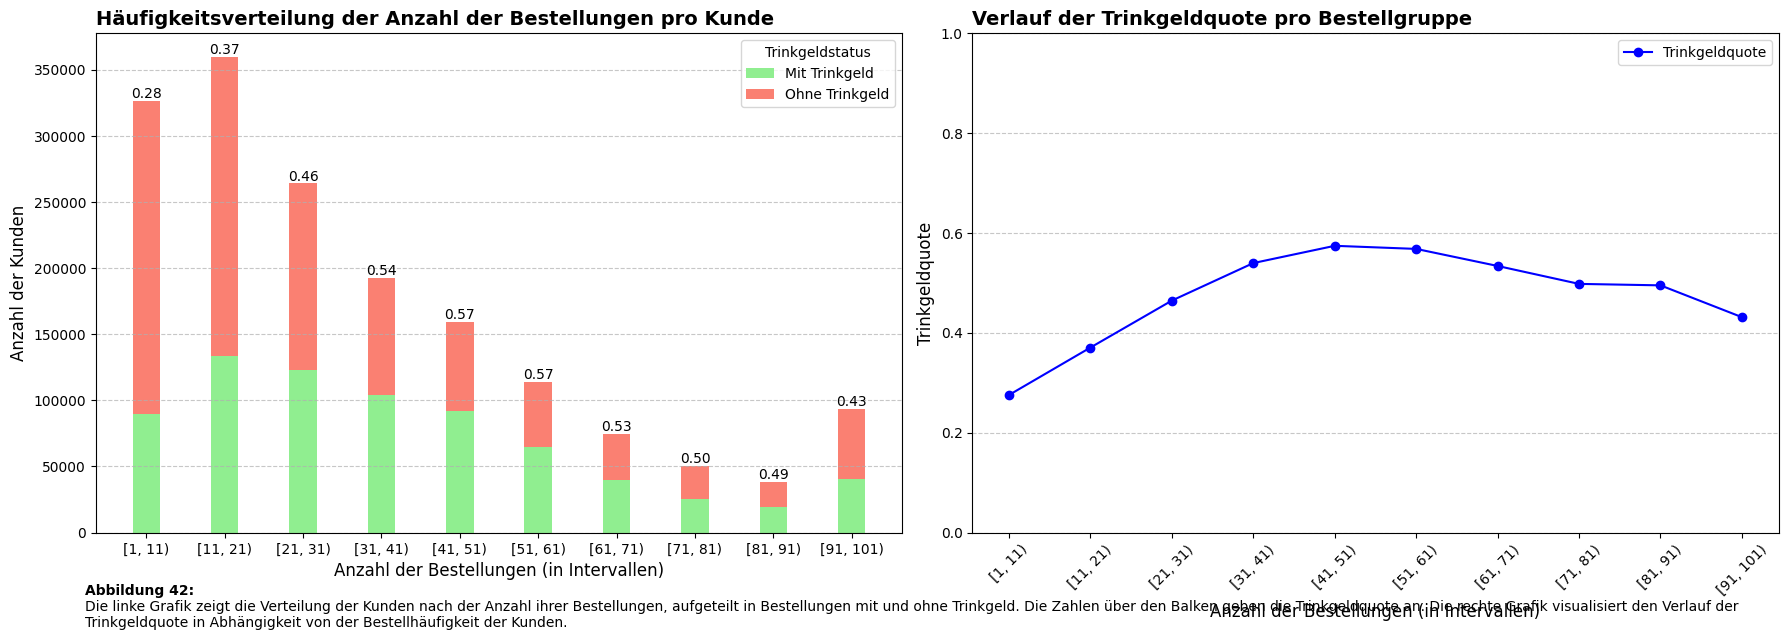

In [301]:
# plot code
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
plt.subplots_adjust(left=0.08)

# Linker Plot: Gestapelte Balkendiagramme
bars_with_tips = ax1.bar(grouped_stats_df['order_group'].astype(str), grouped_stats_df['orders_with_tips'], 
                         width=0.35, color='lightgreen', label='Mit Trinkgeld')
bars_without_tips = ax1.bar(grouped_stats_df['order_group'].astype(str), grouped_stats_df['orders_without_tips'], 
                            width=0.35, bottom=grouped_stats_df['orders_with_tips'], 
                            color='salmon', label='Ohne Trinkgeld')

# Quotienten anzeigen
for i, rect in enumerate(bars_with_tips):
    total_height = rect.get_height() + bars_without_tips[i].get_height()
    ratio = grouped_stats_df['tips_ratio'].iloc[i]
    ax1.text(rect.get_x() + rect.get_width() / 2, total_height + 2, 
             f'{ratio:.2f}', ha='center', va='bottom', fontsize=10)

# Formatierung linker Plot
ax1.set_title('Häufigkeitsverteilung der Anzahl der Bestellungen pro Kunde', 
              loc='left', weight='bold', fontsize=14)
ax1.set_xlabel('Anzahl der Bestellungen (in Intervallen)', fontsize=12)
ax1.set_ylabel('Anzahl der Kunden', fontsize=12)
ax1.legend(title='Trinkgeldstatus')
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)


# Rechter Plot: Liniendiagramm
ax2.plot(grouped_stats_df['order_group'].astype(str), grouped_stats_df['tips_ratio'], 
         marker='o', color='blue', label='Trinkgeldquote')
ax2.set_title('Verlauf der Trinkgeldquote pro Bestellgruppe', 
              loc='left', weight='bold', fontsize=14)
ax2.set_xlabel('Anzahl der Bestellungen (in Intervallen)', fontsize=12)
ax2.set_ylabel('Trinkgeldquote', fontsize=12)
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)


# Bildunterschrift
description = 'Die linke Grafik zeigt die Verteilung der Kunden nach der Anzahl ihrer Bestellungen, aufgeteilt in Bestellungen mit und ohne Trinkgeld. Die Zahlen über den Balken geben die Trinkgeldquote an. Die rechte Grafik visualisiert den Verlauf der Trinkgeldquote in Abhängigkeit von der Bestellhäufigkeit der Kunden.'
fig.text(0.05, 0, 'Abbildung 42:', weight='bold', ha='left')
fig.text(0.05, -0.05, description, wrap=True)

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [302]:
# Stelle sicher, dass 'order_group' eine reguläre Spalte ist (nicht der Index)
grouped_stats_df.reset_index(inplace=True)

# Setze 'order_group' als Index
crosstab = grouped_stats_df.set_index('order_group')[['orders_with_tips', 'orders_without_tips']]


In [303]:
# chi² test code
chi2, p, dof, expected = chi2_contingency(crosstab)

test_results = [
    ["Chi-Quadrat Statistik", f"{chi2}"],
    ["p-Wert", f"{p_value}"],
    ["Freiheitsgrade", dof]
]

print("\nChi-Quadrat Testergebnisse:")
print(tabulate(test_results, headers=["Metrik", "Wert"], 
              tablefmt="fancy_grid", numalign="right"))

alpha = 0.05
print("\nInterpretation:")
if p_value < alpha:
    interpretation = [
        ["Ergebnis", "Statistisch signifikanter Zusammenhang"],
        ["Begründung", f"p-Wert ({p_value}) < Signifikanzniveau ({alpha})"],
        ["Schlussfolgerung", "Department und Trinkgeldvergabe sind abhängig"]
    ]
else:
    interpretation = [
        ["Ergebnis", "Kein statistisch signifikanter Zusammenhang"],
        ["Begründung", f"p-Wert ({p_value}) > Signifikanzniveau ({alpha})"],
        ["Schlussfolgerung", "Department und Trinkgeldvergabe sind unabhängig"]
    ]

print(tabulate(interpretation, headers=["", ""], 
              tablefmt="fancy_grid"))



Chi-Quadrat Testergebnisse:
╒═══════════════════════╤═════════╕
│ Metrik                │    Wert │
╞═══════════════════════╪═════════╡
│ Chi-Quadrat Statistik │ 74451.7 │
├───────────────────────┼─────────┤
│ p-Wert                │       0 │
├───────────────────────┼─────────┤
│ Freiheitsgrade        │       9 │
╘═══════════════════════╧═════════╛

Interpretation:
╒══════════════════╤═══════════════════════════════════════════════╕
│                  │                                               │
╞══════════════════╪═══════════════════════════════════════════════╡
│ Ergebnis         │ Statistisch signifikanter Zusammenhang        │
├──────────────────┼───────────────────────────────────────────────┤
│ Begründung       │ p-Wert (0.0) < Signifikanzniveau (0.05)       │
├──────────────────┼───────────────────────────────────────────────┤
│ Schlussfolgerung │ Department und Trinkgeldvergabe sind abhängig │
╘══════════════════╧═══════════════════════════════════════════════╛


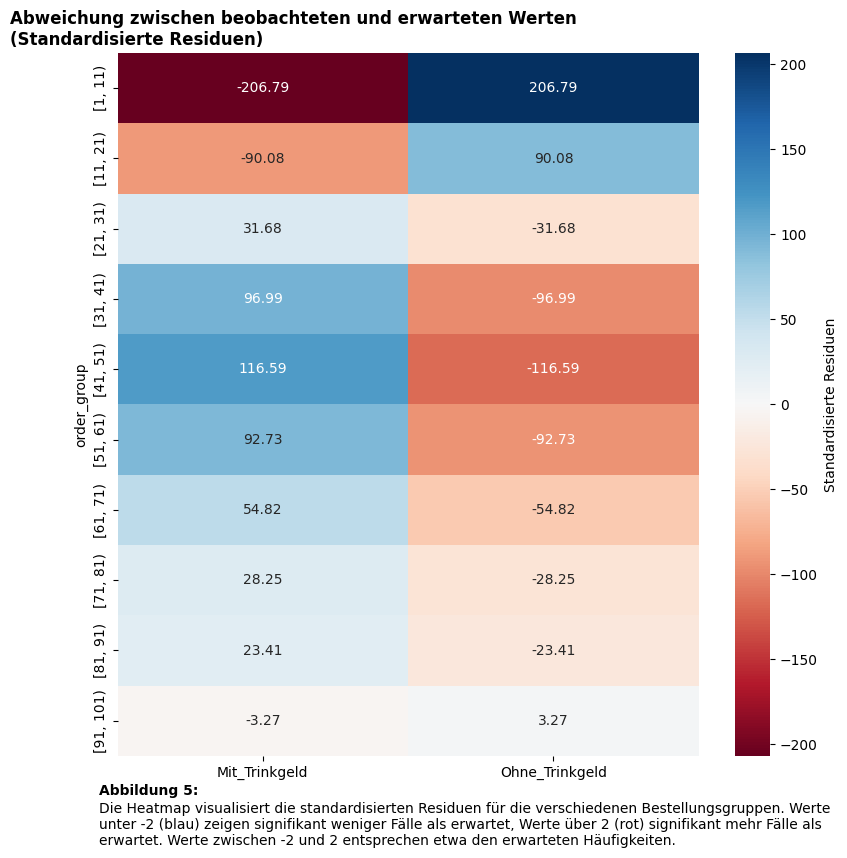

In [304]:
# plot code
observed = crosstab[['orders_with_tips', 'orders_without_tips']].values

chi2, p_value, dof, expected = chi2_contingency(observed)

row_totals = observed.sum(axis=1)
col_totals = observed.sum(axis=0)
grand_total = observed.sum()

corrected_residuals = np.zeros_like(observed, dtype=float)
for i in range(observed.shape[0]):
    for j in range(observed.shape[1]):
        E = expected[i, j]
        O = observed[i, j]
        correction = np.sqrt((1 - row_totals[i]/grand_total) *
                           (1 - col_totals[j]/grand_total))
        corrected_residuals[i, j] = (O - E) / (np.sqrt(E) * correction)

residuals_df = pd.DataFrame(
    corrected_residuals,
    index=crosstab.index,  
    columns=['Mit_Trinkgeld', 'Ohne_Trinkgeld']
)

fig, ax = plt.subplots(figsize=(8, 8))
plt.subplots_adjust(left=0.08)

sns.heatmap(residuals_df,
            annot=True,
            cmap='RdBu',
            center=0,
            fmt='.2f',
            cbar_kws={'label': 'Standardisierte Residuen'},
            ax=ax)

ax.set_title('Abweichung zwischen beobachteten und erwarteten Werten\n(Standardisierte Residuen)',
             loc='left',
             weight='bold',
             x=-0.185)

description = 'Die Heatmap visualisiert die standardisierten Residuen für die verschiedenen Bestellungsgruppen. Werte unter -2 (blau) zeigen signifikant weniger Fälle als erwartet, Werte über 2 (rot) signifikant mehr Fälle als erwartet. Werte zwischen -2 und 2 entsprechen etwa den erwarteten Häufigkeiten.'
fig.text(0.05, 0, 'Abbildung 5:', weight='bold', ha='left')
fig.text(0.05, -0.06, description, wrap=True)

plt.tight_layout()
plt.show()

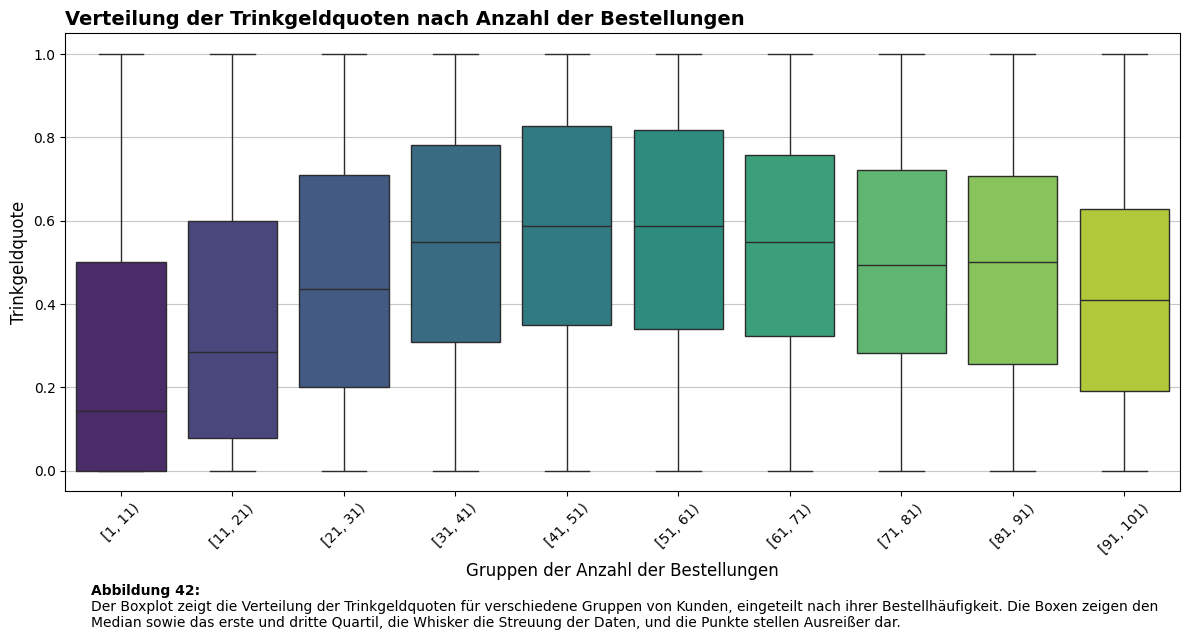

/tmp/ipykernel_12741/2661236874.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = user_stats_df.groupby('order_group')['tip_ratio'].describe().reset_index()


| order_group   |   count |     mean |      std |   min |       25% |      50% |      75% |   max |
|:--------------|--------:|---------:|---------:|------:|----------:|---------:|---------:|------:|
| [1, 11)       |   53685 | 0.268971 | 0.329745 |     0 | 0         | 0.142857 | 0.5      |     1 |
| [11, 21)      |   24482 | 0.364814 | 0.319921 |     0 | 0.0785256 | 0.285714 | 0.6      |     1 |
| [21, 31)      |   10618 | 0.461799 | 0.306749 |     0 | 0.2       | 0.434783 | 0.708333 |     1 |
| [31, 41)      |    5491 | 0.538614 | 0.297895 |     0 | 0.307692  | 0.548387 | 0.78125  |     1 |
| [41, 51)      |    3537 | 0.57336  | 0.295694 |     0 | 0.348837  | 0.586957 | 0.826087 |     1 |
| [51, 61)      |    2072 | 0.56848  | 0.294252 |     0 | 0.339286  | 0.586207 | 0.818182 |     1 |
| [61, 71)      |    1147 | 0.534291 | 0.285655 |     0 | 0.322581  | 0.548387 | 0.757576 |     1 |
| [71, 81)      |     669 | 0.497768 | 0.279148 |     0 | 0.28169   | 0.493506 | 0.722222 |     1 |
| [81, 91)      |     452 | 0.49548  | 0.288117 |     0 | 0.255962  | 0.5      | 0.708224 |     1 |
| [91, 101)     |     951 | 0.431953 | 0.280161 |     0 | 0.191919  | 0.41     | 0.628263 |     1 |

In [319]:
# plot code
user_stats_df['order_group'] = pd.cut(
    user_stats_df['total_orders'],
    bins=range(1, 102, 10),
    right=False  
)

user_stats_df['tip_ratio'] = user_stats_df['orders_with_tips'] / user_stats_df['total_orders']

fig, ax = plt.subplots(figsize=(12, 6))
plt.subplots_adjust(left=0.08)

sns.boxplot(
    data=user_stats_df,
    x='order_group', 
    y='tip_ratio', 
    palette='viridis',
    hue='order_group',
    legend=False,
    ax=ax
)

ax.set_title('Verteilung der Trinkgeldquoten nach Anzahl der Bestellungen', 
             loc='left', weight='bold', fontsize=14)
ax.set_xlabel('Gruppen der Anzahl der Bestellungen', fontsize=12)
ax.set_ylabel('Trinkgeldquote', fontsize=12)
ax.set_xticks(range(len(ax.get_xticklabels())))
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.7)

description = 'Der Boxplot zeigt die Verteilung der Trinkgeldquoten für verschiedene Gruppen von Kunden, eingeteilt nach ihrer Bestellhäufigkeit. Die Boxen zeigen den Median sowie das erste und dritte Quartil, die Whisker die Streuung der Daten, und die Punkte stellen Ausreißer dar.'
fig.text(0.08, 0, 'Abbildung 42:', weight='bold', ha='left')
fig.text(0.08, -0.05, description, wrap=True)

plt.tight_layout()
plt.show()

summary_stats = user_stats_df.groupby('order_group')['tip_ratio'].describe().reset_index()
markdown_table = tabulate(summary_stats, headers='keys', tablefmt='pipe', showindex=False)

display(Markdown(markdown_table))


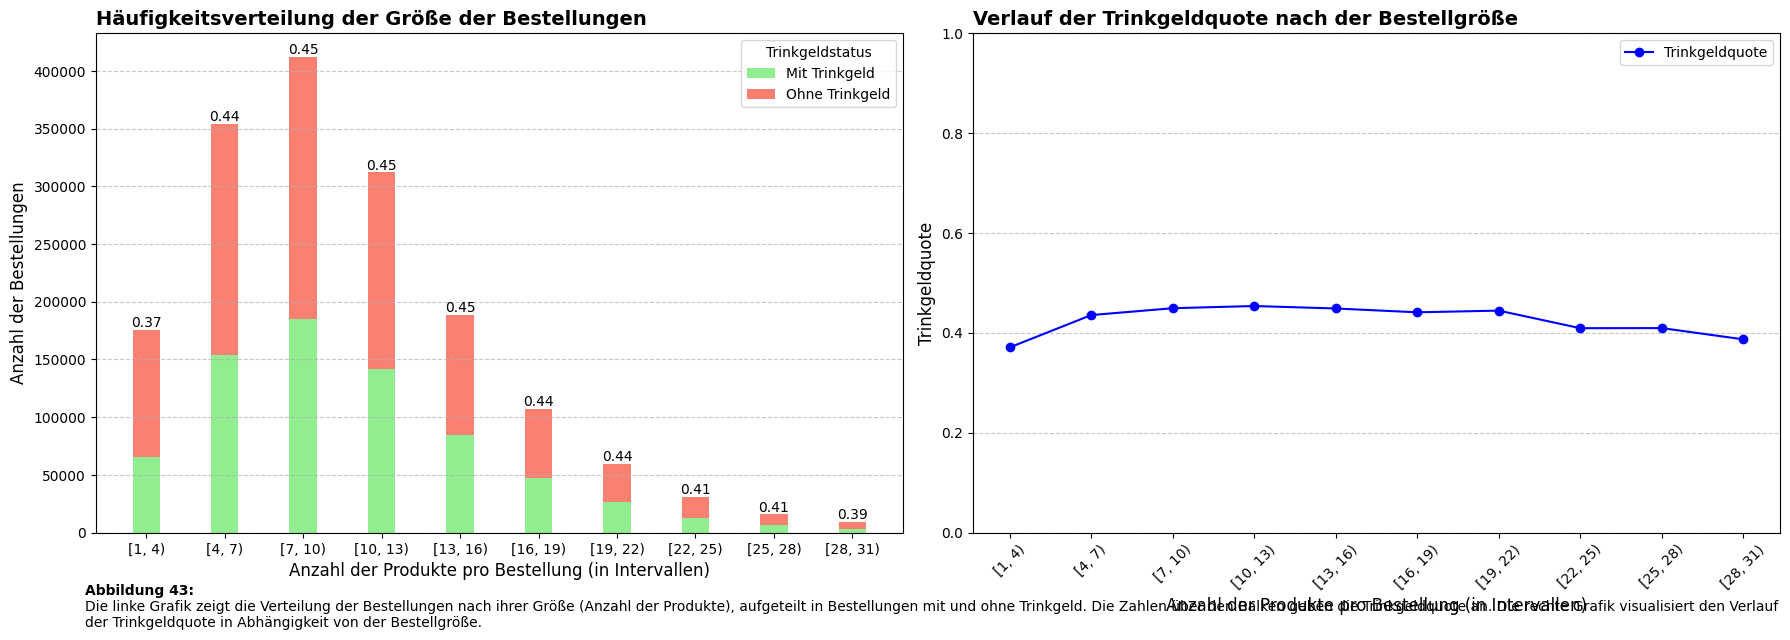

In [306]:
# plot code
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
plt.subplots_adjust(left=0.08)

bars_with_tips = ax1.bar(grouped_stats_df_item_count['item_count_group'].astype(str), 
                        grouped_stats_df_item_count['orders_with_tips'], 
                        width=0.35, color='lightgreen', label='Mit Trinkgeld')
bars_without_tips = ax1.bar(grouped_stats_df_item_count['item_count_group'].astype(str), 
                           grouped_stats_df_item_count['orders_without_tips'], 
                           width=0.35, bottom=grouped_stats_df_item_count['orders_with_tips'], 
                           color='salmon', label='Ohne Trinkgeld')

for i, rect in enumerate(bars_with_tips):
    total_height = rect.get_height() + bars_without_tips[i].get_height()
    ratio = grouped_stats_df_item_count['tips_ratio'].iloc[i]
    ax1.text(rect.get_x() + rect.get_width() / 2, total_height + 2, 
             f'{ratio:.2f}', ha='center', va='bottom', fontsize=10)

ax1.set_title('Häufigkeitsverteilung der Größe der Bestellungen', 
              loc='left', weight='bold', fontsize=14)
ax1.set_xlabel('Anzahl der Produkte pro Bestellung (in Intervallen)', fontsize=12)
ax1.set_ylabel('Anzahl der Bestellungen', fontsize=12)
ax1.legend(title='Trinkgeldstatus')
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

ax2.plot(grouped_stats_df_item_count['item_count_group'].astype(str), 
         grouped_stats_df_item_count['tips_ratio'], 
         marker='o', color='blue', label='Trinkgeldquote')
ax2.set_title('Verlauf der Trinkgeldquote nach der Bestellgröße', 
              loc='left', weight='bold', fontsize=14)
ax2.set_xlabel('Anzahl der Produkte pro Bestellung (in Intervallen)', fontsize=12)
ax2.set_ylabel('Trinkgeldquote', fontsize=12)
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)


description = 'Die linke Grafik zeigt die Verteilung der Bestellungen nach ihrer Größe (Anzahl der Produkte), aufgeteilt in Bestellungen mit und ohne Trinkgeld. Die Zahlen über den Balken geben die Trinkgeldquote an. Die rechte Grafik visualisiert den Verlauf der Trinkgeldquote in Abhängigkeit von der Bestellgröße.'
fig.text(0.05, 0, 'Abbildung 43:', weight='bold', ha='left')
fig.text(0.05, -0.05, description, wrap=True)

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [307]:
# Stelle sicher, dass 'order_group' eine reguläre Spalte ist (nicht der Index)
grouped_stats_df_item_count.reset_index(inplace=True)

# Setze 'order_group' als Index
crosstab = grouped_stats_df_item_count.set_index('item_count_group')[['orders_with_tips', 'orders_without_tips']]

In [308]:
# chi² code
chi2, p_value, dof, expected = chi2_contingency(crosstab)

test_results = [
    ["Chi-Quadrat Statistik", f"{chi2}"],
    ["p-Wert", f"{p_value}"],
    ["Freiheitsgrade", dof]
]

print("\nChi-Quadrat Testergebnisse:")
print(tabulate(test_results, headers=["Metrik", "Wert"], 
              tablefmt="fancy_grid", numalign="right"))

alpha = 0.05
print("\nInterpretation:")
if p_value < alpha:
    interpretation = [
        ["Ergebnis", "Statistisch signifikanter Zusammenhang"],
        ["Begründung", f"p-Wert ({p_value}) < Signifikanzniveau ({alpha})"],
        ["Schlussfolgerung", "Anzahl der Bestellungen und Trinkgeldvergabe sind abhängig"]
    ]
else:
    interpretation = [
        ["Ergebnis", "Kein statistisch signifikanter Zusammenhang"],
        ["Begründung", f"p-Wert ({p_value}) > Signifikanzniveau ({alpha})"],
        ["Schlussfolgerung", "Anzahl der Bestellungen und Trinkgeldvergabe sind unabhängig"]
    ]

print(tabulate(interpretation, headers=["", ""], 
              tablefmt="fancy_grid"))



Chi-Quadrat Testergebnisse:
╒═══════════════════════╤════════╕
│ Metrik                │   Wert │
╞═══════════════════════╪════════╡
│ Chi-Quadrat Statistik │ 4097.7 │
├───────────────────────┼────────┤
│ p-Wert                │      0 │
├───────────────────────┼────────┤
│ Freiheitsgrade        │      9 │
╘═══════════════════════╧════════╛

Interpretation:
╒══════════════════╤════════════════════════════════════════════════════════════╕
│                  │                                                            │
╞══════════════════╪════════════════════════════════════════════════════════════╡
│ Ergebnis         │ Statistisch signifikanter Zusammenhang                     │
├──────────────────┼────────────────────────────────────────────────────────────┤
│ Begründung       │ p-Wert (0.0) < Signifikanzniveau (0.05)                    │
├──────────────────┼────────────────────────────────────────────────────────────┤
│ Schlussfolgerung │ Anzahl der Bestellungen und Trinkgeldvergabe

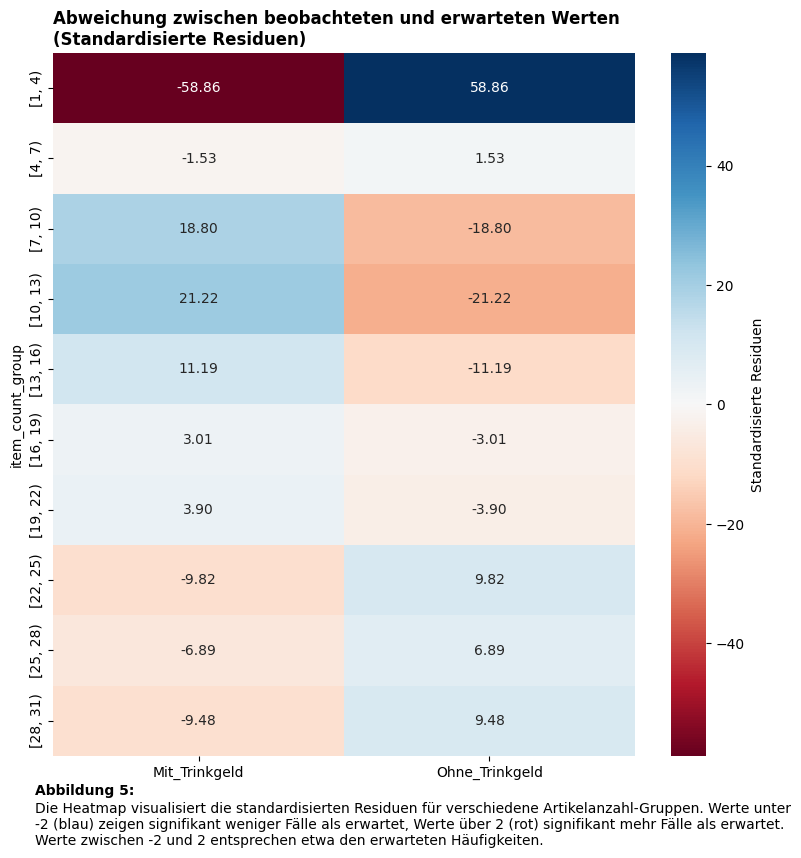

In [311]:
# plot code
observed = crosstab[['orders_with_tips', 'orders_without_tips']].values

# Chi-Quadrat-Test durchführen
chi2, p_value, dof, expected = chi2_contingency(observed)

# Korrigierte standardisierte Residuen berechnen
row_totals = observed.sum(axis=1)
col_totals = observed.sum(axis=0)
grand_total = observed.sum()

corrected_residuals = np.zeros_like(observed, dtype=float)
for i in range(observed.shape[0]):
    for j in range(observed.shape[1]):
        E = expected[i, j]
        O = observed[i, j]
        correction = np.sqrt((1 - row_totals[i]/grand_total) *
                           (1 - col_totals[j]/grand_total))
        corrected_residuals[i, j] = (O - E) / (np.sqrt(E) * correction)

# DataFrame für die Residuen erstellen
residuals_df = pd.DataFrame(
    corrected_residuals,
    index=crosstab.index,  # Verwendet die Artikelanzahl-Gruppen als Index
    columns=['Mit_Trinkgeld', 'Ohne_Trinkgeld']
)

# Heatmap erstellen
fig, ax = plt.subplots(figsize=(8, 8))
plt.subplots_adjust(left=0.08)

sns.heatmap(residuals_df,
            annot=True,
            cmap='RdBu',
            center=0,
            fmt='.2f',
            cbar_kws={'label': 'Standardisierte Residuen'},
            ax=ax)

ax.set_title('Abweichung zwischen beobachteten und erwarteten Werten\n(Standardisierte Residuen)',
             loc='left',
             weight='bold')

description = 'Die Heatmap visualisiert die standardisierten Residuen für verschiedene Artikelanzahl-Gruppen. Werte unter -2 (blau) zeigen signifikant weniger Fälle als erwartet, Werte über 2 (rot) signifikant mehr Fälle als erwartet. Werte zwischen -2 und 2 entsprechen etwa den erwarteten Häufigkeiten.'
fig.text(0.05, 0, 'Abbildung 5:', weight='bold', ha='left')
fig.text(0.05, -0.06, description, wrap=True)

plt.tight_layout()
plt.show()

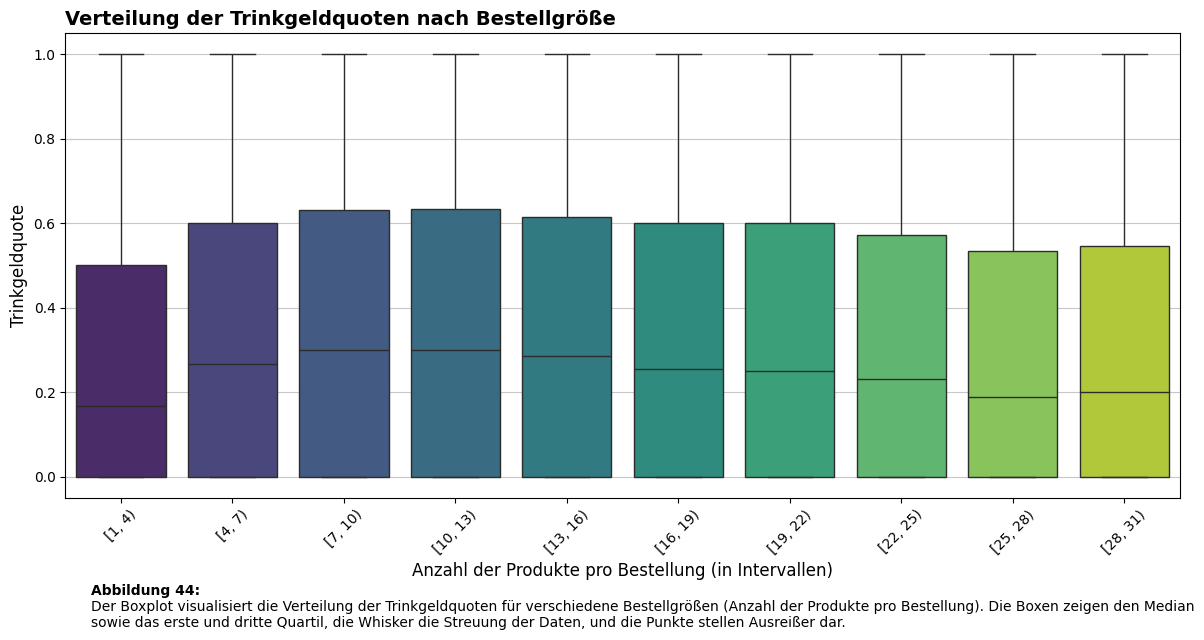

/tmp/ipykernel_12741/280523961.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = user_stats_df.groupby('item_count_group')['tip_ratio'].describe().reset_index()


| item_count_group   |   count |     mean |      std |   min |   25% |      50% |      75% |   max |
|:-------------------|--------:|---------:|---------:|------:|------:|---------:|---------:|------:|
| [1, 4)             |   13178 | 0.290442 | 0.331754 |     0 |     0 | 0.166667 | 0.5      |     1 |
| [4, 7)             |   21991 | 0.351854 | 0.336874 |     0 |     0 | 0.266667 | 0.6      |     1 |
| [7, 10)            |   23822 | 0.367149 | 0.334939 |     0 |     0 | 0.3      | 0.631579 |     1 |
| [10, 13)           |   18155 | 0.369306 | 0.334755 |     0 |     0 | 0.3      | 0.634146 |     1 |
| [13, 16)           |   11259 | 0.359589 | 0.333961 |     0 |     0 | 0.285714 | 0.615385 |     1 |
| [16, 19)           |    6649 | 0.349186 | 0.332531 |     0 |     0 | 0.255102 | 0.6      |     1 |
| [19, 22)           |    3759 | 0.345208 | 0.336782 |     0 |     0 | 0.25     | 0.6      |     1 |
| [22, 25)           |    2022 | 0.322679 | 0.329247 |     0 |     0 | 0.230769 | 0.571429 |     1 |
| [25, 28)           |    1077 | 0.302422 | 0.330092 |     0 |     0 | 0.1875   | 0.533333 |     1 |
| [28, 31)           |     607 | 0.307518 | 0.328821 |     0 |     0 | 0.2      | 0.545455 |     1 |

In [315]:
# plot code
user_stats_df['item_count_group'] = pd.cut(
    user_stats_df['avg_order_size'],
    bins=range(1, 32, 3),
    right=False  
)

user_stats_df['tip_ratio'] = user_stats_df['orders_with_tips'] / user_stats_df['total_orders']

fig, ax = plt.subplots(figsize=(12, 6))
plt.subplots_adjust(left=0.08)

sns.boxplot(
    data=user_stats_df,
    x='item_count_group', 
    y='tip_ratio', 
    palette='viridis',
    hue='item_count_group',
    legend=False,
    ax=ax
)

ax.set_title('Verteilung der Trinkgeldquoten nach Bestellgröße', 
             loc='left', weight='bold', fontsize=14)
ax.set_xlabel('Anzahl der Produkte pro Bestellung (in Intervallen)', fontsize=12)
ax.set_ylabel('Trinkgeldquote', fontsize=12)
ax.set_xticks(range(len(ax.get_xticklabels())))
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.7)

description = 'Der Boxplot visualisiert die Verteilung der Trinkgeldquoten für verschiedene Bestellgrößen (Anzahl der Produkte pro Bestellung). Die Boxen zeigen den Median sowie das erste und dritte Quartil, die Whisker die Streuung der Daten, und die Punkte stellen Ausreißer dar.'
fig.text(0.08, 0, 'Abbildung 44:', weight='bold', ha='left')
fig.text(0.08, -0.05, description, wrap=True)

plt.tight_layout()
plt.show()

summary_stats = user_stats_df.groupby('item_count_group')['tip_ratio'].describe().reset_index()
markdown_table = tabulate(summary_stats, headers='keys', tablefmt='pipe', showindex=False)

display(Markdown(markdown_table))


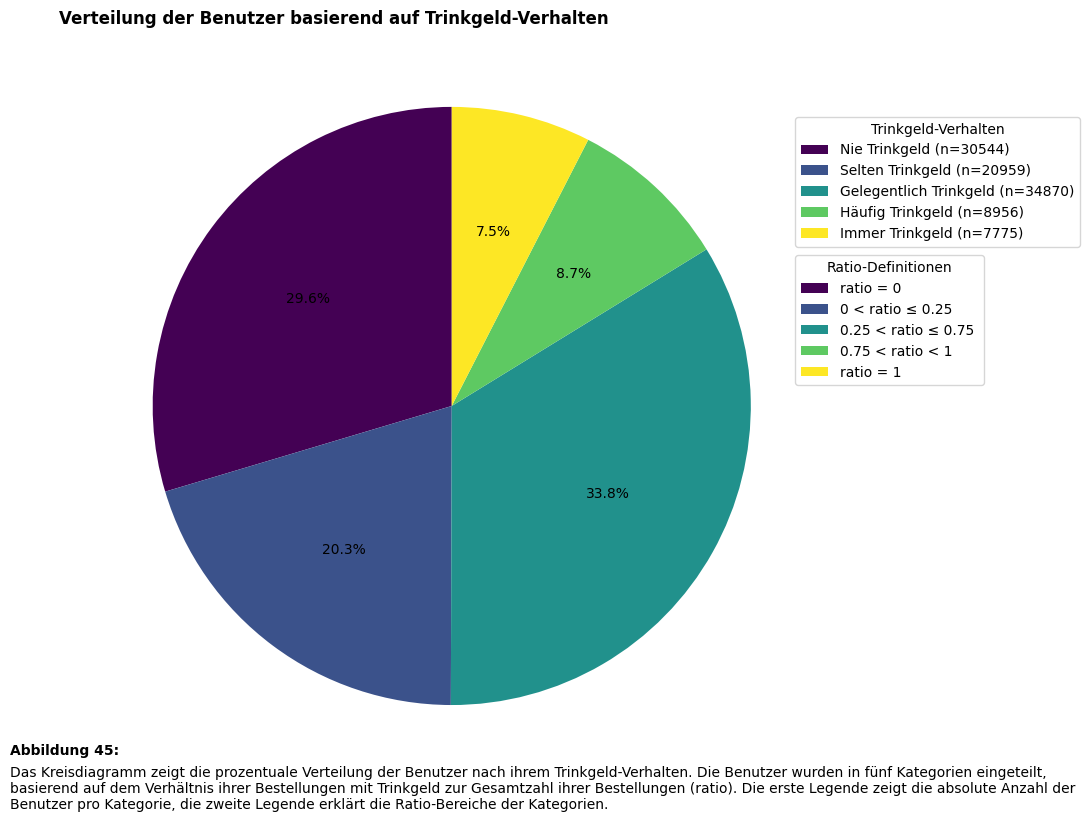

In [312]:
# plot code
def categorize_tip_ratio(ratio):
    if ratio == 0:
        return "Nie Trinkgeld"
    elif ratio == 1:
        return "Immer Trinkgeld"
    elif ratio <= 0.25:
        return "Selten Trinkgeld"
    elif ratio <= 0.75:
        return "Gelegentlich Trinkgeld"
    elif ratio < 1.0:
        return "Häufig Trinkgeld"
    else:
        return "immer Trinkgeld"

user_stats_df['tip_category'] = user_stats_df['tip_ratio'].apply(categorize_tip_ratio)

tip_category_counts = user_stats_df['tip_category'].value_counts()

fig, ax = plt.subplots(figsize=(12, 8))
plt.subplots_adjust(left=0.08)

category_order = ["Nie Trinkgeld", "Selten Trinkgeld", "Gelegentlich Trinkgeld", 
                 "Häufig Trinkgeld", "Immer Trinkgeld"]

tip_category_counts = tip_category_counts.reindex(category_order)

colors = plt.cm.viridis(np.linspace(0, 1, len(category_order)))

wedges, texts, autotexts = ax.pie(
    tip_category_counts.values,
    labels=None,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90)

ax.set_title('Verteilung der Benutzer basierend auf Trinkgeld-Verhalten', 
             loc='left', weight='bold', x=-0.025)

legend_elements_1 = [
    Patch(facecolor=colors[i], label=f"{cat} (n={tip_category_counts[cat]})")
    for i, cat in enumerate(category_order)
]

legend_1 = ax.legend(
    handles=legend_elements_1,
    title="Trinkgeld-Verhalten",
    loc="center left",
    bbox_to_anchor=(0.95, 0.8),
    frameon=True
)

ratio_explanations = [
    "ratio = 0".ljust(20),
    "0 < ratio ≤ 0.25".ljust(20),
    "0.25 < ratio ≤ 0.75".ljust(20),
    "0.75 < ratio < 1".ljust(20),
    "ratio = 1".ljust(20)
]

legend_elements_2 = [
    Patch(facecolor=colors[i], label=exp) 
    for i, exp in enumerate(ratio_explanations)
]

legend_2 = ax.legend(
    handles=legend_elements_2,
    title="Ratio-Definitionen",
    loc='center left',
    bbox_to_anchor=(0.95, 0.615),
    frameon=True
)

ax.add_artist(legend_1)

description = 'Das Kreisdiagramm zeigt die prozentuale Verteilung der Benutzer nach ihrem Trinkgeld-Verhalten. Die Benutzer wurden in fünf Kategorien eingeteilt, basierend auf dem Verhältnis ihrer Bestellungen mit Trinkgeld zur Gesamtzahl ihrer Bestellungen (ratio). Die erste Legende zeigt die absolute Anzahl der Benutzer pro Kategorie, die zweite Legende erklärt die Ratio-Bereiche der Kategorien.'
fig.text(0.1, 0.05, 'Abbildung 45:', weight='bold', ha='left')
fig.text(0.1, -0.015, description, wrap=True)

plt.tight_layout()
plt.show()

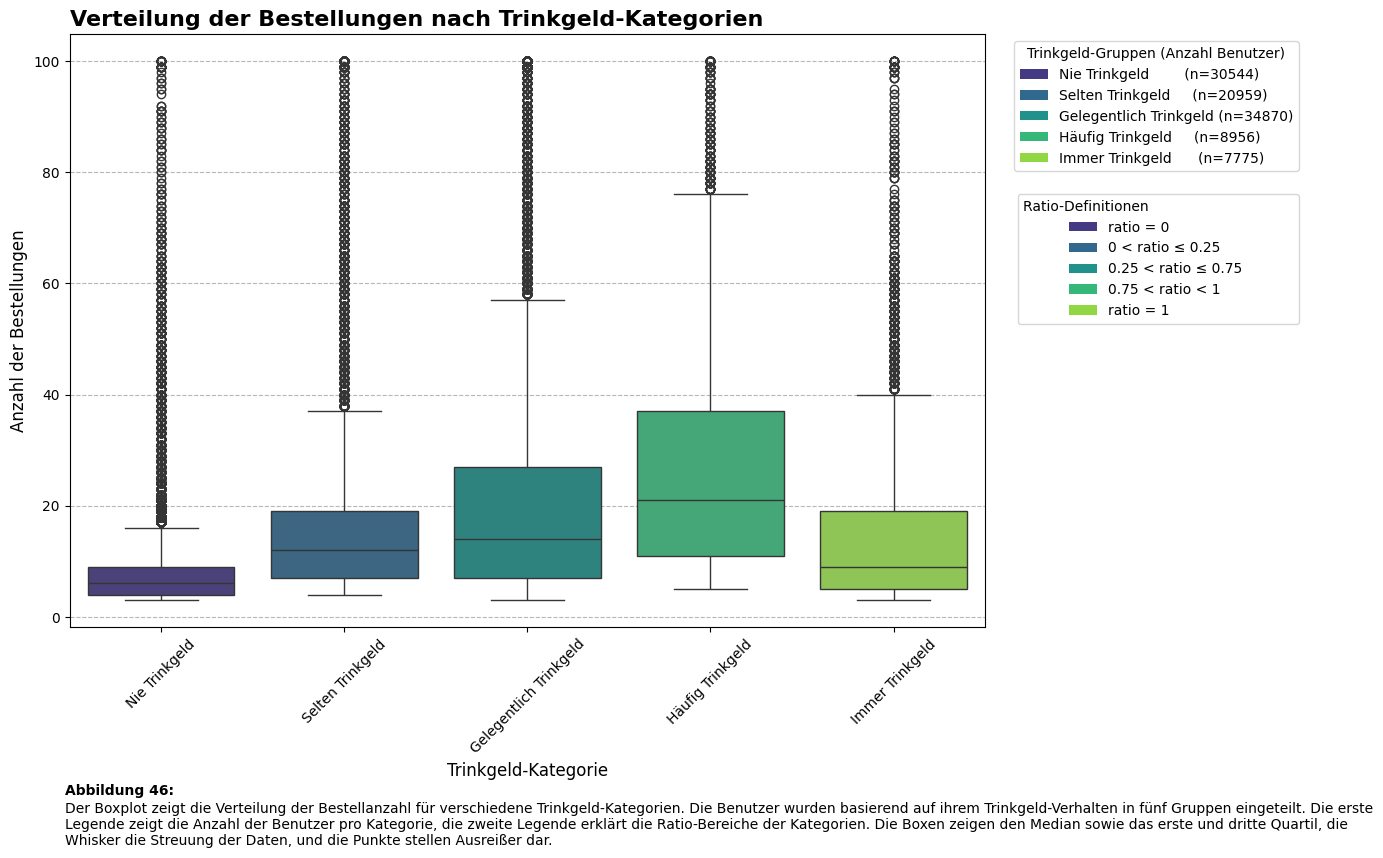

/tmp/ipykernel_12741/127993441.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = user_stats_df.groupby('tip_category')['total_orders'].describe().reset_index()


| tip_category           |   count |     mean |      std |   min |   25% |   50% |   75% |   max |
|:-----------------------|--------:|---------:|---------:|------:|------:|------:|------:|------:|
| Nie Trinkgeld          |   30544 |  8.42267 |  8.31828 |     3 |     4 |     6 |     9 |   100 |
| Selten Trinkgeld       |   20959 | 16.1157  | 15.583   |     4 |     7 |    12 |    19 |   100 |
| Gelegentlich Trinkgeld |   34870 | 20.8696  | 19.0922  |     3 |     7 |    14 |    27 |   100 |
| Häufig Trinkgeld       |    8956 | 25.9238  | 19.3059  |     5 |    11 |    21 |    37 |   100 |
| Immer Trinkgeld        |    7775 | 15.1888  | 15.5573  |     3 |     5 |     9 |    19 |   100 |

In [314]:
# plot code
category_order = ["Nie Trinkgeld", "Selten Trinkgeld", "Gelegentlich Trinkgeld", 
                  "Häufig Trinkgeld", "Immer Trinkgeld"]

group_counts = user_stats_df['tip_category'].value_counts()

user_stats_df['tip_category'] = pd.Categorical(user_stats_df['tip_category'], categories=category_order, ordered=True)
user_stats_df = user_stats_df.sort_values(by='tip_category')

fig, ax = plt.subplots(figsize=(14, 8))
plt.subplots_adjust(left=0.08)

sns.boxplot(
    data=user_stats_df,
    x='tip_category',
    y='total_orders',
    order=category_order,
    palette='viridis',
    ax=ax,
    hue='tip_category'
)

ax.set_title('Verteilung der Bestellungen nach Trinkgeld-Kategorien', 
             loc='left', weight='bold', fontsize=16)
ax.set_xlabel('Trinkgeld-Kategorie', fontsize=12)
ax.set_ylabel('Anzahl der Bestellungen', fontsize=12)
ax.set_xticks(range(len(ax.get_xticklabels())))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

legend_elements_1 = [
    Patch(facecolor=sns.color_palette('viridis', len(category_order))[i], 
          label=f"{cat.ljust(20)} (n={group_counts[cat]:<3})")
    for i, cat in enumerate(category_order)
]

legend_1 = ax.legend(
    handles=legend_elements_1,
    title="Trinkgeld-Gruppen (Anzahl Benutzer)".ljust(20),
    loc='upper right',
    bbox_to_anchor=(1.35, 1),
    frameon=True
)

ratio_explanations = [
    "ratio = 0".ljust(20),
    "0 < ratio ≤ 0.25".ljust(20),
    "0.25 < ratio ≤ 0.75".ljust(20),
    "0.75 < ratio < 1".ljust(20),
    "ratio = 1".ljust(20)
]

legend_elements_2 = [
    Patch(facecolor=sns.color_palette('viridis', len(ratio_explanations))[i], label=exp) 
    for i, exp in enumerate(ratio_explanations)
]

legend_2 = ax.legend(
    handles=legend_elements_2,
    title="Ratio-Definitionen".ljust(51),
    loc='lower right',
    bbox_to_anchor=(1.35, 0.5),
    frameon=True
)

ax.add_artist(legend_1)
ax.grid(axis='y', linestyle='--', alpha=0.9)

description = 'Der Boxplot zeigt die Verteilung der Bestellanzahl für verschiedene Trinkgeld-Kategorien. Die Benutzer wurden basierend auf ihrem Trinkgeld-Verhalten in fünf Gruppen eingeteilt. Die erste Legende zeigt die Anzahl der Benutzer pro Kategorie, die zweite Legende erklärt die Ratio-Bereiche der Kategorien. Die Boxen zeigen den Median sowie das erste und dritte Quartil, die Whisker die Streuung der Daten, und die Punkte stellen Ausreißer dar.'
fig.text(0.05, 0, 'Abbildung 46:', weight='bold', ha='left')
fig.text(0.05, -0.06, description, wrap=True)

plt.tight_layout()
plt.show()

summary_stats = user_stats_df.groupby('tip_category')['total_orders'].describe().reset_index()
markdown_table = tabulate(summary_stats, headers='keys', tablefmt='pipe', showindex=False)

display(Markdown(markdown_table))


In [9]:
# show df
category_order = ["Nie Trinkgeld", "Selten Trinkgeld", "Gelegentlich Trinkgeld", 
                  "Häufig Trinkgeld", "Immer Trinkgeld"]

group_counts = user_stats_df['tip_category'].value_counts()

user_stats_df['tip_category'] = pd.Categorical(user_stats_df['tip_category'], categories=category_order, ordered=True)
user_stats_df = user_stats_df.sort_values(by='tip_category')
user_stats_df

user_id  total_orders  orders_with_tips  orders_without_tips  \
0            1            11                 0                   11   
12309    24308            18                 0                   18   
99315   198758             5                 0                    5   
85833   171397            10                 0                   10   
85832   171396             4                 0                    4   
...        ...           ...               ...                  ...   
43099    85859            26                26                    0   
81396   162495            17                17                    0   
15395    30554            64                64                    0   
35446    70553             5                 5                    0   
86135   172000             6                 6                    0   

       avg_order_size order_group  tip_ratio     tip_category  
0            6.363636    [11, 21)        0.0    Nie Trinkgeld  
12309        7.055556    [11, 21)        0.0    Nie Trinkgeld  
99315        3.800000     [1, 11)        0.0    Nie Trinkgeld  
85833        8.300000     [1, 11)        0.0    Nie Trinkgeld  
85832        3.250000     [1, 11)        0.0    Nie Trinkgeld  
...               ...         ...        ...              ...  
43099        3.769231    [21, 31)        1.0  Immer Trinkgeld  
81396       13.058824    [11, 21)        1.0  Immer Trinkgeld  
15395       13.296875    [61, 71)        1.0  Immer Trinkgeld  
35446       11.400000     [1, 11)        1.0  Immer Trinkgeld  
86135       14.000000     [1, 11)        1.0  Immer Trinkgeld  

[103104 rows x 8 columns]

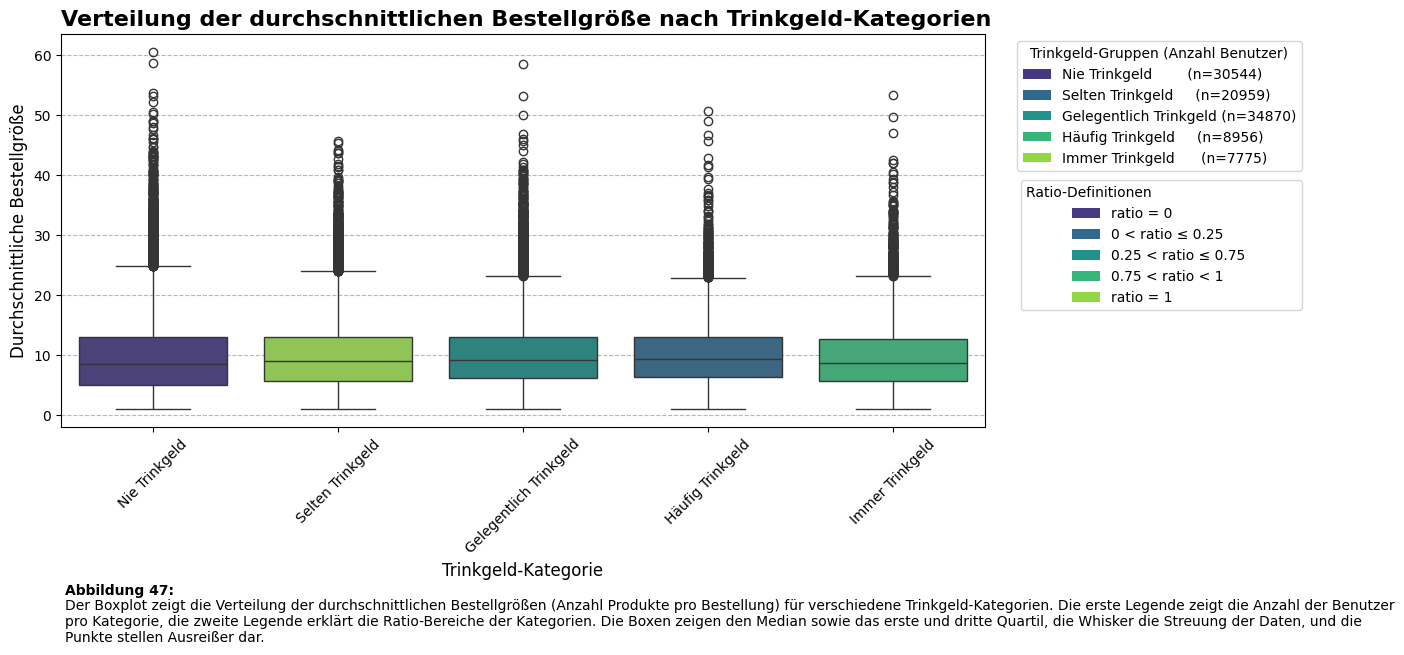

| tip_category           |   count |     mean |     std |   min |     25% |     50% |     75% |     max |
|:-----------------------|--------:|---------:|--------:|------:|--------:|--------:|--------:|--------:|
| Gelegentlich Trinkgeld |   34870 | 10.1248  | 5.57082 |     1 | 6.16667 | 9.16667 | 13      | 58.5    |
| Häufig Trinkgeld       |    8956 | 10.2351  | 5.4301  |     1 | 6.3837  | 9.31401 | 13      | 50.7083 |
| Immer Trinkgeld        |    7775 |  9.81899 | 5.73614 |     1 | 5.71429 | 8.76471 | 12.7071 | 53.2759 |
| Nie Trinkgeld          |   30544 |  9.77409 | 6.30377 |     1 | 5.11111 | 8.6     | 13      | 60.5    |
| Selten Trinkgeld       |   20959 | 10.0188  | 5.85337 |     1 | 5.75894 | 9       | 13.0625 | 45.75   |

In [313]:
# plot code
summary_stats = user_stats_df.groupby('tip_category')['avg_order_size'].describe().reset_index()
markdown_table = tabulate(summary_stats, headers='keys', tablefmt='pipe', showindex=False)


fig, ax = plt.subplots(figsize=(14, 6))
plt.subplots_adjust(left=0.08)

sns.boxplot(
    data=user_stats_df,
    x='tip_category',
    y='avg_order_size',
    order=category_order,
    palette='viridis',
    ax=ax,
    hue='tip_category'
)

ax.set_title('Verteilung der durchschnittlichen Bestellgröße nach Trinkgeld-Kategorien', 
             loc='left', weight='bold', fontsize=16)
ax.set_xlabel('Trinkgeld-Kategorie', fontsize=12)
ax.set_ylabel('Durchschnittliche Bestellgröße', fontsize=12)
ax.set_xticks(range(len(ax.get_xticklabels())))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

legend_elements_1 = [
    Patch(facecolor=sns.color_palette('viridis', len(category_order))[i], 
          label=f"{cat.ljust(20)} (n={group_counts[cat]:<3})")
    for i, cat in enumerate(category_order)
]

legend_1 = ax.legend(
    handles=legend_elements_1,
    title="Trinkgeld-Gruppen (Anzahl Benutzer)".ljust(20),
    loc='upper right',
    bbox_to_anchor=(1.35, 1),
    frameon=True
)

ratio_explanations = [
    "ratio = 0".ljust(20),
    "0 < ratio ≤ 0.25".ljust(20),
    "0.25 < ratio ≤ 0.75".ljust(20),
    "0.75 < ratio < 1".ljust(20),
    "ratio = 1".ljust(20)
]

legend_elements_2 = [
    Patch(facecolor=sns.color_palette('viridis', len(ratio_explanations))[i], label=exp) 
    for i, exp in enumerate(ratio_explanations)
]

legend_2 = ax.legend(
    handles=legend_elements_2,
    title="Ratio-Definitionen".ljust(51),
    loc='lower right',
    bbox_to_anchor=(1.35, 0.28),
    frameon=True
)

ax.add_artist(legend_1)
ax.grid(axis='y', linestyle='--', alpha=0.9)

description = 'Der Boxplot zeigt die Verteilung der durchschnittlichen Bestellgrößen (Anzahl Produkte pro Bestellung) für verschiedene Trinkgeld-Kategorien. Die erste Legende zeigt die Anzahl der Benutzer pro Kategorie, die zweite Legende erklärt die Ratio-Bereiche der Kategorien. Die Boxen zeigen den Median sowie das erste und dritte Quartil, die Whisker die Streuung der Daten, und die Punkte stellen Ausreißer dar.'
fig.text(0.05, 0, 'Abbildung 47:', weight='bold', ha='left')
fig.text(0.05, -0.075, description, wrap=True)

plt.tight_layout()
plt.show()

display(Markdown(markdown_table))


In [30]:
# Liste aller Benutzer die nur eine einzige Bestellung getätigt haben
users_with_one_order = session.query(Order.user_id)\
    .group_by(Order.user_id)\
    .having(func.count(Order.order_id) == 1)\
    .all()

print(f"Anzahl der Benutzer mit nur einer Bestellung: {len(users_with_one_order)}")

Anzahl der Benutzer mit nur einer Bestellung: 0


# ToDos:

x alle tabellen als markdown tabellen ausgeben
x Alle Plots durchgucken ob Beschriftungen korrekt sind
- Konkrete Fragen hinzufügen
x überall wo chi² test gemacht wird korrigierte standardisierte residuen anzeigen in heatmap
- Kurze Interpretationen schreiben für die Auswertungen
- am Ende gucken ob alles nach reset korrekt durchläuft
- ERM Diagramm neu machen
- Power BI machen heute Abend
x Wochentage aus Tabellen entfernen
x plots mit raster austatten
x organic zu produkt analyse
x Kommentare die AI artig sind herausnehmen
x bei query in den comment schreib was gequeried wird
x heausfinden onb man diese FutureWarnings unterdrücken kann oder fixen kann

---
## <h2 id="fragen">Konkrete Fragen</h2> 



### Frage 1:




### Frage 2:




### Frage 3:


---
## <h2 id="handlungsempfehlungen">Handlungsempfehlungen</h2>